# Definitions

In [1]:
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import optuna

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [8]:
train[target_name].mean()

0.19044

In [9]:
train[target_name][train.DepTime > 2400].mean()

1.0

In [10]:
train[target_name][train.DepTime > 2400].shape

(17,)

In [11]:
train.shape

(100000, 9)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [13]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [14]:
test.shape

(100000, 8)

## Split Data

In [15]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## Exploration

<AxesSubplot:>

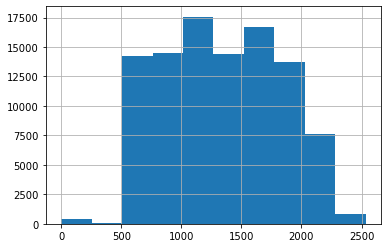

In [17]:
train.DepTime.hist()

In [18]:
train.DepTime.min(), train.DepTime.max()

(1, 2534)

In [19]:
time_groups = train.groupby((train.DepTime-1) // 100) 

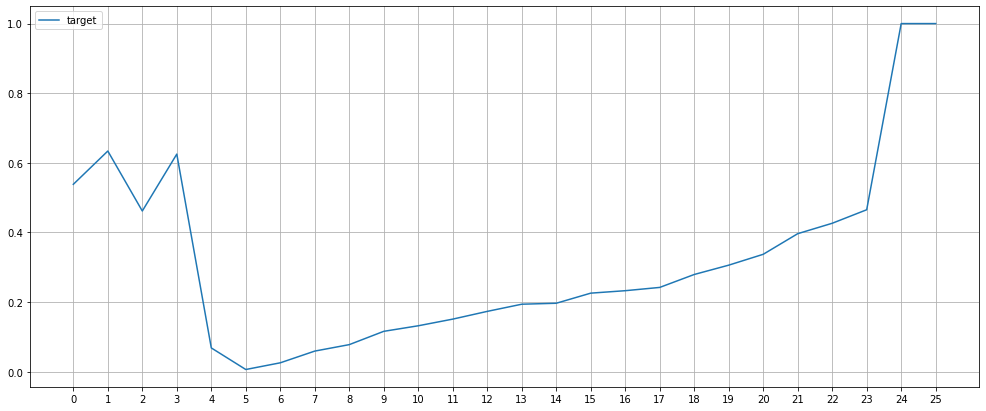

In [20]:
mean_by_t = time_groups[target_name].mean()
count_by_t = time_groups[target_name].count()

plt.figure(figsize=(17, 7))

plt.plot(mean_by_t.index, mean_by_t, label='target')
plt.xticks(range(0, 26))
plt.grid()
plt.legend()

## timestamp decoding

In [21]:
def get_ts(df):
    df['hour'] = df.DepTime // 100
    df['minute'] = df.DepTime % 100
    df['d_month'] = df.DayofMonth.str[2:].astype(int)
    df['d_week'] = df.DayOfWeek.str[2:].astype(int)
    df['month'] = df.Month.str[2:].astype(int)
    
    return df

## timestamp encoding

In [22]:
X = get_ts(X)

In [23]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,d_month,d_week,month
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,19,34,21,7,8
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,15,48,20,3,4
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,14,22,2,5,9
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,10,15,25,6,11
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,18,28,7,6,10


In [24]:
'2021-' + X.month.astype(str) + '-' + X.d_month.astype(str).str.zfill(2) + '-' + X.hour.astype(str).str.zfill(2) + '-' + X.minute.astype(str).str.zfill(2) + '-00'

0         2021-8-21-19-34-00
1         2021-4-20-15-48-00
2         2021-9-02-14-22-00
3        2021-11-25-10-15-00
4        2021-10-07-18-28-00
                ...         
99995     2021-5-04-16-18-00
99996     2021-1-18-08-04-00
99997     2021-1-24-19-01-00
99998     2021-4-27-15-15-00
99999    2021-11-17-18-00-00
Length: 100000, dtype: object

In [25]:
X_ = X[X.DepTime < 2400]
train['dep_dt'] = pd.to_datetime('2021-' + \
                             X_.month.astype(str).str.zfill(2) + '-' +
                             X_.d_month.astype(str).str.zfill(2) + '-' +
                             X_.hour.astype(str).str.zfill(2) + '-' +
                             X_.minute.astype(str).str.zfill(2) + '-00',
                             format='%Y-%m-%d-%H-%M-%S')

<AxesSubplot:>

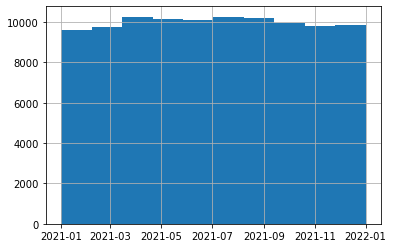

In [26]:
train.dep_dt.hist()

<AxesSubplot:xlabel='dep_dt'>

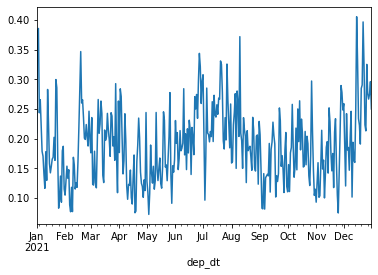

In [27]:
train.groupby(train.dep_dt.dt.to_period('d'))[target_name].mean().plot()

<AxesSubplot:xlabel='dep_dt'>

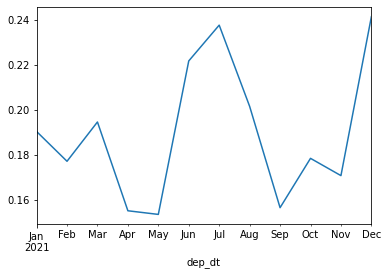

In [28]:
train.groupby(train.dep_dt.dt.to_period('M'))[target_name].mean().plot()

In [29]:
def ts_features(df):
    X_ = df[df.DepTime < 2400]
    dep_dt = pd.to_datetime('2021-' +
                                  X_.month.astype(str).str.zfill(2) + '-' +
                                  X_.d_month.astype(str).str.zfill(2) + '-' +
                                  X_.hour.astype(str).str.zfill(2) + '-' +
                                  X_.minute.astype(str).str.zfill(2) + '-00',
                                  format='%Y-%m-%d-%H-%M-%S')
    dep_td = dep_dt - pd.to_datetime('2021-01-01')
    df['days_since_ny'] = dep_td.dt.days
    df['secs_since_ny'] = dep_td.dt.seconds
    
    return df

## Category encoding

In [30]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [31]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [32]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [33]:
%%time
enc.fit(X_train[cat_cols])
print('Done')

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Done
CPU times: user 153 ms, sys: 16.5 ms, total: 170 ms
Wall time: 273 ms


## Sin/cos ts processing

In [34]:
t_limits = {'minute': (0, 59),
             'hour': (0, 23),
             'd_week': (1, 7),
             'd_month': (1, 31),
             'month': (1, 12),
             'days_since_ny': (0, 364)}

In [35]:
def sin_cos(df):
    for col_name, limits in t_limits.items():
        max_val = limits[1]
        min_val = limits[0]
        if col_name == 'hour':
            orig_vals = df[col_name].clip(upper=max_val)
        else:
            orig_vals = df[col_name]
        df[col_name + '_sin'] = np.sin(2*np.pi/(max_val - min_val)*orig_vals)
        df[col_name + '_cos'] = np.cos(2*np.pi/(max_val - min_val)*orig_vals)
        
    return df

## Sum up prepocessing

In [36]:
def preproc(df):
    df = get_ts(df)
    df = ts_features(df)
    df = sin_cos(df)
    
    df[cat_cols] = enc.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Special features
    df['after_midnight'] = 0
    df.loc[df.DepTime > 2400, 'after_midnight'] = 1
    
    return df

In [37]:
%%time
X_train = preproc(X_train)
X_test = preproc(X_test)

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

CPU times: user 1.45 s, sys: 108 ms, total: 1.56 s
Wall time: 1.64 s


<ipython-input-29-6ca10571684d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_ny'] = dep_td.dt.days
<ipython-input-29-6ca10571684d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_ny'] = dep_td.dt.seconds
<ipython-input-35-02630819fc8c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# Focal loss

In [38]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds*np.ones_like(y_true, dtype=np.float64)

    def lgb_obj(self, y_true, y_pred):
        p = special.expit(y_pred)
        return self.grad(y_true, p), self.hess(y_true, p)

    def lgb_eval(self, y_true, y_pred):
        p = special.expit(y_pred)
        is_higher_better = False
        return 'focal_loss', self(y_true, p).mean(), is_higher_better

# Fit

In [39]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,...,hour_cos,d_week_sin,d_week_cos,d_month_sin,d_month_cos,month_sin,month_cos,days_since_ny_sin,days_since_ny_cos,after_midnight
46343,1.0,1.0,1.0,1805,1.0,1.0,1.0,1235,18,5,...,0.203456,8.660254e-01,0.5,-9.945219e-01,-0.104528,-9.898214e-01,-0.142315,-0.770953,-0.636892,0
75701,2.0,2.0,2.0,819,2.0,2.0,2.0,892,8,19,...,-0.576680,1.224647e-16,-1.0,1.224647e-16,-1.000000,9.096320e-01,0.415415,0.700978,0.713183,0
89227,3.0,3.0,2.0,726,3.0,3.0,3.0,200,7,26,...,-0.334880,1.224647e-16,-1.0,-5.877853e-01,-0.809017,-5.406408e-01,0.841254,-0.957253,0.289252,0
70825,4.0,4.0,3.0,1515,1.0,4.0,4.0,403,15,15,...,-0.576680,8.660254e-01,0.5,8.660254e-01,-0.500000,7.557496e-01,-0.654861,0.990480,-0.137654,0
26022,5.0,5.0,4.0,1453,4.0,5.0,5.0,94,14,53,...,-0.775711,-8.660254e-01,0.5,-9.510565e-01,0.309017,-2.449294e-16,1.000000,-0.596132,0.802886,0


In [40]:
fl = FocalLoss(alpha=0.5, gamma=5)

In [41]:
model = lgb.LGBMClassifier(objective=fl.lgb_obj)

In [42]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_freq': 1,
               'n_estimators': 10_000,
               'random_state': RANDOM_STATE,
               'silent': True,
               'bagging_fraction': 0.638782643397927,
               'feature_fraction': 0.5072049472753989,
               'learning_rate': 0.02238858415024258,
               'max_depth': 10,
               'min_data_in_leaf': 7,
               'reg_alpha': 4.16689412832005,
               'reg_lambda': 3.0220290348080594,
               'n_jobs': 4}

In [43]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               learning_rate=0.02238858415024258, max_depth=10,
               min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               objective=<bound method FocalLoss.lgb_obj of <__main__.FocalLoss object at 0x7feb3546ae80>>,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594)

In [44]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [45]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=[fl.lgb_eval, 'auc'],
          init_score=fl.init_score(y_tr),
          eval_init_score=[fl.init_score(y_tr),
                           fl.init_score(y_es)],
          early_stopping_rounds=100,
          verbose=50)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.735157	training's binary_logloss: 6.41881	training's focal_loss: 0.00755538	valid_1's auc: 0.720662	valid_1's binary_logloss: 6.351	valid_1's focal_loss: 0.00756739
[100]	training's auc: 0.748553	training's binary_logloss: 6.40808	training's focal_loss: 0.00733091	valid_1's auc: 0.729527	valid_1's binary_logloss: 6.341	valid_1's focal_loss: 0.00739125
[150]	training's auc: 0.757969	training's binary_logloss: 6.3747	training's focal_loss: 0.00721137	valid_1's auc: 0.733682	valid_1's binary_logloss: 6.33172	valid_1's focal_loss: 0.00732183
[200]	training's auc: 0.764318	training's binary_logloss: 6.25624	training's focal_loss: 0.00713602	valid_1's auc: 0.736195	valid_1's binary_logloss: 6.20938	valid_1's focal_loss: 0.00728503
[250]	training's auc: 0.770003	training's binary_l

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               learning_rate=0.02238858415024258, max_depth=10,
               min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               objective=<bound method FocalLoss.lgb_obj of <__main__.FocalLoss object at 0x7feb3546ae80>>,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

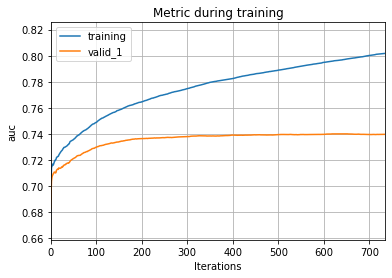

In [46]:
lgb.plot_metric(model, metric='auc')

In [47]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [48]:
with pd.option_context('display.max_rows', None):
    display(fi.sort_values(ascending=False))

Origin               2219
Dest                 2219
days_since_ny_sin    1418
DayofMonth           1335
days_since_ny        1203
days_since_ny_cos    1166
Distance             1142
DepTime              1140
UniqueCarrier        1133
secs_since_ny         681
Month                 675
minute_sin            586
minute                514
hour_sin              503
hour_cos              416
minute_cos            388
hour                  372
DayOfWeek             272
d_month               194
d_week_sin            166
d_month_sin           136
d_month_cos           120
d_week                 68
d_week_cos             66
month_sin              54
month                  40
month_cos              29
after_midnight          0
dtype: int32

# Validate

In [49]:
def get_proba(X, model):
    return special.expit(model.predict(X))

In [50]:
tr_proba = get_proba(X_tr, model)

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


In [51]:
roc_auc_score(y_tr, tr_proba)

0.7965034061865025

In [52]:
roc_auc_score(y_train, get_proba(X_train, model))

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


0.7909462743890358

In [53]:
roc_auc_score(y_test, get_proba(X_test, model))

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


0.7378213349964371

# Optuna

## Prepare folds

In [54]:
cv_splitter = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

In [55]:
train_ds = []
test_ds = []
for train_ind, test_ind in cv_splitter.split(X, y):
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_test, y_test = X.iloc[test_ind], y.iloc[test_ind]

    enc.fit(X_train[cat_cols])

    X_train = preproc(X_train)
    X_test = preproc(X_test)
    
    train_ds.append((X_train, y_train))
    test_ds.append((X_test, y_test))

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: 

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [56]:
X.shape

(100000, 13)

In [57]:
def get_proba(X, model):
    return special.expit(model.predict(X))

In [58]:
def objective(trial):
    alpha = trial.suggest_float("alpha",
                                             0.0, 1.0)
    gamma = trial.suggest_float("gamma",
                                             0, 10)
    fl = FocalLoss(alpha=alpha,
                   gamma=gamma)
    
    lgbm_params = {'boosting': 'gbdt',
                   'bagging_fraction': trial.suggest_float("bagging_fraction",
                                                           0.5, 1.0),
                   'bagging_freq': 1,
                   'feature_fraction': trial.suggest_float("feature_fraction",
                                                           0.5, 1.0),
                   'learning_rate': trial.suggest_float("lr",
                                                        0.0001, 0.5),
                   'max_depth': trial.suggest_int("max_depth", 1, 15),
                   'min_data_in_leaf': trial.suggest_int("min_data_in_leaf",
                                                         1,
                                                         10000, log=True),
                   'n_estimators': 10_000,
                   'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),
                   'reg_lambda': trial.suggest_float("reg_lambda", 0, 10),
                   'random_state': RANDOM_STATE,
                   'silent': True}

    metrics = []
    cv_splitter = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)
    for train_set, test_set in zip(train_ds, test_ds):
        X_train, y_train = train_set
        X_test, y_test = test_set

        X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)
        model = lgb.LGBMClassifier()
        model.set_params(**lgbm_params)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_es, y_es)],
                  eval_metric=[fl.lgb_eval, 'auc'],
                  init_score=fl.init_score(y_tr),
                  eval_init_score=[fl.init_score(y_tr),
                                   fl.init_score(y_es)],
                  early_stopping_rounds=100,
                  verbose=0)
        auc = roc_auc_score(y_test, get_proba(X_test, model))
        metrics.append(auc)
    print(alpha, gamma)
    return sum(metrics) / 5

In [59]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

trial = study.best_trial

pickle.dump(study, open('optuna_study_focal.pkl', 'wb'))

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5365584074246481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365584074246481
[LightGBM] [Warning] bagging_fraction is set=0.9341431526772006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341431526772006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5365584074246481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365584074246481
[LightGBM] [Warning] bagging_fraction is set=0.9341431526772006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341431526772006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5365584074246481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365584074246481
[LightGBM] [Warning] bagging_fraction is set=0.9341431526772006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341431526772006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5365584074246481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365584074246481
[LightGBM] [Warning] bagging_fraction is set=0.9341431526772006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341431526772006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5365584074246481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365584074246481
[LightGBM] [Warning] bagging_fraction is set=0.9341431526772006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341431526772006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.006137836619281245 6.140825467865858
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6571211217405399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571211217405399
[LightGBM] [Warning] bagging_fraction is set=0.8035925266955743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035925266955743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6571211217405399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571211217405399
[LightGBM] [Warning] bagging_fraction is set=0.8035925266955743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035925266955743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6571211217405399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571211217405399
[LightGBM] [Warning] bagging_fraction is set=0.8035925266955743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035925266955743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6571211217405399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571211217405399
[LightGBM] [Warning] bagging_fraction is set=0.8035925266955743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035925266955743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6571211217405399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571211217405399
[LightGBM] [Warning] bagging_fraction is set=0.8035925266955743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035925266955743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8677495045613469 1.48920531953737
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5904967716862646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5904967716862646
[LightGBM] [Warning] bagging_fraction is set=0.6611117291060853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611117291060853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5904967716862646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5904967716862646
[LightGBM] [Warning] bagging_fraction is set=0.6611117291060853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611117291060853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5904967716862646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5904967716862646
[LightGBM] [Warning] bagging_fraction is set=0.6611117291060853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611117291060853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5904967716862646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5904967716862646
[LightGBM] [Warning] bagging_fraction is set=0.6611117291060853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611117291060853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5904967716862646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5904967716862646
[LightGBM] [Warning] bagging_fraction is set=0.6611117291060853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611117291060853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.9985444486955736 9.682668413668367
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7890515677218503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890515677218503
[LightGBM] [Warning] bagging_fraction is set=0.6150310585781469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150310585781469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7890515677218503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890515677218503
[LightGBM] [Warning] bagging_fraction is set=0.6150310585781469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150310585781469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7890515677218503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890515677218503
[LightGBM] [Warning] bagging_fraction is set=0.6150310585781469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150310585781469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7890515677218503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890515677218503
[LightGBM] [Warning] bagging_fraction is set=0.6150310585781469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150310585781469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.7890515677218503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890515677218503
[LightGBM] [Warning] bagging_fraction is set=0.6150310585781469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150310585781469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.37754848395095997 5.219228084971508
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9928993634397911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928993634397911
[LightGBM] [Warning] bagging_fraction is set=0.7799714294452276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799714294452276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9928993634397911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928993634397911
[LightGBM] [Warning] bagging_fraction is set=0.7799714294452276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799714294452276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9928993634397911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928993634397911
[LightGBM] [Warning] bagging_fraction is set=0.7799714294452276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799714294452276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9928993634397911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928993634397911
[LightGBM] [Warning] bagging_fraction is set=0.7799714294452276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799714294452276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9928993634397911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928993634397911
[LightGBM] [Warning] bagging_fraction is set=0.7799714294452276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799714294452276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.48043502936665716 7.256189233232229
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7978399837630679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7978399837630679
[LightGBM] [Warning] bagging_fraction is set=0.875229783971166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875229783971166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7978399837630679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7978399837630679
[LightGBM] [Warning] bagging_fraction is set=0.875229783971166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875229783971166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7978399837630679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7978399837630679
[LightGBM] [Warning] bagging_fraction is set=0.875229783971166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875229783971166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7978399837630679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7978399837630679
[LightGBM] [Warning] bagging_fraction is set=0.875229783971166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875229783971166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7978399837630679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7978399837630679
[LightGBM] [Warning] bagging_fraction is set=0.875229783971166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875229783971166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8506168922024525 1.48855040936553
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.7539469172259401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539469172259401
[LightGBM] [Warning] bagging_fraction is set=0.6624005190390787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624005190390787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.7539469172259401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539469172259401
[LightGBM] [Warning] bagging_fraction is set=0.6624005190390787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624005190390787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.7539469172259401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539469172259401
[LightGBM] [Warning] bagging_fraction is set=0.6624005190390787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624005190390787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.7539469172259401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539469172259401
[LightGBM] [Warning] bagging_fraction is set=0.6624005190390787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624005190390787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.7539469172259401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539469172259401
[LightGBM] [Warning] bagging_fraction is set=0.6624005190390787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624005190390787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.48153867456567034 5.316114687791575
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=422, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=422
[LightGBM] [Warning] feature_fraction is set=0.5421129238599833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421129238599833
[LightGBM] [Warning] bagging_fraction is set=0.9847368521511213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9847368521511213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=422, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=422
[LightGBM] [Warning] feature_fraction is set=0.5421129238599833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421129238599833
[LightGBM] [Warning] bagging_fraction is set=0.9847368521511213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9847368521511213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=422, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=422
[LightGBM] [Warning] feature_fraction is set=0.5421129238599833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421129238599833
[LightGBM] [Warning] bagging_fraction is set=0.9847368521511213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9847368521511213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=422, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=422
[LightGBM] [Warning] feature_fraction is set=0.5421129238599833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421129238599833
[LightGBM] [Warning] bagging_fraction is set=0.9847368521511213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9847368521511213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=422, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=422
[LightGBM] [Warning] feature_fraction is set=0.5421129238599833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421129238599833
[LightGBM] [Warning] bagging_fraction is set=0.9847368521511213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9847368521511213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.9396124650140767 6.9628618759288265
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5563543409212577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5563543409212577
[LightGBM] [Warning] bagging_fraction is set=0.6585789862731581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585789862731581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5563543409212577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5563543409212577
[LightGBM] [Warning] bagging_fraction is set=0.6585789862731581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585789862731581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5563543409212577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5563543409212577
[LightGBM] [Warning] bagging_fraction is set=0.6585789862731581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585789862731581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5563543409212577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5563543409212577
[LightGBM] [Warning] bagging_fraction is set=0.6585789862731581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585789862731581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5563543409212577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5563543409212577
[LightGBM] [Warning] bagging_fraction is set=0.6585789862731581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585789862731581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.7890314131680043 1.038020443419826
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.740735774960716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740735774960716
[LightGBM] [Warning] bagging_fraction is set=0.8026808817011957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026808817011957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.740735774960716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740735774960716
[LightGBM] [Warning] bagging_fraction is set=0.8026808817011957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026808817011957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.740735774960716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740735774960716
[LightGBM] [Warning] bagging_fraction is set=0.8026808817011957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026808817011957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.740735774960716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740735774960716
[LightGBM] [Warning] bagging_fraction is set=0.8026808817011957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026808817011957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.740735774960716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740735774960716
[LightGBM] [Warning] bagging_fraction is set=0.8026808817011957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026808817011957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.44461963183823894 4.183716029501979
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9729, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9729
[LightGBM] [Warning] feature_fraction is set=0.9476394698276341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476394698276341
[LightGBM] [Warning] bagging_fraction is set=0.9825378732545769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825378732545769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9729, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9729
[LightGBM] [Warning] feature_fraction is set=0.9476394698276341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476394698276341
[LightGBM] [Warning] bagging_fraction is set=0.9825378732545769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825378732545769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9729, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9729
[LightGBM] [Warning] feature_fraction is set=0.9476394698276341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476394698276341
[LightGBM] [Warning] bagging_fraction is set=0.9825378732545769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825378732545769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9729, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9729
[LightGBM] [Warning] feature_fraction is set=0.9476394698276341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476394698276341
[LightGBM] [Warning] bagging_fraction is set=0.9825378732545769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825378732545769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9729, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9729
[LightGBM] [Warning] feature_fraction is set=0.9476394698276341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476394698276341
[LightGBM] [Warning] bagging_fraction is set=0.9825378732545769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825378732545769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.029031582212142915 9.595123502843142
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=838, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=838
[LightGBM] [Warning] feature_fraction is set=0.6711983421816589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711983421816589
[LightGBM] [Warning] bagging_fraction is set=0.8919435953488543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919435953488543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=838, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=838
[LightGBM] [Warning] feature_fraction is set=0.6711983421816589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711983421816589
[LightGBM] [Warning] bagging_fraction is set=0.8919435953488543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919435953488543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=838, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=838
[LightGBM] [Warning] feature_fraction is set=0.6711983421816589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711983421816589
[LightGBM] [Warning] bagging_fraction is set=0.8919435953488543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919435953488543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=838, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=838
[LightGBM] [Warning] feature_fraction is set=0.6711983421816589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711983421816589
[LightGBM] [Warning] bagging_fraction is set=0.8919435953488543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919435953488543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=838, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=838
[LightGBM] [Warning] feature_fraction is set=0.6711983421816589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711983421816589
[LightGBM] [Warning] bagging_fraction is set=0.8919435953488543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8919435953488543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.004189640781765536 3.306860870551919
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=798, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=798
[LightGBM] [Warning] feature_fraction is set=0.6512138473488539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512138473488539
[LightGBM] [Warning] bagging_fraction is set=0.9041976113830524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9041976113830524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=798, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=798
[LightGBM] [Warning] feature_fraction is set=0.6512138473488539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512138473488539
[LightGBM] [Warning] bagging_fraction is set=0.9041976113830524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9041976113830524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=798, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=798
[LightGBM] [Warning] feature_fraction is set=0.6512138473488539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512138473488539
[LightGBM] [Warning] bagging_fraction is set=0.9041976113830524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9041976113830524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=798, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=798
[LightGBM] [Warning] feature_fraction is set=0.6512138473488539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512138473488539
[LightGBM] [Warning] bagging_fraction is set=0.9041976113830524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9041976113830524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=798, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=798
[LightGBM] [Warning] feature_fraction is set=0.6512138473488539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6512138473488539
[LightGBM] [Warning] bagging_fraction is set=0.9041976113830524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9041976113830524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.005937711841237665 3.2375851973152616
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=972, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=972
[LightGBM] [Warning] feature_fraction is set=0.6654025735837714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6654025735837714
[LightGBM] [Warning] bagging_fraction is set=0.8950743654801427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950743654801427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=972, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=972
[LightGBM] [Warning] feature_fraction is set=0.6654025735837714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6654025735837714
[LightGBM] [Warning] bagging_fraction is set=0.8950743654801427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950743654801427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=972, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=972
[LightGBM] [Warning] feature_fraction is set=0.6654025735837714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6654025735837714
[LightGBM] [Warning] bagging_fraction is set=0.8950743654801427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950743654801427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=972, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=972
[LightGBM] [Warning] feature_fraction is set=0.6654025735837714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6654025735837714
[LightGBM] [Warning] bagging_fraction is set=0.8950743654801427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950743654801427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=972, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=972
[LightGBM] [Warning] feature_fraction is set=0.6654025735837714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6654025735837714
[LightGBM] [Warning] bagging_fraction is set=0.8950743654801427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950743654801427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19527870131288166 3.110559607919888
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2122
[LightGBM] [Warning] feature_fraction is set=0.6413014055044474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6413014055044474
[LightGBM] [Warning] bagging_fraction is set=0.5215066954234389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215066954234389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2122
[LightGBM] [Warning] feature_fraction is set=0.6413014055044474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6413014055044474
[LightGBM] [Warning] bagging_fraction is set=0.5215066954234389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215066954234389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2122
[LightGBM] [Warning] feature_fraction is set=0.6413014055044474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6413014055044474
[LightGBM] [Warning] bagging_fraction is set=0.5215066954234389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215066954234389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2122
[LightGBM] [Warning] feature_fraction is set=0.6413014055044474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6413014055044474
[LightGBM] [Warning] bagging_fraction is set=0.5215066954234389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215066954234389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2122
[LightGBM] [Warning] feature_fraction is set=0.6413014055044474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6413014055044474
[LightGBM] [Warning] bagging_fraction is set=0.5215066954234389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215066954234389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17431133885356875 2.928318557035867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.691131114165338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691131114165338
[LightGBM] [Warning] bagging_fraction is set=0.8721867086001509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721867086001509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.691131114165338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691131114165338
[LightGBM] [Warning] bagging_fraction is set=0.8721867086001509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721867086001509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.691131114165338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691131114165338
[LightGBM] [Warning] bagging_fraction is set=0.8721867086001509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721867086001509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.691131114165338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691131114165338
[LightGBM] [Warning] bagging_fraction is set=0.8721867086001509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721867086001509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.691131114165338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691131114165338
[LightGBM] [Warning] bagging_fraction is set=0.8721867086001509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721867086001509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15543954903295112 3.211564960018027
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6980, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6980
[LightGBM] [Warning] feature_fraction is set=0.8706867278784935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706867278784935
[LightGBM] [Warning] bagging_fraction is set=0.9251985273725593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251985273725593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6980, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6980
[LightGBM] [Warning] feature_fraction is set=0.8706867278784935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706867278784935
[LightGBM] [Warning] bagging_fraction is set=0.9251985273725593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251985273725593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6980, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6980
[LightGBM] [Warning] feature_fraction is set=0.8706867278784935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706867278784935
[LightGBM] [Warning] bagging_fraction is set=0.9251985273725593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251985273725593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6980, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6980
[LightGBM] [Warning] feature_fraction is set=0.8706867278784935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706867278784935
[LightGBM] [Warning] bagging_fraction is set=0.9251985273725593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251985273725593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6980, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6980
[LightGBM] [Warning] feature_fraction is set=0.8706867278784935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706867278784935
[LightGBM] [Warning] bagging_fraction is set=0.9251985273725593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251985273725593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2732081941333291 0.11381936169137985
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3708
[LightGBM] [Warning] feature_fraction is set=0.6001551818129861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001551818129861
[LightGBM] [Warning] bagging_fraction is set=0.9965942460906205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965942460906205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3708
[LightGBM] [Warning] feature_fraction is set=0.6001551818129861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001551818129861
[LightGBM] [Warning] bagging_fraction is set=0.9965942460906205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965942460906205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3708
[LightGBM] [Warning] feature_fraction is set=0.6001551818129861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001551818129861
[LightGBM] [Warning] bagging_fraction is set=0.9965942460906205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965942460906205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3708
[LightGBM] [Warning] feature_fraction is set=0.6001551818129861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001551818129861
[LightGBM] [Warning] bagging_fraction is set=0.9965942460906205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965942460906205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3708
[LightGBM] [Warning] feature_fraction is set=0.6001551818129861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001551818129861
[LightGBM] [Warning] bagging_fraction is set=0.9965942460906205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965942460906205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.006006791715088547 4.083716027233776
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3563, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3563
[LightGBM] [Warning] feature_fraction is set=0.6011301955435203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6011301955435203
[LightGBM] [Warning] bagging_fraction is set=0.9845849291356246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845849291356246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3563, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3563
[LightGBM] [Warning] feature_fraction is set=0.6011301955435203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6011301955435203
[LightGBM] [Warning] bagging_fraction is set=0.9845849291356246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845849291356246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3563, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3563
[LightGBM] [Warning] feature_fraction is set=0.6011301955435203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6011301955435203
[LightGBM] [Warning] bagging_fraction is set=0.9845849291356246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845849291356246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3563, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3563
[LightGBM] [Warning] feature_fraction is set=0.6011301955435203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6011301955435203
[LightGBM] [Warning] bagging_fraction is set=0.9845849291356246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845849291356246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3563, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3563
[LightGBM] [Warning] feature_fraction is set=0.6011301955435203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6011301955435203
[LightGBM] [Warning] bagging_fraction is set=0.9845849291356246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845849291356246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.6760291185848994 4.27224798311026
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.6013070429732507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013070429732507
[LightGBM] [Warning] bagging_fraction is set=0.8392139694801132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392139694801132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.6013070429732507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013070429732507
[LightGBM] [Warning] bagging_fraction is set=0.8392139694801132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392139694801132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.6013070429732507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013070429732507
[LightGBM] [Warning] bagging_fraction is set=0.8392139694801132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392139694801132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.6013070429732507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013070429732507
[LightGBM] [Warning] bagging_fraction is set=0.8392139694801132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392139694801132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.6013070429732507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013070429732507
[LightGBM] [Warning] bagging_fraction is set=0.8392139694801132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392139694801132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09258725361130549 8.023116398807678
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4028
[LightGBM] [Warning] feature_fraction is set=0.7085154824768848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7085154824768848
[LightGBM] [Warning] bagging_fraction is set=0.9990053274597014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990053274597014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4028
[LightGBM] [Warning] feature_fraction is set=0.7085154824768848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7085154824768848
[LightGBM] [Warning] bagging_fraction is set=0.9990053274597014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990053274597014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4028
[LightGBM] [Warning] feature_fraction is set=0.7085154824768848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7085154824768848
[LightGBM] [Warning] bagging_fraction is set=0.9990053274597014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990053274597014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4028
[LightGBM] [Warning] feature_fraction is set=0.7085154824768848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7085154824768848
[LightGBM] [Warning] bagging_fraction is set=0.9990053274597014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990053274597014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4028
[LightGBM] [Warning] feature_fraction is set=0.7085154824768848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7085154824768848
[LightGBM] [Warning] bagging_fraction is set=0.9990053274597014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990053274597014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.31349013608129056 2.2347235455341123
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2774, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2774
[LightGBM] [Warning] feature_fraction is set=0.7185392093268287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185392093268287
[LightGBM] [Warning] bagging_fraction is set=0.9984564588300309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984564588300309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2774, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2774
[LightGBM] [Warning] feature_fraction is set=0.7185392093268287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185392093268287
[LightGBM] [Warning] bagging_fraction is set=0.9984564588300309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984564588300309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2774, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2774
[LightGBM] [Warning] feature_fraction is set=0.7185392093268287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185392093268287
[LightGBM] [Warning] bagging_fraction is set=0.9984564588300309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984564588300309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2774, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2774
[LightGBM] [Warning] feature_fraction is set=0.7185392093268287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185392093268287
[LightGBM] [Warning] bagging_fraction is set=0.9984564588300309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984564588300309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2774, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2774
[LightGBM] [Warning] feature_fraction is set=0.7185392093268287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185392093268287
[LightGBM] [Warning] bagging_fraction is set=0.9984564588300309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984564588300309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3005489886784354 2.201376241479765
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3281
[LightGBM] [Warning] feature_fraction is set=0.7177485813151454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7177485813151454
[LightGBM] [Warning] bagging_fraction is set=0.9963428707070715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963428707070715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3281
[LightGBM] [Warning] feature_fraction is set=0.7177485813151454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7177485813151454
[LightGBM] [Warning] bagging_fraction is set=0.9963428707070715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963428707070715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3281
[LightGBM] [Warning] feature_fraction is set=0.7177485813151454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7177485813151454
[LightGBM] [Warning] bagging_fraction is set=0.9963428707070715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963428707070715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3281
[LightGBM] [Warning] feature_fraction is set=0.7177485813151454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7177485813151454
[LightGBM] [Warning] bagging_fraction is set=0.9963428707070715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963428707070715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3281
[LightGBM] [Warning] feature_fraction is set=0.7177485813151454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7177485813151454
[LightGBM] [Warning] bagging_fraction is set=0.9963428707070715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963428707070715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.6122573739719448 2.2888354407472624
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8305, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8305
[LightGBM] [Warning] feature_fraction is set=0.8306360584999101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306360584999101
[LightGBM] [Warning] bagging_fraction is set=0.952217273727524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952217273727524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8305, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8305
[LightGBM] [Warning] feature_fraction is set=0.8306360584999101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306360584999101
[LightGBM] [Warning] bagging_fraction is set=0.952217273727524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952217273727524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8305, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8305
[LightGBM] [Warning] feature_fraction is set=0.8306360584999101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306360584999101
[LightGBM] [Warning] bagging_fraction is set=0.952217273727524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952217273727524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8305, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8305
[LightGBM] [Warning] feature_fraction is set=0.8306360584999101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306360584999101
[LightGBM] [Warning] bagging_fraction is set=0.952217273727524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952217273727524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8305, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8305
[LightGBM] [Warning] feature_fraction is set=0.8306360584999101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306360584999101
[LightGBM] [Warning] bagging_fraction is set=0.952217273727524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952217273727524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.33693559776192517 0.7823281773396682
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7867, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7867
[LightGBM] [Warning] feature_fraction is set=0.8666861190129891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666861190129891
[LightGBM] [Warning] bagging_fraction is set=0.9519167421705016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519167421705016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7867, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7867
[LightGBM] [Warning] feature_fraction is set=0.8666861190129891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666861190129891
[LightGBM] [Warning] bagging_fraction is set=0.9519167421705016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519167421705016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7867, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7867
[LightGBM] [Warning] feature_fraction is set=0.8666861190129891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666861190129891
[LightGBM] [Warning] bagging_fraction is set=0.9519167421705016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519167421705016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7867, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7867
[LightGBM] [Warning] feature_fraction is set=0.8666861190129891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666861190129891
[LightGBM] [Warning] bagging_fraction is set=0.9519167421705016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519167421705016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7867, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7867
[LightGBM] [Warning] feature_fraction is set=0.8666861190129891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666861190129891
[LightGBM] [Warning] bagging_fraction is set=0.9519167421705016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519167421705016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3453161426150192 0.34745766564877023
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1624, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1624
[LightGBM] [Warning] feature_fraction is set=0.8376126950955854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8376126950955854
[LightGBM] [Warning] bagging_fraction is set=0.9530920418814052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530920418814052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1624, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1624
[LightGBM] [Warning] feature_fraction is set=0.8376126950955854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8376126950955854
[LightGBM] [Warning] bagging_fraction is set=0.9530920418814052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530920418814052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1624, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1624
[LightGBM] [Warning] feature_fraction is set=0.8376126950955854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8376126950955854
[LightGBM] [Warning] bagging_fraction is set=0.9530920418814052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530920418814052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1624, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1624
[LightGBM] [Warning] feature_fraction is set=0.8376126950955854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8376126950955854
[LightGBM] [Warning] bagging_fraction is set=0.9530920418814052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530920418814052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1624, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1624
[LightGBM] [Warning] feature_fraction is set=0.8376126950955854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8376126950955854
[LightGBM] [Warning] bagging_fraction is set=0.9530920418814052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530920418814052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5712522967573825 4.273008371340577
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9887, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9887
[LightGBM] [Warning] feature_fraction is set=0.9251962653884396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251962653884396
[LightGBM] [Warning] bagging_fraction is set=0.9455037097431098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455037097431098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9887, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9887
[LightGBM] [Warning] feature_fraction is set=0.9251962653884396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251962653884396
[LightGBM] [Warning] bagging_fraction is set=0.9455037097431098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455037097431098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9887, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9887
[LightGBM] [Warning] feature_fraction is set=0.9251962653884396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251962653884396
[LightGBM] [Warning] bagging_fraction is set=0.9455037097431098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455037097431098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9887, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9887
[LightGBM] [Warning] feature_fraction is set=0.9251962653884396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251962653884396
[LightGBM] [Warning] bagging_fraction is set=0.9455037097431098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455037097431098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9887, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9887
[LightGBM] [Warning] feature_fraction is set=0.9251962653884396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251962653884396
[LightGBM] [Warning] bagging_fraction is set=0.9455037097431098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455037097431098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.24662816944587507 0.7450732924647127
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4039, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4039
[LightGBM] [Warning] feature_fraction is set=0.7898683132794381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7898683132794381
[LightGBM] [Warning] bagging_fraction is set=0.7490146904985198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490146904985198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4039, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4039
[LightGBM] [Warning] feature_fraction is set=0.7898683132794381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7898683132794381
[LightGBM] [Warning] bagging_fraction is set=0.7490146904985198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490146904985198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4039, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4039
[LightGBM] [Warning] feature_fraction is set=0.7898683132794381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7898683132794381
[LightGBM] [Warning] bagging_fraction is set=0.7490146904985198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490146904985198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4039, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4039
[LightGBM] [Warning] feature_fraction is set=0.7898683132794381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7898683132794381
[LightGBM] [Warning] bagging_fraction is set=0.7490146904985198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490146904985198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4039, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4039
[LightGBM] [Warning] feature_fraction is set=0.7898683132794381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7898683132794381
[LightGBM] [Warning] bagging_fraction is set=0.7490146904985198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490146904985198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.396537401552429 1.8270476327177911
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5329
[LightGBM] [Warning] feature_fraction is set=0.8341536773770872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8341536773770872
[LightGBM] [Warning] bagging_fraction is set=0.8465170806334636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8465170806334636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5329
[LightGBM] [Warning] feature_fraction is set=0.8341536773770872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8341536773770872
[LightGBM] [Warning] bagging_fraction is set=0.8465170806334636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8465170806334636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5329
[LightGBM] [Warning] feature_fraction is set=0.8341536773770872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8341536773770872
[LightGBM] [Warning] bagging_fraction is set=0.8465170806334636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8465170806334636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5329
[LightGBM] [Warning] feature_fraction is set=0.8341536773770872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8341536773770872
[LightGBM] [Warning] bagging_fraction is set=0.8465170806334636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8465170806334636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5329
[LightGBM] [Warning] feature_fraction is set=0.8341536773770872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8341536773770872
[LightGBM] [Warning] bagging_fraction is set=0.8465170806334636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8465170806334636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10578012170747797 0.02439210596735697
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1457
[LightGBM] [Warning] feature_fraction is set=0.7662623471484192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662623471484192
[LightGBM] [Warning] bagging_fraction is set=0.931322824366182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931322824366182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1457
[LightGBM] [Warning] feature_fraction is set=0.7662623471484192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662623471484192
[LightGBM] [Warning] bagging_fraction is set=0.931322824366182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931322824366182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1457
[LightGBM] [Warning] feature_fraction is set=0.7662623471484192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662623471484192
[LightGBM] [Warning] bagging_fraction is set=0.931322824366182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931322824366182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1457
[LightGBM] [Warning] feature_fraction is set=0.7662623471484192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662623471484192
[LightGBM] [Warning] bagging_fraction is set=0.931322824366182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931322824366182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1457
[LightGBM] [Warning] feature_fraction is set=0.7662623471484192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662623471484192
[LightGBM] [Warning] bagging_fraction is set=0.931322824366182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.931322824366182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5884424834215887 6.015436728124794
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] feature_fraction is set=0.524675998754971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524675998754971
[LightGBM] [Warning] bagging_fraction is set=0.9995081764271866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995081764271866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] feature_fraction is set=0.524675998754971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524675998754971
[LightGBM] [Warning] bagging_fraction is set=0.9995081764271866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995081764271866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] feature_fraction is set=0.524675998754971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524675998754971
[LightGBM] [Warning] bagging_fraction is set=0.9995081764271866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995081764271866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] feature_fraction is set=0.524675998754971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524675998754971
[LightGBM] [Warning] bagging_fraction is set=0.9995081764271866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995081764271866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] feature_fraction is set=0.524675998754971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.524675998754971
[LightGBM] [Warning] bagging_fraction is set=0.9995081764271866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995081764271866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.24037705664879727 3.851371210565308
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6876
[LightGBM] [Warning] feature_fraction is set=0.8959246039044888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959246039044888
[LightGBM] [Warning] bagging_fraction is set=0.9573634901676132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9573634901676132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6876
[LightGBM] [Warning] feature_fraction is set=0.8959246039044888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959246039044888
[LightGBM] [Warning] bagging_fraction is set=0.9573634901676132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9573634901676132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6876
[LightGBM] [Warning] feature_fraction is set=0.8959246039044888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959246039044888
[LightGBM] [Warning] bagging_fraction is set=0.9573634901676132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9573634901676132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6876
[LightGBM] [Warning] feature_fraction is set=0.8959246039044888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959246039044888
[LightGBM] [Warning] bagging_fraction is set=0.9573634901676132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9573634901676132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6876
[LightGBM] [Warning] feature_fraction is set=0.8959246039044888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959246039044888
[LightGBM] [Warning] bagging_fraction is set=0.9573634901676132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9573634901676132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3782579382195966 0.5351491096904938
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5730
[LightGBM] [Warning] feature_fraction is set=0.9078799277358752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078799277358752
[LightGBM] [Warning] bagging_fraction is set=0.9562902190742723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562902190742723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5730
[LightGBM] [Warning] feature_fraction is set=0.9078799277358752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078799277358752
[LightGBM] [Warning] bagging_fraction is set=0.9562902190742723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562902190742723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5730
[LightGBM] [Warning] feature_fraction is set=0.9078799277358752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078799277358752
[LightGBM] [Warning] bagging_fraction is set=0.9562902190742723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562902190742723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5730
[LightGBM] [Warning] feature_fraction is set=0.9078799277358752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078799277358752
[LightGBM] [Warning] bagging_fraction is set=0.9562902190742723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562902190742723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5730
[LightGBM] [Warning] feature_fraction is set=0.9078799277358752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078799277358752
[LightGBM] [Warning] bagging_fraction is set=0.9562902190742723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562902190742723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.31727097004633875 1.1913111282793225
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8884, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8884
[LightGBM] [Warning] feature_fraction is set=0.9186768322116174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186768322116174
[LightGBM] [Warning] bagging_fraction is set=0.9169742117252973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169742117252973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8884, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8884
[LightGBM] [Warning] feature_fraction is set=0.9186768322116174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186768322116174
[LightGBM] [Warning] bagging_fraction is set=0.9169742117252973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169742117252973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8884, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8884
[LightGBM] [Warning] feature_fraction is set=0.9186768322116174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186768322116174
[LightGBM] [Warning] bagging_fraction is set=0.9169742117252973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169742117252973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8884, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8884
[LightGBM] [Warning] feature_fraction is set=0.9186768322116174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186768322116174
[LightGBM] [Warning] bagging_fraction is set=0.9169742117252973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169742117252973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8884, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8884
[LightGBM] [Warning] feature_fraction is set=0.9186768322116174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9186768322116174
[LightGBM] [Warning] bagging_fraction is set=0.9169742117252973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169742117252973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.39575151788769 0.8899505771849733
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9365
[LightGBM] [Warning] feature_fraction is set=0.8959414583981764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959414583981764
[LightGBM] [Warning] bagging_fraction is set=0.9581066090677103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9581066090677103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9365
[LightGBM] [Warning] feature_fraction is set=0.8959414583981764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959414583981764
[LightGBM] [Warning] bagging_fraction is set=0.9581066090677103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9581066090677103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9365
[LightGBM] [Warning] feature_fraction is set=0.8959414583981764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959414583981764
[LightGBM] [Warning] bagging_fraction is set=0.9581066090677103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9581066090677103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9365
[LightGBM] [Warning] feature_fraction is set=0.8959414583981764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959414583981764
[LightGBM] [Warning] bagging_fraction is set=0.9581066090677103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9581066090677103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9365
[LightGBM] [Warning] feature_fraction is set=0.8959414583981764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959414583981764
[LightGBM] [Warning] bagging_fraction is set=0.9581066090677103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9581066090677103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5488478444893499 1.3275551029701829
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1836
[LightGBM] [Warning] feature_fraction is set=0.9947474986174003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947474986174003
[LightGBM] [Warning] bagging_fraction is set=0.8385677845511736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8385677845511736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1836
[LightGBM] [Warning] feature_fraction is set=0.9947474986174003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947474986174003
[LightGBM] [Warning] bagging_fraction is set=0.8385677845511736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8385677845511736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1836
[LightGBM] [Warning] feature_fraction is set=0.9947474986174003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947474986174003
[LightGBM] [Warning] bagging_fraction is set=0.8385677845511736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8385677845511736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1836
[LightGBM] [Warning] feature_fraction is set=0.9947474986174003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947474986174003
[LightGBM] [Warning] bagging_fraction is set=0.8385677845511736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8385677845511736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1836, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1836
[LightGBM] [Warning] feature_fraction is set=0.9947474986174003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947474986174003
[LightGBM] [Warning] bagging_fraction is set=0.8385677845511736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8385677845511736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4133722366133884 0.3056621060067256
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] feature_fraction is set=0.9655912079455303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655912079455303
[LightGBM] [Warning] bagging_fraction is set=0.7409854580583137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7409854580583137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] feature_fraction is set=0.9655912079455303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655912079455303
[LightGBM] [Warning] bagging_fraction is set=0.7409854580583137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7409854580583137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] feature_fraction is set=0.9655912079455303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655912079455303
[LightGBM] [Warning] bagging_fraction is set=0.7409854580583137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7409854580583137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] feature_fraction is set=0.9655912079455303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655912079455303
[LightGBM] [Warning] bagging_fraction is set=0.7409854580583137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7409854580583137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] feature_fraction is set=0.9655912079455303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655912079455303
[LightGBM] [Warning] bagging_fraction is set=0.7409854580583137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7409854580583137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.35142476227417485 0.6214911095109112
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=481
[LightGBM] [Warning] feature_fraction is set=0.9620057909597249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620057909597249
[LightGBM] [Warning] bagging_fraction is set=0.7563053855679349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563053855679349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=481
[LightGBM] [Warning] feature_fraction is set=0.9620057909597249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620057909597249
[LightGBM] [Warning] bagging_fraction is set=0.7563053855679349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563053855679349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=481
[LightGBM] [Warning] feature_fraction is set=0.9620057909597249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620057909597249
[LightGBM] [Warning] bagging_fraction is set=0.7563053855679349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563053855679349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=481
[LightGBM] [Warning] feature_fraction is set=0.9620057909597249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620057909597249
[LightGBM] [Warning] bagging_fraction is set=0.7563053855679349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563053855679349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=481
[LightGBM] [Warning] feature_fraction is set=0.9620057909597249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620057909597249
[LightGBM] [Warning] bagging_fraction is set=0.7563053855679349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563053855679349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.6809294945039277 8.936540552562422
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9627058100941916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627058100941916
[LightGBM] [Warning] bagging_fraction is set=0.7343987333922345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7343987333922345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9627058100941916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627058100941916
[LightGBM] [Warning] bagging_fraction is set=0.7343987333922345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7343987333922345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9627058100941916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627058100941916
[LightGBM] [Warning] bagging_fraction is set=0.7343987333922345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7343987333922345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9627058100941916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627058100941916
[LightGBM] [Warning] bagging_fraction is set=0.7343987333922345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7343987333922345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9627058100941916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627058100941916
[LightGBM] [Warning] bagging_fraction is set=0.7343987333922345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7343987333922345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5081386721933027 1.7858667403472848
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.8092001257648755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092001257648755
[LightGBM] [Warning] bagging_fraction is set=0.7043554377412411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043554377412411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.8092001257648755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092001257648755
[LightGBM] [Warning] bagging_fraction is set=0.7043554377412411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043554377412411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.8092001257648755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092001257648755
[LightGBM] [Warning] bagging_fraction is set=0.7043554377412411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043554377412411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.8092001257648755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092001257648755
[LightGBM] [Warning] bagging_fraction is set=0.7043554377412411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043554377412411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.8092001257648755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092001257648755
[LightGBM] [Warning] bagging_fraction is set=0.7043554377412411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043554377412411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4565546682338094 0.5078027521663596
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=468
[LightGBM] [Warning] feature_fraction is set=0.8714253737939117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8714253737939117
[LightGBM] [Warning] bagging_fraction is set=0.5487587177511477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487587177511477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=468
[LightGBM] [Warning] feature_fraction is set=0.8714253737939117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8714253737939117
[LightGBM] [Warning] bagging_fraction is set=0.5487587177511477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487587177511477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=468
[LightGBM] [Warning] feature_fraction is set=0.8714253737939117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8714253737939117
[LightGBM] [Warning] bagging_fraction is set=0.5487587177511477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487587177511477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=468
[LightGBM] [Warning] feature_fraction is set=0.8714253737939117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8714253737939117
[LightGBM] [Warning] bagging_fraction is set=0.5487587177511477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487587177511477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=468
[LightGBM] [Warning] feature_fraction is set=0.8714253737939117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8714253737939117
[LightGBM] [Warning] bagging_fraction is set=0.5487587177511477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487587177511477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10799910211766323 5.537818827710299
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5537
[LightGBM] [Warning] feature_fraction is set=0.9026215458347541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026215458347541
[LightGBM] [Warning] bagging_fraction is set=0.6988147933326442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988147933326442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5537
[LightGBM] [Warning] feature_fraction is set=0.9026215458347541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026215458347541
[LightGBM] [Warning] bagging_fraction is set=0.6988147933326442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988147933326442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5537
[LightGBM] [Warning] feature_fraction is set=0.9026215458347541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026215458347541
[LightGBM] [Warning] bagging_fraction is set=0.6988147933326442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988147933326442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5537
[LightGBM] [Warning] feature_fraction is set=0.9026215458347541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026215458347541
[LightGBM] [Warning] bagging_fraction is set=0.6988147933326442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988147933326442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5537
[LightGBM] [Warning] feature_fraction is set=0.9026215458347541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026215458347541
[LightGBM] [Warning] bagging_fraction is set=0.6988147933326442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988147933326442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3830651189697481 1.224202385341635
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1049, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1049
[LightGBM] [Warning] feature_fraction is set=0.9377096427347186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377096427347186
[LightGBM] [Warning] bagging_fraction is set=0.8005167464338039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005167464338039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1049, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1049
[LightGBM] [Warning] feature_fraction is set=0.9377096427347186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377096427347186
[LightGBM] [Warning] bagging_fraction is set=0.8005167464338039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005167464338039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1049, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1049
[LightGBM] [Warning] feature_fraction is set=0.9377096427347186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377096427347186
[LightGBM] [Warning] bagging_fraction is set=0.8005167464338039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005167464338039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1049, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1049
[LightGBM] [Warning] feature_fraction is set=0.9377096427347186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377096427347186
[LightGBM] [Warning] bagging_fraction is set=0.8005167464338039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005167464338039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1049, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1049
[LightGBM] [Warning] feature_fraction is set=0.9377096427347186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377096427347186
[LightGBM] [Warning] bagging_fraction is set=0.8005167464338039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005167464338039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.34759399119551454 2.6502725468706676
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2578, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2578
[LightGBM] [Warning] feature_fraction is set=0.8424038952891408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424038952891408
[LightGBM] [Warning] bagging_fraction is set=0.9688547886518923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9688547886518923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2578, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2578
[LightGBM] [Warning] feature_fraction is set=0.8424038952891408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424038952891408
[LightGBM] [Warning] bagging_fraction is set=0.9688547886518923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9688547886518923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2578, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2578
[LightGBM] [Warning] feature_fraction is set=0.8424038952891408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424038952891408
[LightGBM] [Warning] bagging_fraction is set=0.9688547886518923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9688547886518923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2578, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2578
[LightGBM] [Warning] feature_fraction is set=0.8424038952891408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424038952891408
[LightGBM] [Warning] bagging_fraction is set=0.9688547886518923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9688547886518923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2578, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2578
[LightGBM] [Warning] feature_fraction is set=0.8424038952891408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424038952891408
[LightGBM] [Warning] bagging_fraction is set=0.9688547886518923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9688547886518923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.513758150471705 1.6860768310068341
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5445
[LightGBM] [Warning] feature_fraction is set=0.9764912322753044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9764912322753044
[LightGBM] [Warning] bagging_fraction is set=0.8715356770798769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715356770798769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5445
[LightGBM] [Warning] feature_fraction is set=0.9764912322753044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9764912322753044
[LightGBM] [Warning] bagging_fraction is set=0.8715356770798769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715356770798769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5445
[LightGBM] [Warning] feature_fraction is set=0.9764912322753044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9764912322753044
[LightGBM] [Warning] bagging_fraction is set=0.8715356770798769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715356770798769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5445
[LightGBM] [Warning] feature_fraction is set=0.9764912322753044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9764912322753044
[LightGBM] [Warning] bagging_fraction is set=0.8715356770798769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715356770798769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5445
[LightGBM] [Warning] feature_fraction is set=0.9764912322753044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9764912322753044
[LightGBM] [Warning] bagging_fraction is set=0.8715356770798769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715356770798769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21669127942127642 0.8665442415766096
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9001435426574035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001435426574035
[LightGBM] [Warning] bagging_fraction is set=0.6894534115989958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894534115989958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9001435426574035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001435426574035
[LightGBM] [Warning] bagging_fraction is set=0.6894534115989958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894534115989958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9001435426574035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001435426574035
[LightGBM] [Warning] bagging_fraction is set=0.6894534115989958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894534115989958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9001435426574035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001435426574035
[LightGBM] [Warning] bagging_fraction is set=0.6894534115989958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894534115989958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9001435426574035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001435426574035
[LightGBM] [Warning] bagging_fraction is set=0.6894534115989958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894534115989958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.33726374789536856 0.1400628228385336
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] feature_fraction is set=0.8141396269869204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8141396269869204
[LightGBM] [Warning] bagging_fraction is set=0.5921634776097615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5921634776097615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] feature_fraction is set=0.8141396269869204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8141396269869204
[LightGBM] [Warning] bagging_fraction is set=0.5921634776097615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5921634776097615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] feature_fraction is set=0.8141396269869204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8141396269869204
[LightGBM] [Warning] bagging_fraction is set=0.5921634776097615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5921634776097615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] feature_fraction is set=0.8141396269869204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8141396269869204
[LightGBM] [Warning] bagging_fraction is set=0.5921634776097615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5921634776097615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] feature_fraction is set=0.8141396269869204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8141396269869204
[LightGBM] [Warning] bagging_fraction is set=0.5921634776097615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5921634776097615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.433017379872396 4.82728936640872
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=614, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=614
[LightGBM] [Warning] feature_fraction is set=0.8861170134511814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861170134511814
[LightGBM] [Warning] bagging_fraction is set=0.9725846922702757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725846922702757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=614, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=614
[LightGBM] [Warning] feature_fraction is set=0.8861170134511814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861170134511814
[LightGBM] [Warning] bagging_fraction is set=0.9725846922702757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725846922702757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=614, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=614
[LightGBM] [Warning] feature_fraction is set=0.8861170134511814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861170134511814
[LightGBM] [Warning] bagging_fraction is set=0.9725846922702757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725846922702757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=614, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=614
[LightGBM] [Warning] feature_fraction is set=0.8861170134511814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861170134511814
[LightGBM] [Warning] bagging_fraction is set=0.9725846922702757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725846922702757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=614, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=614
[LightGBM] [Warning] feature_fraction is set=0.8861170134511814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861170134511814
[LightGBM] [Warning] bagging_fraction is set=0.9725846922702757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725846922702757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2812485385783604 1.2878864236462486
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2365
[LightGBM] [Warning] feature_fraction is set=0.8547286387462447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547286387462447
[LightGBM] [Warning] bagging_fraction is set=0.9113151098479711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113151098479711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2365
[LightGBM] [Warning] feature_fraction is set=0.8547286387462447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547286387462447
[LightGBM] [Warning] bagging_fraction is set=0.9113151098479711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113151098479711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2365
[LightGBM] [Warning] feature_fraction is set=0.8547286387462447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547286387462447
[LightGBM] [Warning] bagging_fraction is set=0.9113151098479711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113151098479711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2365
[LightGBM] [Warning] feature_fraction is set=0.8547286387462447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547286387462447
[LightGBM] [Warning] bagging_fraction is set=0.9113151098479711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113151098479711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2365, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2365
[LightGBM] [Warning] feature_fraction is set=0.8547286387462447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547286387462447
[LightGBM] [Warning] bagging_fraction is set=0.9113151098479711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113151098479711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.47166142543502376 0.5475238818790061
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] feature_fraction is set=0.7721299200376934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721299200376934
[LightGBM] [Warning] bagging_fraction is set=0.7688444598536516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7688444598536516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] feature_fraction is set=0.7721299200376934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721299200376934
[LightGBM] [Warning] bagging_fraction is set=0.7688444598536516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7688444598536516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] feature_fraction is set=0.7721299200376934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721299200376934
[LightGBM] [Warning] bagging_fraction is set=0.7688444598536516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7688444598536516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] feature_fraction is set=0.7721299200376934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721299200376934
[LightGBM] [Warning] bagging_fraction is set=0.7688444598536516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7688444598536516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] feature_fraction is set=0.7721299200376934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721299200376934
[LightGBM] [Warning] bagging_fraction is set=0.7688444598536516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7688444598536516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1461941000678693 7.1994514868212685
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.9253991504477154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9253991504477154
[LightGBM] [Warning] bagging_fraction is set=0.7187064915612128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7187064915612128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.9253991504477154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9253991504477154
[LightGBM] [Warning] bagging_fraction is set=0.7187064915612128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7187064915612128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.9253991504477154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9253991504477154
[LightGBM] [Warning] bagging_fraction is set=0.7187064915612128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7187064915612128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.9253991504477154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9253991504477154
[LightGBM] [Warning] bagging_fraction is set=0.7187064915612128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7187064915612128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] feature_fraction is set=0.9253991504477154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9253991504477154
[LightGBM] [Warning] bagging_fraction is set=0.7187064915612128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7187064915612128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.34651657164446326 6.614189853547337
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1996, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1996
[LightGBM] [Warning] feature_fraction is set=0.997478504603755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997478504603755
[LightGBM] [Warning] bagging_fraction is set=0.8344903804925622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344903804925622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1996, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1996
[LightGBM] [Warning] feature_fraction is set=0.997478504603755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997478504603755
[LightGBM] [Warning] bagging_fraction is set=0.8344903804925622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344903804925622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1996, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1996
[LightGBM] [Warning] feature_fraction is set=0.997478504603755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997478504603755
[LightGBM] [Warning] bagging_fraction is set=0.8344903804925622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344903804925622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1996, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1996
[LightGBM] [Warning] feature_fraction is set=0.997478504603755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997478504603755
[LightGBM] [Warning] bagging_fraction is set=0.8344903804925622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344903804925622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1996, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1996
[LightGBM] [Warning] feature_fraction is set=0.997478504603755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997478504603755
[LightGBM] [Warning] bagging_fraction is set=0.8344903804925622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344903804925622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4202210026068607 0.13584975789992426
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5270
[LightGBM] [Warning] feature_fraction is set=0.999567013742886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999567013742886
[LightGBM] [Warning] bagging_fraction is set=0.9364414855926916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9364414855926916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5270
[LightGBM] [Warning] feature_fraction is set=0.999567013742886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999567013742886
[LightGBM] [Warning] bagging_fraction is set=0.9364414855926916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9364414855926916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5270
[LightGBM] [Warning] feature_fraction is set=0.999567013742886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999567013742886
[LightGBM] [Warning] bagging_fraction is set=0.9364414855926916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9364414855926916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5270
[LightGBM] [Warning] feature_fraction is set=0.999567013742886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999567013742886
[LightGBM] [Warning] bagging_fraction is set=0.9364414855926916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9364414855926916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5270
[LightGBM] [Warning] feature_fraction is set=0.999567013742886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999567013742886
[LightGBM] [Warning] bagging_fraction is set=0.9364414855926916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9364414855926916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.25364459508217946 0.9849086738309707
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7080
[LightGBM] [Warning] feature_fraction is set=0.9689605480612323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689605480612323
[LightGBM] [Warning] bagging_fraction is set=0.9352352788698247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352352788698247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7080
[LightGBM] [Warning] feature_fraction is set=0.9689605480612323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689605480612323
[LightGBM] [Warning] bagging_fraction is set=0.9352352788698247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352352788698247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7080
[LightGBM] [Warning] feature_fraction is set=0.9689605480612323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689605480612323
[LightGBM] [Warning] bagging_fraction is set=0.9352352788698247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352352788698247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7080
[LightGBM] [Warning] feature_fraction is set=0.9689605480612323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689605480612323
[LightGBM] [Warning] bagging_fraction is set=0.9352352788698247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352352788698247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7080
[LightGBM] [Warning] feature_fraction is set=0.9689605480612323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689605480612323
[LightGBM] [Warning] bagging_fraction is set=0.9352352788698247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352352788698247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.054767839068480186 0.9861524814978908
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4341
[LightGBM] [Warning] feature_fraction is set=0.9491435456640416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9491435456640416
[LightGBM] [Warning] bagging_fraction is set=0.8867097913603714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867097913603714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4341
[LightGBM] [Warning] feature_fraction is set=0.9491435456640416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9491435456640416
[LightGBM] [Warning] bagging_fraction is set=0.8867097913603714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867097913603714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4341
[LightGBM] [Warning] feature_fraction is set=0.9491435456640416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9491435456640416
[LightGBM] [Warning] bagging_fraction is set=0.8867097913603714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867097913603714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4341
[LightGBM] [Warning] feature_fraction is set=0.9491435456640416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9491435456640416
[LightGBM] [Warning] bagging_fraction is set=0.8867097913603714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867097913603714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4341
[LightGBM] [Warning] feature_fraction is set=0.9491435456640416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9491435456640416
[LightGBM] [Warning] bagging_fraction is set=0.8867097913603714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867097913603714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21918486925881556 2.5468274623938703
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6447
[LightGBM] [Warning] feature_fraction is set=0.980361040475878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980361040475878
[LightGBM] [Warning] bagging_fraction is set=0.9698796310852976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698796310852976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6447
[LightGBM] [Warning] feature_fraction is set=0.980361040475878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980361040475878
[LightGBM] [Warning] bagging_fraction is set=0.9698796310852976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698796310852976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6447
[LightGBM] [Warning] feature_fraction is set=0.980361040475878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980361040475878
[LightGBM] [Warning] bagging_fraction is set=0.9698796310852976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698796310852976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6447
[LightGBM] [Warning] feature_fraction is set=0.980361040475878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980361040475878
[LightGBM] [Warning] bagging_fraction is set=0.9698796310852976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698796310852976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6447
[LightGBM] [Warning] feature_fraction is set=0.980361040475878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980361040475878
[LightGBM] [Warning] bagging_fraction is set=0.9698796310852976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698796310852976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2719327584338367 1.9243072462606539
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3133
[LightGBM] [Warning] feature_fraction is set=0.9132820663028335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132820663028335
[LightGBM] [Warning] bagging_fraction is set=0.7854901446016567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854901446016567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3133
[LightGBM] [Warning] feature_fraction is set=0.9132820663028335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132820663028335
[LightGBM] [Warning] bagging_fraction is set=0.7854901446016567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854901446016567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3133
[LightGBM] [Warning] feature_fraction is set=0.9132820663028335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132820663028335
[LightGBM] [Warning] bagging_fraction is set=0.7854901446016567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854901446016567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3133
[LightGBM] [Warning] feature_fraction is set=0.9132820663028335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132820663028335
[LightGBM] [Warning] bagging_fraction is set=0.7854901446016567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854901446016567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3133
[LightGBM] [Warning] feature_fraction is set=0.9132820663028335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132820663028335
[LightGBM] [Warning] bagging_fraction is set=0.7854901446016567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854901446016567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2938403781746713 1.578426970643629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5772364065357921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5772364065357921
[LightGBM] [Warning] bagging_fraction is set=0.9410136793398517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410136793398517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5772364065357921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5772364065357921
[LightGBM] [Warning] bagging_fraction is set=0.9410136793398517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410136793398517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5772364065357921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5772364065357921
[LightGBM] [Warning] bagging_fraction is set=0.9410136793398517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410136793398517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5772364065357921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5772364065357921
[LightGBM] [Warning] bagging_fraction is set=0.9410136793398517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410136793398517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5772364065357921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5772364065357921
[LightGBM] [Warning] bagging_fraction is set=0.9410136793398517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410136793398517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3617724264030435 3.733821989807724
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9714
[LightGBM] [Warning] feature_fraction is set=0.9410706822103069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410706822103069
[LightGBM] [Warning] bagging_fraction is set=0.6395682461673756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395682461673756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9714
[LightGBM] [Warning] feature_fraction is set=0.9410706822103069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410706822103069
[LightGBM] [Warning] bagging_fraction is set=0.6395682461673756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395682461673756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9714
[LightGBM] [Warning] feature_fraction is set=0.9410706822103069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410706822103069
[LightGBM] [Warning] bagging_fraction is set=0.6395682461673756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395682461673756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9714
[LightGBM] [Warning] feature_fraction is set=0.9410706822103069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410706822103069
[LightGBM] [Warning] bagging_fraction is set=0.6395682461673756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395682461673756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9714
[LightGBM] [Warning] feature_fraction is set=0.9410706822103069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410706822103069
[LightGBM] [Warning] bagging_fraction is set=0.6395682461673756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395682461673756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3167443656441584 0.5473328642670582
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6254736893824003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254736893824003
[LightGBM] [Warning] bagging_fraction is set=0.9828430837447455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828430837447455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6254736893824003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254736893824003
[LightGBM] [Warning] bagging_fraction is set=0.9828430837447455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828430837447455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6254736893824003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254736893824003
[LightGBM] [Warning] bagging_fraction is set=0.9828430837447455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828430837447455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6254736893824003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254736893824003
[LightGBM] [Warning] bagging_fraction is set=0.9828430837447455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828430837447455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6254736893824003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254736893824003
[LightGBM] [Warning] bagging_fraction is set=0.9828430837447455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828430837447455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18068590936849166 1.1450272683256841
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] feature_fraction is set=0.8866641484709615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866641484709615
[LightGBM] [Warning] bagging_fraction is set=0.9058527419987176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9058527419987176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] feature_fraction is set=0.8866641484709615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866641484709615
[LightGBM] [Warning] bagging_fraction is set=0.9058527419987176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9058527419987176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] feature_fraction is set=0.8866641484709615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866641484709615
[LightGBM] [Warning] bagging_fraction is set=0.9058527419987176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9058527419987176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] feature_fraction is set=0.8866641484709615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866641484709615
[LightGBM] [Warning] bagging_fraction is set=0.9058527419987176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9058527419987176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] feature_fraction is set=0.8866641484709615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866641484709615
[LightGBM] [Warning] bagging_fraction is set=0.9058527419987176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9058527419987176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.25367751388828647 2.0911447415166053
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] feature_fraction is set=0.9988658721447693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988658721447693
[LightGBM] [Warning] bagging_fraction is set=0.8664775275169547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664775275169547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] feature_fraction is set=0.9988658721447693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988658721447693
[LightGBM] [Warning] bagging_fraction is set=0.8664775275169547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664775275169547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] feature_fraction is set=0.9988658721447693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988658721447693
[LightGBM] [Warning] bagging_fraction is set=0.8664775275169547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664775275169547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] feature_fraction is set=0.9988658721447693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988658721447693
[LightGBM] [Warning] bagging_fraction is set=0.8664775275169547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664775275169547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] feature_fraction is set=0.9988658721447693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988658721447693
[LightGBM] [Warning] bagging_fraction is set=0.8664775275169547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664775275169547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4079615063097958 0.02883342492684604
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4468
[LightGBM] [Warning] feature_fraction is set=0.9997594028841704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997594028841704
[LightGBM] [Warning] bagging_fraction is set=0.9584196420787832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584196420787832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4468
[LightGBM] [Warning] feature_fraction is set=0.9997594028841704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997594028841704
[LightGBM] [Warning] bagging_fraction is set=0.9584196420787832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584196420787832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4468
[LightGBM] [Warning] feature_fraction is set=0.9997594028841704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997594028841704
[LightGBM] [Warning] bagging_fraction is set=0.9584196420787832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584196420787832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4468
[LightGBM] [Warning] feature_fraction is set=0.9997594028841704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997594028841704
[LightGBM] [Warning] bagging_fraction is set=0.9584196420787832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584196420787832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4468
[LightGBM] [Warning] feature_fraction is set=0.9997594028841704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997594028841704
[LightGBM] [Warning] bagging_fraction is set=0.9584196420787832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584196420787832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.44458434852667106 0.5343675343204644
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4638, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4638
[LightGBM] [Warning] feature_fraction is set=0.9861829597324665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9861829597324665
[LightGBM] [Warning] bagging_fraction is set=0.9638596676519723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9638596676519723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4638, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4638
[LightGBM] [Warning] feature_fraction is set=0.9861829597324665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9861829597324665
[LightGBM] [Warning] bagging_fraction is set=0.9638596676519723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9638596676519723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4638, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4638
[LightGBM] [Warning] feature_fraction is set=0.9861829597324665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9861829597324665
[LightGBM] [Warning] bagging_fraction is set=0.9638596676519723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9638596676519723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4638, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4638
[LightGBM] [Warning] feature_fraction is set=0.9861829597324665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9861829597324665
[LightGBM] [Warning] bagging_fraction is set=0.9638596676519723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9638596676519723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4638, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4638
[LightGBM] [Warning] feature_fraction is set=0.9861829597324665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9861829597324665
[LightGBM] [Warning] bagging_fraction is set=0.9638596676519723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9638596676519723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4825968871723155 0.7313567358110288
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3228
[LightGBM] [Warning] feature_fraction is set=0.9506711544175835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9506711544175835
[LightGBM] [Warning] bagging_fraction is set=0.9276534908869863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276534908869863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3228
[LightGBM] [Warning] feature_fraction is set=0.9506711544175835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9506711544175835
[LightGBM] [Warning] bagging_fraction is set=0.9276534908869863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276534908869863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3228
[LightGBM] [Warning] feature_fraction is set=0.9506711544175835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9506711544175835
[LightGBM] [Warning] bagging_fraction is set=0.9276534908869863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276534908869863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3228
[LightGBM] [Warning] feature_fraction is set=0.9506711544175835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9506711544175835
[LightGBM] [Warning] bagging_fraction is set=0.9276534908869863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276534908869863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3228
[LightGBM] [Warning] feature_fraction is set=0.9506711544175835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9506711544175835
[LightGBM] [Warning] bagging_fraction is set=0.9276534908869863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276534908869863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.31958431262291026 1.4225340132459352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9934, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9934
[LightGBM] [Warning] feature_fraction is set=0.7371115935393684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371115935393684
[LightGBM] [Warning] bagging_fraction is set=0.9999124693615498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999124693615498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9934, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9934
[LightGBM] [Warning] feature_fraction is set=0.7371115935393684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371115935393684
[LightGBM] [Warning] bagging_fraction is set=0.9999124693615498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999124693615498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9934, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9934
[LightGBM] [Warning] feature_fraction is set=0.7371115935393684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371115935393684
[LightGBM] [Warning] bagging_fraction is set=0.9999124693615498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999124693615498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9934, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9934
[LightGBM] [Warning] feature_fraction is set=0.7371115935393684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371115935393684
[LightGBM] [Warning] bagging_fraction is set=0.9999124693615498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999124693615498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9934, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9934
[LightGBM] [Warning] feature_fraction is set=0.7371115935393684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371115935393684
[LightGBM] [Warning] bagging_fraction is set=0.9999124693615498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999124693615498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3769217735615034 0.44721217496591636
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9473, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9473
[LightGBM] [Warning] feature_fraction is set=0.7422171271685919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422171271685919
[LightGBM] [Warning] bagging_fraction is set=0.9756216737222527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756216737222527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9473, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9473
[LightGBM] [Warning] feature_fraction is set=0.7422171271685919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422171271685919
[LightGBM] [Warning] bagging_fraction is set=0.9756216737222527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756216737222527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9473, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9473
[LightGBM] [Warning] feature_fraction is set=0.7422171271685919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422171271685919
[LightGBM] [Warning] bagging_fraction is set=0.9756216737222527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756216737222527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9473, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9473
[LightGBM] [Warning] feature_fraction is set=0.7422171271685919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422171271685919
[LightGBM] [Warning] bagging_fraction is set=0.9756216737222527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756216737222527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9473, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9473
[LightGBM] [Warning] feature_fraction is set=0.7422171271685919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422171271685919
[LightGBM] [Warning] bagging_fraction is set=0.9756216737222527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756216737222527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.44258486839153194 0.003474659555080306
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9373, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9373
[LightGBM] [Warning] feature_fraction is set=0.7393094989362174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7393094989362174
[LightGBM] [Warning] bagging_fraction is set=0.9942461677718082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942461677718082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9373, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9373
[LightGBM] [Warning] feature_fraction is set=0.7393094989362174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7393094989362174
[LightGBM] [Warning] bagging_fraction is set=0.9942461677718082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942461677718082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9373, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9373
[LightGBM] [Warning] feature_fraction is set=0.7393094989362174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7393094989362174
[LightGBM] [Warning] bagging_fraction is set=0.9942461677718082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942461677718082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9373, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9373
[LightGBM] [Warning] feature_fraction is set=0.7393094989362174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7393094989362174
[LightGBM] [Warning] bagging_fraction is set=0.9942461677718082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942461677718082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9373, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9373
[LightGBM] [Warning] feature_fraction is set=0.7393094989362174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7393094989362174
[LightGBM] [Warning] bagging_fraction is set=0.9942461677718082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942461677718082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5375899611452615 0.30277991245010594
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6892, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6892
[LightGBM] [Warning] feature_fraction is set=0.6886873734660446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6886873734660446
[LightGBM] [Warning] bagging_fraction is set=0.9819673878915341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819673878915341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6892, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6892
[LightGBM] [Warning] feature_fraction is set=0.6886873734660446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6886873734660446
[LightGBM] [Warning] bagging_fraction is set=0.9819673878915341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819673878915341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6892, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6892
[LightGBM] [Warning] feature_fraction is set=0.6886873734660446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6886873734660446
[LightGBM] [Warning] bagging_fraction is set=0.9819673878915341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819673878915341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6892, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6892
[LightGBM] [Warning] feature_fraction is set=0.6886873734660446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6886873734660446
[LightGBM] [Warning] bagging_fraction is set=0.9819673878915341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819673878915341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6892, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6892
[LightGBM] [Warning] feature_fraction is set=0.6886873734660446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6886873734660446
[LightGBM] [Warning] bagging_fraction is set=0.9819673878915341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819673878915341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.37067683439091237 0.00249204088238393
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=683, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=683
[LightGBM] [Warning] feature_fraction is set=0.7370129934929736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7370129934929736
[LightGBM] [Warning] bagging_fraction is set=0.9966619311451512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966619311451512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=683, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=683
[LightGBM] [Warning] feature_fraction is set=0.7370129934929736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7370129934929736
[LightGBM] [Warning] bagging_fraction is set=0.9966619311451512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966619311451512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=683, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=683
[LightGBM] [Warning] feature_fraction is set=0.7370129934929736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7370129934929736
[LightGBM] [Warning] bagging_fraction is set=0.9966619311451512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966619311451512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=683, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=683
[LightGBM] [Warning] feature_fraction is set=0.7370129934929736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7370129934929736
[LightGBM] [Warning] bagging_fraction is set=0.9966619311451512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966619311451512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=683, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=683
[LightGBM] [Warning] feature_fraction is set=0.7370129934929736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7370129934929736
[LightGBM] [Warning] bagging_fraction is set=0.9966619311451512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966619311451512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.6338415220234731 0.8604615617940998
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276
[LightGBM] [Warning] feature_fraction is set=0.8241395542924664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241395542924664
[LightGBM] [Warning] bagging_fraction is set=0.9411179525717402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411179525717402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276
[LightGBM] [Warning] feature_fraction is set=0.8241395542924664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241395542924664
[LightGBM] [Warning] bagging_fraction is set=0.9411179525717402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411179525717402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276
[LightGBM] [Warning] feature_fraction is set=0.8241395542924664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241395542924664
[LightGBM] [Warning] bagging_fraction is set=0.9411179525717402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411179525717402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276
[LightGBM] [Warning] feature_fraction is set=0.8241395542924664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241395542924664
[LightGBM] [Warning] bagging_fraction is set=0.9411179525717402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411179525717402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276
[LightGBM] [Warning] feature_fraction is set=0.8241395542924664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241395542924664
[LightGBM] [Warning] bagging_fraction is set=0.9411179525717402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411179525717402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3804531115880502 1.5320227047526502
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3952, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3952
[LightGBM] [Warning] feature_fraction is set=0.5046080797435784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5046080797435784
[LightGBM] [Warning] bagging_fraction is set=0.9805634406909428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805634406909428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3952, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3952
[LightGBM] [Warning] feature_fraction is set=0.5046080797435784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5046080797435784
[LightGBM] [Warning] bagging_fraction is set=0.9805634406909428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805634406909428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3952, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3952
[LightGBM] [Warning] feature_fraction is set=0.5046080797435784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5046080797435784
[LightGBM] [Warning] bagging_fraction is set=0.9805634406909428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805634406909428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3952, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3952
[LightGBM] [Warning] feature_fraction is set=0.5046080797435784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5046080797435784
[LightGBM] [Warning] bagging_fraction is set=0.9805634406909428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805634406909428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3952, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3952
[LightGBM] [Warning] feature_fraction is set=0.5046080797435784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5046080797435784
[LightGBM] [Warning] bagging_fraction is set=0.9805634406909428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805634406909428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.44585573218252056 0.5641156169387604
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7414
[LightGBM] [Warning] feature_fraction is set=0.5047511384398384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047511384398384
[LightGBM] [Warning] bagging_fraction is set=0.9797442658023244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797442658023244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7414
[LightGBM] [Warning] feature_fraction is set=0.5047511384398384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047511384398384
[LightGBM] [Warning] bagging_fraction is set=0.9797442658023244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797442658023244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7414
[LightGBM] [Warning] feature_fraction is set=0.5047511384398384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047511384398384
[LightGBM] [Warning] bagging_fraction is set=0.9797442658023244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797442658023244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7414
[LightGBM] [Warning] feature_fraction is set=0.5047511384398384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047511384398384
[LightGBM] [Warning] bagging_fraction is set=0.9797442658023244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797442658023244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7414
[LightGBM] [Warning] feature_fraction is set=0.5047511384398384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047511384398384
[LightGBM] [Warning] bagging_fraction is set=0.9797442658023244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797442658023244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4438617192379322 0.40452014953255044
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9888, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9888
[LightGBM] [Warning] feature_fraction is set=0.5491487477565534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491487477565534
[LightGBM] [Warning] bagging_fraction is set=0.9805765392187061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805765392187061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9888, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9888
[LightGBM] [Warning] feature_fraction is set=0.5491487477565534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491487477565534
[LightGBM] [Warning] bagging_fraction is set=0.9805765392187061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805765392187061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9888, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9888
[LightGBM] [Warning] feature_fraction is set=0.5491487477565534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491487477565534
[LightGBM] [Warning] bagging_fraction is set=0.9805765392187061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805765392187061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9888, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9888
[LightGBM] [Warning] feature_fraction is set=0.5491487477565534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491487477565534
[LightGBM] [Warning] bagging_fraction is set=0.9805765392187061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805765392187061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9888, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9888
[LightGBM] [Warning] feature_fraction is set=0.5491487477565534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491487477565534
[LightGBM] [Warning] bagging_fraction is set=0.9805765392187061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805765392187061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4931273624143684 0.01615191638883523
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7484, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7484
[LightGBM] [Warning] feature_fraction is set=0.5491473274372964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491473274372964
[LightGBM] [Warning] bagging_fraction is set=0.9457906423794925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457906423794925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7484, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7484
[LightGBM] [Warning] feature_fraction is set=0.5491473274372964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491473274372964
[LightGBM] [Warning] bagging_fraction is set=0.9457906423794925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457906423794925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7484, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7484
[LightGBM] [Warning] feature_fraction is set=0.5491473274372964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491473274372964
[LightGBM] [Warning] bagging_fraction is set=0.9457906423794925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457906423794925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7484, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7484
[LightGBM] [Warning] feature_fraction is set=0.5491473274372964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491473274372964
[LightGBM] [Warning] bagging_fraction is set=0.9457906423794925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457906423794925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7484, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7484
[LightGBM] [Warning] feature_fraction is set=0.5491473274372964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5491473274372964
[LightGBM] [Warning] bagging_fraction is set=0.9457906423794925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457906423794925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4907679098912523 0.014248386358699405
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7425, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7425
[LightGBM] [Warning] feature_fraction is set=0.5480252454570287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480252454570287
[LightGBM] [Warning] bagging_fraction is set=0.9504075195012585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504075195012585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7425, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7425
[LightGBM] [Warning] feature_fraction is set=0.5480252454570287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480252454570287
[LightGBM] [Warning] bagging_fraction is set=0.9504075195012585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504075195012585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7425, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7425
[LightGBM] [Warning] feature_fraction is set=0.5480252454570287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480252454570287
[LightGBM] [Warning] bagging_fraction is set=0.9504075195012585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504075195012585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7425, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7425
[LightGBM] [Warning] feature_fraction is set=0.5480252454570287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480252454570287
[LightGBM] [Warning] bagging_fraction is set=0.9504075195012585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504075195012585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7425, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7425
[LightGBM] [Warning] feature_fraction is set=0.5480252454570287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5480252454570287
[LightGBM] [Warning] bagging_fraction is set=0.9504075195012585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504075195012585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5042082115804905 0.2620881794725509
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6018, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6018
[LightGBM] [Warning] feature_fraction is set=0.5180842439247834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180842439247834
[LightGBM] [Warning] bagging_fraction is set=0.9154071606797404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154071606797404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6018, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6018
[LightGBM] [Warning] feature_fraction is set=0.5180842439247834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180842439247834
[LightGBM] [Warning] bagging_fraction is set=0.9154071606797404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154071606797404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6018, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6018
[LightGBM] [Warning] feature_fraction is set=0.5180842439247834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180842439247834
[LightGBM] [Warning] bagging_fraction is set=0.9154071606797404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154071606797404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6018, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6018
[LightGBM] [Warning] feature_fraction is set=0.5180842439247834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180842439247834
[LightGBM] [Warning] bagging_fraction is set=0.9154071606797404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154071606797404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6018, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6018
[LightGBM] [Warning] feature_fraction is set=0.5180842439247834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180842439247834
[LightGBM] [Warning] bagging_fraction is set=0.9154071606797404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154071606797404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5454968580273589 0.9756159153045365
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2699, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2699
[LightGBM] [Warning] feature_fraction is set=0.559711763190067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559711763190067
[LightGBM] [Warning] bagging_fraction is set=0.8912319447958843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8912319447958843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2699, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2699
[LightGBM] [Warning] feature_fraction is set=0.559711763190067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559711763190067
[LightGBM] [Warning] bagging_fraction is set=0.8912319447958843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8912319447958843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2699, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2699
[LightGBM] [Warning] feature_fraction is set=0.559711763190067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559711763190067
[LightGBM] [Warning] bagging_fraction is set=0.8912319447958843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8912319447958843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2699, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2699
[LightGBM] [Warning] feature_fraction is set=0.559711763190067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559711763190067
[LightGBM] [Warning] bagging_fraction is set=0.8912319447958843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8912319447958843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2699, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2699
[LightGBM] [Warning] feature_fraction is set=0.559711763190067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559711763190067
[LightGBM] [Warning] bagging_fraction is set=0.8912319447958843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8912319447958843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5708245190712562 7.828061846863539
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8062, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8062
[LightGBM] [Warning] feature_fraction is set=0.5853291418872507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5853291418872507
[LightGBM] [Warning] bagging_fraction is set=0.9979649165430033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979649165430033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8062, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8062
[LightGBM] [Warning] feature_fraction is set=0.5853291418872507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5853291418872507
[LightGBM] [Warning] bagging_fraction is set=0.9979649165430033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979649165430033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8062, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8062
[LightGBM] [Warning] feature_fraction is set=0.5853291418872507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5853291418872507
[LightGBM] [Warning] bagging_fraction is set=0.9979649165430033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979649165430033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8062, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8062
[LightGBM] [Warning] feature_fraction is set=0.5853291418872507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5853291418872507
[LightGBM] [Warning] bagging_fraction is set=0.9979649165430033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979649165430033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8062, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8062
[LightGBM] [Warning] feature_fraction is set=0.5853291418872507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5853291418872507
[LightGBM] [Warning] bagging_fraction is set=0.9979649165430033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979649165430033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4907160664440915 0.3793453869938349
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.528883205694806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528883205694806
[LightGBM] [Warning] bagging_fraction is set=0.9269086578713314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269086578713314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.528883205694806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528883205694806
[LightGBM] [Warning] bagging_fraction is set=0.9269086578713314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269086578713314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.528883205694806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528883205694806
[LightGBM] [Warning] bagging_fraction is set=0.9269086578713314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269086578713314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.528883205694806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528883205694806
[LightGBM] [Warning] bagging_fraction is set=0.9269086578713314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269086578713314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.528883205694806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528883205694806
[LightGBM] [Warning] bagging_fraction is set=0.9269086578713314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269086578713314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5294661872432777 1.1606991054344509
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.509812826581373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509812826581373
[LightGBM] [Warning] bagging_fraction is set=0.988980266005217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988980266005217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.509812826581373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509812826581373
[LightGBM] [Warning] bagging_fraction is set=0.988980266005217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988980266005217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.509812826581373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509812826581373
[LightGBM] [Warning] bagging_fraction is set=0.988980266005217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988980266005217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.509812826581373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509812826581373
[LightGBM] [Warning] bagging_fraction is set=0.988980266005217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988980266005217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.509812826581373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509812826581373
[LightGBM] [Warning] bagging_fraction is set=0.988980266005217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988980266005217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4720433952729398 0.7916389374689956
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9271
[LightGBM] [Warning] feature_fraction is set=0.7731058474099477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731058474099477
[LightGBM] [Warning] bagging_fraction is set=0.9710022133313886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710022133313886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9271
[LightGBM] [Warning] feature_fraction is set=0.7731058474099477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731058474099477
[LightGBM] [Warning] bagging_fraction is set=0.9710022133313886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710022133313886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9271
[LightGBM] [Warning] feature_fraction is set=0.7731058474099477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731058474099477
[LightGBM] [Warning] bagging_fraction is set=0.9710022133313886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710022133313886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9271
[LightGBM] [Warning] feature_fraction is set=0.7731058474099477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731058474099477
[LightGBM] [Warning] bagging_fraction is set=0.9710022133313886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710022133313886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9271
[LightGBM] [Warning] feature_fraction is set=0.7731058474099477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731058474099477
[LightGBM] [Warning] bagging_fraction is set=0.9710022133313886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710022133313886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.40072624686644676 0.1453571766357771
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5026, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5026
[LightGBM] [Warning] feature_fraction is set=0.6274338414147151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6274338414147151
[LightGBM] [Warning] bagging_fraction is set=0.954740838545064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.954740838545064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5026, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5026
[LightGBM] [Warning] feature_fraction is set=0.6274338414147151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6274338414147151
[LightGBM] [Warning] bagging_fraction is set=0.954740838545064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.954740838545064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5026, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5026
[LightGBM] [Warning] feature_fraction is set=0.6274338414147151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6274338414147151
[LightGBM] [Warning] bagging_fraction is set=0.954740838545064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.954740838545064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5026, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5026
[LightGBM] [Warning] feature_fraction is set=0.6274338414147151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6274338414147151
[LightGBM] [Warning] bagging_fraction is set=0.954740838545064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.954740838545064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5026, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5026
[LightGBM] [Warning] feature_fraction is set=0.6274338414147151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6274338414147151
[LightGBM] [Warning] bagging_fraction is set=0.954740838545064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.954740838545064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4309075560304629 0.03363205791123665
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9557, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9557
[LightGBM] [Warning] feature_fraction is set=0.5564420410281131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5564420410281131
[LightGBM] [Warning] bagging_fraction is set=0.9778423195091414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778423195091414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9557, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9557
[LightGBM] [Warning] feature_fraction is set=0.5564420410281131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5564420410281131
[LightGBM] [Warning] bagging_fraction is set=0.9778423195091414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778423195091414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9557, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9557
[LightGBM] [Warning] feature_fraction is set=0.5564420410281131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5564420410281131
[LightGBM] [Warning] bagging_fraction is set=0.9778423195091414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778423195091414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9557, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9557
[LightGBM] [Warning] feature_fraction is set=0.5564420410281131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5564420410281131
[LightGBM] [Warning] bagging_fraction is set=0.9778423195091414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778423195091414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9557, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9557
[LightGBM] [Warning] feature_fraction is set=0.5564420410281131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5564420410281131
[LightGBM] [Warning] bagging_fraction is set=0.9778423195091414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778423195091414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.46165354128432085 0.34662865385291325
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3514, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3514
[LightGBM] [Warning] feature_fraction is set=0.5474384623460397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474384623460397
[LightGBM] [Warning] bagging_fraction is set=0.9413504222422047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413504222422047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3514, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3514
[LightGBM] [Warning] feature_fraction is set=0.5474384623460397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474384623460397
[LightGBM] [Warning] bagging_fraction is set=0.9413504222422047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413504222422047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3514, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3514
[LightGBM] [Warning] feature_fraction is set=0.5474384623460397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474384623460397
[LightGBM] [Warning] bagging_fraction is set=0.9413504222422047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413504222422047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3514, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3514
[LightGBM] [Warning] feature_fraction is set=0.5474384623460397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474384623460397
[LightGBM] [Warning] bagging_fraction is set=0.9413504222422047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413504222422047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3514, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3514
[LightGBM] [Warning] feature_fraction is set=0.5474384623460397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474384623460397
[LightGBM] [Warning] bagging_fraction is set=0.9413504222422047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413504222422047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.6164443925219163 0.6869943370927986
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7376, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7376
[LightGBM] [Warning] feature_fraction is set=0.5730135117213984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730135117213984
[LightGBM] [Warning] bagging_fraction is set=0.9631825937359906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631825937359906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7376, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7376
[LightGBM] [Warning] feature_fraction is set=0.5730135117213984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730135117213984
[LightGBM] [Warning] bagging_fraction is set=0.9631825937359906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631825937359906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7376, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7376
[LightGBM] [Warning] feature_fraction is set=0.5730135117213984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730135117213984
[LightGBM] [Warning] bagging_fraction is set=0.9631825937359906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631825937359906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7376, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7376
[LightGBM] [Warning] feature_fraction is set=0.5730135117213984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730135117213984
[LightGBM] [Warning] bagging_fraction is set=0.9631825937359906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631825937359906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7376, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7376
[LightGBM] [Warning] feature_fraction is set=0.5730135117213984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730135117213984
[LightGBM] [Warning] bagging_fraction is set=0.9631825937359906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631825937359906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.45863460056612243 4.805384217377981
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9953
[LightGBM] [Warning] feature_fraction is set=0.5631610795030254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631610795030254
[LightGBM] [Warning] bagging_fraction is set=0.9227009940851136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227009940851136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9953
[LightGBM] [Warning] feature_fraction is set=0.5631610795030254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631610795030254
[LightGBM] [Warning] bagging_fraction is set=0.9227009940851136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227009940851136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9953
[LightGBM] [Warning] feature_fraction is set=0.5631610795030254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631610795030254
[LightGBM] [Warning] bagging_fraction is set=0.9227009940851136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227009940851136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9953
[LightGBM] [Warning] feature_fraction is set=0.5631610795030254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631610795030254
[LightGBM] [Warning] bagging_fraction is set=0.9227009940851136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227009940851136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9953
[LightGBM] [Warning] feature_fraction is set=0.5631610795030254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631610795030254
[LightGBM] [Warning] bagging_fraction is set=0.9227009940851136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227009940851136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.9858256592362113 0.42146361711060404
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] feature_fraction is set=0.5703803447586359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703803447586359
[LightGBM] [Warning] bagging_fraction is set=0.9988635490311002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988635490311002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] feature_fraction is set=0.5703803447586359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703803447586359
[LightGBM] [Warning] bagging_fraction is set=0.9988635490311002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988635490311002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] feature_fraction is set=0.5703803447586359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703803447586359
[LightGBM] [Warning] bagging_fraction is set=0.9988635490311002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988635490311002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] feature_fraction is set=0.5703803447586359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703803447586359
[LightGBM] [Warning] bagging_fraction is set=0.9988635490311002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988635490311002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] feature_fraction is set=0.5703803447586359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703803447586359
[LightGBM] [Warning] bagging_fraction is set=0.9988635490311002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988635490311002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5127347226418515 1.0023511663382203
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3776, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3776
[LightGBM] [Warning] feature_fraction is set=0.539340720742104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539340720742104
[LightGBM] [Warning] bagging_fraction is set=0.9841660160060103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841660160060103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3776, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3776
[LightGBM] [Warning] feature_fraction is set=0.539340720742104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539340720742104
[LightGBM] [Warning] bagging_fraction is set=0.9841660160060103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841660160060103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3776, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3776
[LightGBM] [Warning] feature_fraction is set=0.539340720742104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539340720742104
[LightGBM] [Warning] bagging_fraction is set=0.9841660160060103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841660160060103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3776, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3776
[LightGBM] [Warning] feature_fraction is set=0.539340720742104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539340720742104
[LightGBM] [Warning] bagging_fraction is set=0.9841660160060103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841660160060103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3776, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3776
[LightGBM] [Warning] feature_fraction is set=0.539340720742104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539340720742104
[LightGBM] [Warning] bagging_fraction is set=0.9841660160060103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841660160060103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5775095261684828 1.4793207427991506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6402
[LightGBM] [Warning] feature_fraction is set=0.6087996398664604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087996398664604
[LightGBM] [Warning] bagging_fraction is set=0.9477051977683947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477051977683947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6402
[LightGBM] [Warning] feature_fraction is set=0.6087996398664604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087996398664604
[LightGBM] [Warning] bagging_fraction is set=0.9477051977683947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477051977683947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6402
[LightGBM] [Warning] feature_fraction is set=0.6087996398664604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087996398664604
[LightGBM] [Warning] bagging_fraction is set=0.9477051977683947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477051977683947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6402
[LightGBM] [Warning] feature_fraction is set=0.6087996398664604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087996398664604
[LightGBM] [Warning] bagging_fraction is set=0.9477051977683947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477051977683947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6402
[LightGBM] [Warning] feature_fraction is set=0.6087996398664604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087996398664604
[LightGBM] [Warning] bagging_fraction is set=0.9477051977683947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477051977683947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3919456458717523 0.30465271615362133
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4861, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4861
[LightGBM] [Warning] feature_fraction is set=0.5988319640483235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988319640483235
[LightGBM] [Warning] bagging_fraction is set=0.9655685679507321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655685679507321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4861, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4861
[LightGBM] [Warning] feature_fraction is set=0.5988319640483235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988319640483235
[LightGBM] [Warning] bagging_fraction is set=0.9655685679507321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655685679507321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4861, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4861
[LightGBM] [Warning] feature_fraction is set=0.5988319640483235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988319640483235
[LightGBM] [Warning] bagging_fraction is set=0.9655685679507321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655685679507321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4861, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4861
[LightGBM] [Warning] feature_fraction is set=0.5988319640483235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988319640483235
[LightGBM] [Warning] bagging_fraction is set=0.9655685679507321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655685679507321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4861, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4861
[LightGBM] [Warning] feature_fraction is set=0.5988319640483235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988319640483235
[LightGBM] [Warning] bagging_fraction is set=0.9655685679507321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655685679507321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.6690945950710644 9.911759259708749
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8356
[LightGBM] [Warning] feature_fraction is set=0.7518074025091341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518074025091341
[LightGBM] [Warning] bagging_fraction is set=0.9781936792680747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781936792680747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8356
[LightGBM] [Warning] feature_fraction is set=0.7518074025091341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518074025091341
[LightGBM] [Warning] bagging_fraction is set=0.9781936792680747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781936792680747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8356
[LightGBM] [Warning] feature_fraction is set=0.7518074025091341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518074025091341
[LightGBM] [Warning] bagging_fraction is set=0.9781936792680747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781936792680747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8356
[LightGBM] [Warning] feature_fraction is set=0.7518074025091341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518074025091341
[LightGBM] [Warning] bagging_fraction is set=0.9781936792680747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781936792680747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8356
[LightGBM] [Warning] feature_fraction is set=0.7518074025091341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518074025091341
[LightGBM] [Warning] bagging_fraction is set=0.9781936792680747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781936792680747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4286883040809868 0.08277283457371463
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9842, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9842
[LightGBM] [Warning] feature_fraction is set=0.7924039033586873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924039033586873
[LightGBM] [Warning] bagging_fraction is set=0.9883978684730519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883978684730519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9842, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9842
[LightGBM] [Warning] feature_fraction is set=0.7924039033586873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924039033586873
[LightGBM] [Warning] bagging_fraction is set=0.9883978684730519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883978684730519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9842, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9842
[LightGBM] [Warning] feature_fraction is set=0.7924039033586873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924039033586873
[LightGBM] [Warning] bagging_fraction is set=0.9883978684730519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883978684730519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9842, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9842
[LightGBM] [Warning] feature_fraction is set=0.7924039033586873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924039033586873
[LightGBM] [Warning] bagging_fraction is set=0.9883978684730519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883978684730519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9842, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9842
[LightGBM] [Warning] feature_fraction is set=0.7924039033586873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924039033586873
[LightGBM] [Warning] bagging_fraction is set=0.9883978684730519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883978684730519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.47459207072459403 0.7247840674111135
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7906, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7906
[LightGBM] [Warning] feature_fraction is set=0.5316610259946867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5316610259946867
[LightGBM] [Warning] bagging_fraction is set=0.9345156716374844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345156716374844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7906, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7906
[LightGBM] [Warning] feature_fraction is set=0.5316610259946867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5316610259946867
[LightGBM] [Warning] bagging_fraction is set=0.9345156716374844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345156716374844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7906, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7906
[LightGBM] [Warning] feature_fraction is set=0.5316610259946867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5316610259946867
[LightGBM] [Warning] bagging_fraction is set=0.9345156716374844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345156716374844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7906, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7906
[LightGBM] [Warning] feature_fraction is set=0.5316610259946867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5316610259946867
[LightGBM] [Warning] bagging_fraction is set=0.9345156716374844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345156716374844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7906, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7906
[LightGBM] [Warning] feature_fraction is set=0.5316610259946867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5316610259946867
[LightGBM] [Warning] bagging_fraction is set=0.9345156716374844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345156716374844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.41496444947320715 0.2743691218126142
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7785, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7785
[LightGBM] [Warning] feature_fraction is set=0.528926726227711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528926726227711
[LightGBM] [Warning] bagging_fraction is set=0.903555382164888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903555382164888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7785, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7785
[LightGBM] [Warning] feature_fraction is set=0.528926726227711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528926726227711
[LightGBM] [Warning] bagging_fraction is set=0.903555382164888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903555382164888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7785, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7785
[LightGBM] [Warning] feature_fraction is set=0.528926726227711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528926726227711
[LightGBM] [Warning] bagging_fraction is set=0.903555382164888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903555382164888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7785, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7785
[LightGBM] [Warning] feature_fraction is set=0.528926726227711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528926726227711
[LightGBM] [Warning] bagging_fraction is set=0.903555382164888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903555382164888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7785, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7785
[LightGBM] [Warning] feature_fraction is set=0.528926726227711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528926726227711
[LightGBM] [Warning] bagging_fraction is set=0.903555382164888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903555382164888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4203739046034457 0.015201821333800158
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.514051501089494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514051501089494
[LightGBM] [Warning] bagging_fraction is set=0.9335468404699179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335468404699179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.514051501089494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514051501089494
[LightGBM] [Warning] bagging_fraction is set=0.9335468404699179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335468404699179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.514051501089494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514051501089494
[LightGBM] [Warning] bagging_fraction is set=0.9335468404699179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335468404699179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.514051501089494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514051501089494
[LightGBM] [Warning] bagging_fraction is set=0.9335468404699179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335468404699179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.514051501089494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514051501089494
[LightGBM] [Warning] bagging_fraction is set=0.9335468404699179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335468404699179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3738022356465436 0.3032669336065859
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6150
[LightGBM] [Warning] feature_fraction is set=0.5006476150138979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006476150138979
[LightGBM] [Warning] bagging_fraction is set=0.9504963608539325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504963608539325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6150
[LightGBM] [Warning] feature_fraction is set=0.5006476150138979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006476150138979
[LightGBM] [Warning] bagging_fraction is set=0.9504963608539325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504963608539325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6150
[LightGBM] [Warning] feature_fraction is set=0.5006476150138979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006476150138979
[LightGBM] [Warning] bagging_fraction is set=0.9504963608539325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504963608539325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6150
[LightGBM] [Warning] feature_fraction is set=0.5006476150138979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006476150138979
[LightGBM] [Warning] bagging_fraction is set=0.9504963608539325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504963608539325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6150
[LightGBM] [Warning] feature_fraction is set=0.5006476150138979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006476150138979
[LightGBM] [Warning] bagging_fraction is set=0.9504963608539325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9504963608539325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3280773806745119 1.163403680534301
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.8042835449462593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042835449462593
[LightGBM] [Warning] bagging_fraction is set=0.9749975615221089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749975615221089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.8042835449462593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042835449462593
[LightGBM] [Warning] bagging_fraction is set=0.9749975615221089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749975615221089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.8042835449462593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042835449462593
[LightGBM] [Warning] bagging_fraction is set=0.9749975615221089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749975615221089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.8042835449462593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042835449462593
[LightGBM] [Warning] bagging_fraction is set=0.9749975615221089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749975615221089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] feature_fraction is set=0.8042835449462593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042835449462593
[LightGBM] [Warning] bagging_fraction is set=0.9749975615221089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749975615221089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.28671466345641067 0.587723539375262
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6793138474585548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6793138474585548
[LightGBM] [Warning] bagging_fraction is set=0.9155513037550449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155513037550449
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6793138474585548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6793138474585548
[LightGBM] [Warning] bagging_fraction is set=0.9155513037550449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155513037550449
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6793138474585548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6793138474585548
[LightGBM] [Warning] bagging_fraction is set=0.9155513037550449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155513037550449
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6793138474585548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6793138474585548
[LightGBM] [Warning] bagging_fraction is set=0.9155513037550449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155513037550449
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6793138474585548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6793138474585548
[LightGBM] [Warning] bagging_fraction is set=0.9155513037550449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155513037550449
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.35720428199884646 0.9131726926081691
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8019, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8019
[LightGBM] [Warning] feature_fraction is set=0.7247013485155503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247013485155503
[LightGBM] [Warning] bagging_fraction is set=0.936403720074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936403720074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8019, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8019
[LightGBM] [Warning] feature_fraction is set=0.7247013485155503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247013485155503
[LightGBM] [Warning] bagging_fraction is set=0.936403720074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936403720074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8019, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8019
[LightGBM] [Warning] feature_fraction is set=0.7247013485155503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247013485155503
[LightGBM] [Warning] bagging_fraction is set=0.936403720074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936403720074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8019, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8019
[LightGBM] [Warning] feature_fraction is set=0.7247013485155503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247013485155503
[LightGBM] [Warning] bagging_fraction is set=0.936403720074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936403720074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8019, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8019
[LightGBM] [Warning] feature_fraction is set=0.7247013485155503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247013485155503
[LightGBM] [Warning] bagging_fraction is set=0.936403720074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936403720074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.46080893212200313 0.2008679950228738
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2876
[LightGBM] [Warning] feature_fraction is set=0.5532577465284111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532577465284111
[LightGBM] [Warning] bagging_fraction is set=0.8989123166889702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989123166889702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2876
[LightGBM] [Warning] feature_fraction is set=0.5532577465284111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532577465284111
[LightGBM] [Warning] bagging_fraction is set=0.8989123166889702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989123166889702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2876
[LightGBM] [Warning] feature_fraction is set=0.5532577465284111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532577465284111
[LightGBM] [Warning] bagging_fraction is set=0.8989123166889702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989123166889702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2876
[LightGBM] [Warning] feature_fraction is set=0.5532577465284111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532577465284111
[LightGBM] [Warning] bagging_fraction is set=0.8989123166889702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989123166889702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2876
[LightGBM] [Warning] feature_fraction is set=0.5532577465284111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532577465284111
[LightGBM] [Warning] bagging_fraction is set=0.8989123166889702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989123166889702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4643798971252657 0.33945551894005
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7896, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7896
[LightGBM] [Warning] feature_fraction is set=0.7145239154938288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7145239154938288
[LightGBM] [Warning] bagging_fraction is set=0.9382667779514259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382667779514259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7896, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7896
[LightGBM] [Warning] feature_fraction is set=0.7145239154938288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7145239154938288
[LightGBM] [Warning] bagging_fraction is set=0.9382667779514259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382667779514259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7896, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7896
[LightGBM] [Warning] feature_fraction is set=0.7145239154938288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7145239154938288
[LightGBM] [Warning] bagging_fraction is set=0.9382667779514259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382667779514259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7896, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7896
[LightGBM] [Warning] feature_fraction is set=0.7145239154938288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7145239154938288
[LightGBM] [Warning] bagging_fraction is set=0.9382667779514259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382667779514259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7896, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7896
[LightGBM] [Warning] feature_fraction is set=0.7145239154938288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7145239154938288
[LightGBM] [Warning] bagging_fraction is set=0.9382667779514259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382667779514259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4949704704521713 0.1100985868528633
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5071
[LightGBM] [Warning] feature_fraction is set=0.724961781451679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724961781451679
[LightGBM] [Warning] bagging_fraction is set=0.8794575967730127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794575967730127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5071
[LightGBM] [Warning] feature_fraction is set=0.724961781451679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724961781451679
[LightGBM] [Warning] bagging_fraction is set=0.8794575967730127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794575967730127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5071
[LightGBM] [Warning] feature_fraction is set=0.724961781451679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724961781451679
[LightGBM] [Warning] bagging_fraction is set=0.8794575967730127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794575967730127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5071
[LightGBM] [Warning] feature_fraction is set=0.724961781451679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724961781451679
[LightGBM] [Warning] bagging_fraction is set=0.8794575967730127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794575967730127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5071
[LightGBM] [Warning] feature_fraction is set=0.724961781451679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724961781451679
[LightGBM] [Warning] bagging_fraction is set=0.8794575967730127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794575967730127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5584927574408278 0.5411023556636416
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7684, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7684
[LightGBM] [Warning] feature_fraction is set=0.7152375619804124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152375619804124
[LightGBM] [Warning] bagging_fraction is set=0.9345449306208309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345449306208309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7684, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7684
[LightGBM] [Warning] feature_fraction is set=0.7152375619804124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152375619804124
[LightGBM] [Warning] bagging_fraction is set=0.9345449306208309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345449306208309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7684, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7684
[LightGBM] [Warning] feature_fraction is set=0.7152375619804124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152375619804124
[LightGBM] [Warning] bagging_fraction is set=0.9345449306208309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345449306208309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7684, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7684
[LightGBM] [Warning] feature_fraction is set=0.7152375619804124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152375619804124
[LightGBM] [Warning] bagging_fraction is set=0.9345449306208309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345449306208309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7684, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7684
[LightGBM] [Warning] feature_fraction is set=0.7152375619804124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152375619804124
[LightGBM] [Warning] bagging_fraction is set=0.9345449306208309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9345449306208309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5157339176612327 0.7296664616857098
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4294
[LightGBM] [Warning] feature_fraction is set=0.7239534748518819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7239534748518819
[LightGBM] [Warning] bagging_fraction is set=0.9229795832609625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229795832609625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4294
[LightGBM] [Warning] feature_fraction is set=0.7239534748518819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7239534748518819
[LightGBM] [Warning] bagging_fraction is set=0.9229795832609625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229795832609625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4294
[LightGBM] [Warning] feature_fraction is set=0.7239534748518819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7239534748518819
[LightGBM] [Warning] bagging_fraction is set=0.9229795832609625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229795832609625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4294
[LightGBM] [Warning] feature_fraction is set=0.7239534748518819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7239534748518819
[LightGBM] [Warning] bagging_fraction is set=0.9229795832609625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229795832609625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4294
[LightGBM] [Warning] feature_fraction is set=0.7239534748518819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7239534748518819
[LightGBM] [Warning] bagging_fraction is set=0.9229795832609625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9229795832609625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4086840550831885 0.013117735563426491
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6166
[LightGBM] [Warning] feature_fraction is set=0.7657968769698645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7657968769698645
[LightGBM] [Warning] bagging_fraction is set=0.9424479457934737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424479457934737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6166
[LightGBM] [Warning] feature_fraction is set=0.7657968769698645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7657968769698645
[LightGBM] [Warning] bagging_fraction is set=0.9424479457934737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424479457934737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6166
[LightGBM] [Warning] feature_fraction is set=0.7657968769698645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7657968769698645
[LightGBM] [Warning] bagging_fraction is set=0.9424479457934737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424479457934737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6166
[LightGBM] [Warning] feature_fraction is set=0.7657968769698645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7657968769698645
[LightGBM] [Warning] bagging_fraction is set=0.9424479457934737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424479457934737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6166
[LightGBM] [Warning] feature_fraction is set=0.7657968769698645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7657968769698645
[LightGBM] [Warning] bagging_fraction is set=0.9424479457934737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424479457934737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.4901683367931229 1.332717384730849
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8543, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8543
[LightGBM] [Warning] feature_fraction is set=0.6545819728484772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545819728484772
[LightGBM] [Warning] bagging_fraction is set=0.9617634621372495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617634621372495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8543, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8543
[LightGBM] [Warning] feature_fraction is set=0.6545819728484772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545819728484772
[LightGBM] [Warning] bagging_fraction is set=0.9617634621372495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617634621372495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8543, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8543
[LightGBM] [Warning] feature_fraction is set=0.6545819728484772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545819728484772
[LightGBM] [Warning] bagging_fraction is set=0.9617634621372495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617634621372495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8543, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8543
[LightGBM] [Warning] feature_fraction is set=0.6545819728484772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545819728484772
[LightGBM] [Warning] bagging_fraction is set=0.9617634621372495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617634621372495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8543, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8543
[LightGBM] [Warning] feature_fraction is set=0.6545819728484772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545819728484772
[LightGBM] [Warning] bagging_fraction is set=0.9617634621372495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617634621372495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.5243027965668812 0.1906688591714104
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6992540452009657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6992540452009657
[LightGBM] [Warning] bagging_fraction is set=0.8588599610066445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588599610066445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6992540452009657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6992540452009657
[LightGBM] [Warning] bagging_fraction is set=0.8588599610066445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588599610066445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6992540452009657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6992540452009657
[LightGBM] [Warning] bagging_fraction is set=0.8588599610066445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588599610066445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6992540452009657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6992540452009657
[LightGBM] [Warning] bagging_fraction is set=0.8588599610066445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588599610066445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9931
[LightGBM] [Warning] feature_fraction is set=0.6992540452009657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6992540452009657
[LightGBM] [Warning] bagging_fraction is set=0.8588599610066445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588599610066445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3048150658424408 0.4328603318506248
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6544, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6544
[LightGBM] [Warning] feature_fraction is set=0.5314403369103892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314403369103892
[LightGBM] [Warning] bagging_fraction is set=0.9569903459408059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569903459408059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6544, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6544
[LightGBM] [Warning] feature_fraction is set=0.5314403369103892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314403369103892
[LightGBM] [Warning] bagging_fraction is set=0.9569903459408059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569903459408059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6544, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6544
[LightGBM] [Warning] feature_fraction is set=0.5314403369103892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314403369103892
[LightGBM] [Warning] bagging_fraction is set=0.9569903459408059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569903459408059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6544, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6544
[LightGBM] [Warning] feature_fraction is set=0.5314403369103892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314403369103892
[LightGBM] [Warning] bagging_fraction is set=0.9569903459408059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569903459408059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6544, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6544
[LightGBM] [Warning] feature_fraction is set=0.5314403369103892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314403369103892
[LightGBM] [Warning] bagging_fraction is set=0.9569903459408059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569903459408059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2634715496889684 1.079645902904954
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3439
[LightGBM] [Warning] feature_fraction is set=0.7020245073676472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7020245073676472
[LightGBM] [Warning] bagging_fraction is set=0.9119612179794744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119612179794744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3439
[LightGBM] [Warning] feature_fraction is set=0.7020245073676472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7020245073676472
[LightGBM] [Warning] bagging_fraction is set=0.9119612179794744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119612179794744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3439
[LightGBM] [Warning] feature_fraction is set=0.7020245073676472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7020245073676472
[LightGBM] [Warning] bagging_fraction is set=0.9119612179794744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119612179794744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3439
[LightGBM] [Warning] feature_fraction is set=0.7020245073676472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7020245073676472
[LightGBM] [Warning] bagging_fraction is set=0.9119612179794744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119612179794744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3439
[LightGBM] [Warning] feature_fraction is set=0.7020245073676472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7020245073676472
[LightGBM] [Warning] bagging_fraction is set=0.9119612179794744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119612179794744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2574471267619513 1.6747743032450044
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6664, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6664
[LightGBM] [Warning] feature_fraction is set=0.5230634127356362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5230634127356362
[LightGBM] [Warning] bagging_fraction is set=0.9551246051761498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551246051761498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6664, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6664
[LightGBM] [Warning] feature_fraction is set=0.5230634127356362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5230634127356362
[LightGBM] [Warning] bagging_fraction is set=0.9551246051761498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551246051761498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6664, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6664
[LightGBM] [Warning] feature_fraction is set=0.5230634127356362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5230634127356362
[LightGBM] [Warning] bagging_fraction is set=0.9551246051761498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551246051761498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6664, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6664
[LightGBM] [Warning] feature_fraction is set=0.5230634127356362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5230634127356362
[LightGBM] [Warning] bagging_fraction is set=0.9551246051761498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551246051761498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6664, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6664
[LightGBM] [Warning] feature_fraction is set=0.5230634127356362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5230634127356362
[LightGBM] [Warning] bagging_fraction is set=0.9551246051761498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551246051761498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21231677547668987 1.0423499813144006
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6695, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6695
[LightGBM] [Warning] feature_fraction is set=0.531776229806815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531776229806815
[LightGBM] [Warning] bagging_fraction is set=0.9544522748803336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544522748803336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6695, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6695
[LightGBM] [Warning] feature_fraction is set=0.531776229806815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531776229806815
[LightGBM] [Warning] bagging_fraction is set=0.9544522748803336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544522748803336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6695, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6695
[LightGBM] [Warning] feature_fraction is set=0.531776229806815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531776229806815
[LightGBM] [Warning] bagging_fraction is set=0.9544522748803336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544522748803336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6695, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6695
[LightGBM] [Warning] feature_fraction is set=0.531776229806815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531776229806815
[LightGBM] [Warning] bagging_fraction is set=0.9544522748803336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544522748803336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6695, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6695
[LightGBM] [Warning] feature_fraction is set=0.531776229806815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531776229806815
[LightGBM] [Warning] bagging_fraction is set=0.9544522748803336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544522748803336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19749653232067227 1.0891945893976211
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5623, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5623
[LightGBM] [Warning] feature_fraction is set=0.5336220376890378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336220376890378
[LightGBM] [Warning] bagging_fraction is set=0.936654792506699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936654792506699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5623, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5623
[LightGBM] [Warning] feature_fraction is set=0.5336220376890378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336220376890378
[LightGBM] [Warning] bagging_fraction is set=0.936654792506699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936654792506699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5623, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5623
[LightGBM] [Warning] feature_fraction is set=0.5336220376890378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336220376890378
[LightGBM] [Warning] bagging_fraction is set=0.936654792506699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936654792506699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5623, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5623
[LightGBM] [Warning] feature_fraction is set=0.5336220376890378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336220376890378
[LightGBM] [Warning] bagging_fraction is set=0.936654792506699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936654792506699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5623, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5623
[LightGBM] [Warning] feature_fraction is set=0.5336220376890378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336220376890378
[LightGBM] [Warning] bagging_fraction is set=0.936654792506699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936654792506699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.22442932529706175 1.8964600777211662
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4439
[LightGBM] [Warning] feature_fraction is set=0.5215965682762188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215965682762188
[LightGBM] [Warning] bagging_fraction is set=0.9546256324389727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546256324389727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4439
[LightGBM] [Warning] feature_fraction is set=0.5215965682762188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215965682762188
[LightGBM] [Warning] bagging_fraction is set=0.9546256324389727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546256324389727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4439
[LightGBM] [Warning] feature_fraction is set=0.5215965682762188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215965682762188
[LightGBM] [Warning] bagging_fraction is set=0.9546256324389727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546256324389727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4439
[LightGBM] [Warning] feature_fraction is set=0.5215965682762188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215965682762188
[LightGBM] [Warning] bagging_fraction is set=0.9546256324389727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546256324389727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4439, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4439
[LightGBM] [Warning] feature_fraction is set=0.5215965682762188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215965682762188
[LightGBM] [Warning] bagging_fraction is set=0.9546256324389727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546256324389727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1521963672749232 1.0566760888168263
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6621
[LightGBM] [Warning] feature_fraction is set=0.5370765934449381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370765934449381
[LightGBM] [Warning] bagging_fraction is set=0.9223201433234334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223201433234334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6621
[LightGBM] [Warning] feature_fraction is set=0.5370765934449381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370765934449381
[LightGBM] [Warning] bagging_fraction is set=0.9223201433234334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223201433234334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6621
[LightGBM] [Warning] feature_fraction is set=0.5370765934449381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370765934449381
[LightGBM] [Warning] bagging_fraction is set=0.9223201433234334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223201433234334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6621
[LightGBM] [Warning] feature_fraction is set=0.5370765934449381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370765934449381
[LightGBM] [Warning] bagging_fraction is set=0.9223201433234334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223201433234334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6621
[LightGBM] [Warning] feature_fraction is set=0.5370765934449381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370765934449381
[LightGBM] [Warning] bagging_fraction is set=0.9223201433234334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223201433234334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1946880781249423 1.3246487504272109
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6681, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6681
[LightGBM] [Warning] feature_fraction is set=0.5345856145674492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5345856145674492
[LightGBM] [Warning] bagging_fraction is set=0.9207593546040256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207593546040256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6681, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6681
[LightGBM] [Warning] feature_fraction is set=0.5345856145674492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5345856145674492
[LightGBM] [Warning] bagging_fraction is set=0.9207593546040256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207593546040256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6681, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6681
[LightGBM] [Warning] feature_fraction is set=0.5345856145674492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5345856145674492
[LightGBM] [Warning] bagging_fraction is set=0.9207593546040256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207593546040256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6681, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6681
[LightGBM] [Warning] feature_fraction is set=0.5345856145674492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5345856145674492
[LightGBM] [Warning] bagging_fraction is set=0.9207593546040256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207593546040256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6681, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6681
[LightGBM] [Warning] feature_fraction is set=0.5345856145674492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5345856145674492
[LightGBM] [Warning] bagging_fraction is set=0.9207593546040256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207593546040256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1348578297410014 1.3644485957317918
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5061, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5061
[LightGBM] [Warning] feature_fraction is set=0.6665092511029401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665092511029401
[LightGBM] [Warning] bagging_fraction is set=0.9050466387912114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050466387912114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5061, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5061
[LightGBM] [Warning] feature_fraction is set=0.6665092511029401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665092511029401
[LightGBM] [Warning] bagging_fraction is set=0.9050466387912114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050466387912114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5061, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5061
[LightGBM] [Warning] feature_fraction is set=0.6665092511029401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665092511029401
[LightGBM] [Warning] bagging_fraction is set=0.9050466387912114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050466387912114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5061, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5061
[LightGBM] [Warning] feature_fraction is set=0.6665092511029401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665092511029401
[LightGBM] [Warning] bagging_fraction is set=0.9050466387912114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050466387912114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5061, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5061
[LightGBM] [Warning] feature_fraction is set=0.6665092511029401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665092511029401
[LightGBM] [Warning] bagging_fraction is set=0.9050466387912114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050466387912114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18918905746322182 2.0631766072241464
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3012, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3012
[LightGBM] [Warning] feature_fraction is set=0.5425690442003647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5425690442003647
[LightGBM] [Warning] bagging_fraction is set=0.9450613470879702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450613470879702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3012, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3012
[LightGBM] [Warning] feature_fraction is set=0.5425690442003647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5425690442003647
[LightGBM] [Warning] bagging_fraction is set=0.9450613470879702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450613470879702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3012, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3012
[LightGBM] [Warning] feature_fraction is set=0.5425690442003647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5425690442003647
[LightGBM] [Warning] bagging_fraction is set=0.9450613470879702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450613470879702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3012, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3012
[LightGBM] [Warning] feature_fraction is set=0.5425690442003647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5425690442003647
[LightGBM] [Warning] bagging_fraction is set=0.9450613470879702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450613470879702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3012, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3012
[LightGBM] [Warning] feature_fraction is set=0.5425690442003647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5425690442003647
[LightGBM] [Warning] bagging_fraction is set=0.9450613470879702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450613470879702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19991585734190437 1.6745798239034726
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3985, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3985
[LightGBM] [Warning] feature_fraction is set=0.7809122752539271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809122752539271
[LightGBM] [Warning] bagging_fraction is set=0.9258071665352324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9258071665352324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3985, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3985
[LightGBM] [Warning] feature_fraction is set=0.7809122752539271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809122752539271
[LightGBM] [Warning] bagging_fraction is set=0.9258071665352324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9258071665352324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3985, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3985
[LightGBM] [Warning] feature_fraction is set=0.7809122752539271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809122752539271
[LightGBM] [Warning] bagging_fraction is set=0.9258071665352324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9258071665352324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3985, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3985
[LightGBM] [Warning] feature_fraction is set=0.7809122752539271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809122752539271
[LightGBM] [Warning] bagging_fraction is set=0.9258071665352324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9258071665352324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3985, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3985
[LightGBM] [Warning] feature_fraction is set=0.7809122752539271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809122752539271
[LightGBM] [Warning] bagging_fraction is set=0.9258071665352324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9258071665352324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21372308526818548 0.8972948594802118
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6931
[LightGBM] [Warning] feature_fraction is set=0.5235114551742368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235114551742368
[LightGBM] [Warning] bagging_fraction is set=0.8811950582917365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811950582917365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6931
[LightGBM] [Warning] feature_fraction is set=0.5235114551742368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235114551742368
[LightGBM] [Warning] bagging_fraction is set=0.8811950582917365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811950582917365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6931
[LightGBM] [Warning] feature_fraction is set=0.5235114551742368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235114551742368
[LightGBM] [Warning] bagging_fraction is set=0.8811950582917365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811950582917365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6931
[LightGBM] [Warning] feature_fraction is set=0.5235114551742368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235114551742368
[LightGBM] [Warning] bagging_fraction is set=0.8811950582917365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811950582917365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6931, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6931
[LightGBM] [Warning] feature_fraction is set=0.5235114551742368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235114551742368
[LightGBM] [Warning] bagging_fraction is set=0.8811950582917365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811950582917365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.23052608112250594 1.165519977108342
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2071
[LightGBM] [Warning] feature_fraction is set=0.8528596779380675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528596779380675
[LightGBM] [Warning] bagging_fraction is set=0.8836633916458771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836633916458771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2071
[LightGBM] [Warning] feature_fraction is set=0.8528596779380675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528596779380675
[LightGBM] [Warning] bagging_fraction is set=0.8836633916458771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836633916458771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2071
[LightGBM] [Warning] feature_fraction is set=0.8528596779380675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528596779380675
[LightGBM] [Warning] bagging_fraction is set=0.8836633916458771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836633916458771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2071
[LightGBM] [Warning] feature_fraction is set=0.8528596779380675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528596779380675
[LightGBM] [Warning] bagging_fraction is set=0.8836633916458771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836633916458771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2071, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2071
[LightGBM] [Warning] feature_fraction is set=0.8528596779380675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528596779380675
[LightGBM] [Warning] bagging_fraction is set=0.8836633916458771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836633916458771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.24703611617428028 2.4731132249980106
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6766, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6766
[LightGBM] [Warning] feature_fraction is set=0.5256602034952326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256602034952326
[LightGBM] [Warning] bagging_fraction is set=0.8948310880770116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948310880770116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6766, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6766
[LightGBM] [Warning] feature_fraction is set=0.5256602034952326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256602034952326
[LightGBM] [Warning] bagging_fraction is set=0.8948310880770116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948310880770116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6766, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6766
[LightGBM] [Warning] feature_fraction is set=0.5256602034952326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256602034952326
[LightGBM] [Warning] bagging_fraction is set=0.8948310880770116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948310880770116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6766, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6766
[LightGBM] [Warning] feature_fraction is set=0.5256602034952326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256602034952326
[LightGBM] [Warning] bagging_fraction is set=0.8948310880770116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948310880770116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6766, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6766
[LightGBM] [Warning] feature_fraction is set=0.5256602034952326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256602034952326
[LightGBM] [Warning] bagging_fraction is set=0.8948310880770116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948310880770116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16900434173181683 1.175978762329806
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7757, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7757
[LightGBM] [Warning] feature_fraction is set=0.5010514111364771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010514111364771
[LightGBM] [Warning] bagging_fraction is set=0.9328611339025283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328611339025283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7757, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7757
[LightGBM] [Warning] feature_fraction is set=0.5010514111364771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010514111364771
[LightGBM] [Warning] bagging_fraction is set=0.9328611339025283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328611339025283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7757, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7757
[LightGBM] [Warning] feature_fraction is set=0.5010514111364771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010514111364771
[LightGBM] [Warning] bagging_fraction is set=0.9328611339025283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328611339025283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7757, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7757
[LightGBM] [Warning] feature_fraction is set=0.5010514111364771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010514111364771
[LightGBM] [Warning] bagging_fraction is set=0.9328611339025283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328611339025283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7757, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7757
[LightGBM] [Warning] feature_fraction is set=0.5010514111364771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010514111364771
[LightGBM] [Warning] bagging_fraction is set=0.9328611339025283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328611339025283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12237415042442873 1.4432032740117324
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5264
[LightGBM] [Warning] feature_fraction is set=0.5151622284463403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151622284463403
[LightGBM] [Warning] bagging_fraction is set=0.9570689291298433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570689291298433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5264
[LightGBM] [Warning] feature_fraction is set=0.5151622284463403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151622284463403
[LightGBM] [Warning] bagging_fraction is set=0.9570689291298433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570689291298433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5264
[LightGBM] [Warning] feature_fraction is set=0.5151622284463403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151622284463403
[LightGBM] [Warning] bagging_fraction is set=0.9570689291298433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570689291298433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5264
[LightGBM] [Warning] feature_fraction is set=0.5151622284463403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151622284463403
[LightGBM] [Warning] bagging_fraction is set=0.9570689291298433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570689291298433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5264
[LightGBM] [Warning] feature_fraction is set=0.5151622284463403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151622284463403
[LightGBM] [Warning] bagging_fraction is set=0.9570689291298433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570689291298433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.26669604119083046 1.0363793490138373
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5571, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5571
[LightGBM] [Warning] feature_fraction is set=0.5164632796391415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164632796391415
[LightGBM] [Warning] bagging_fraction is set=0.9602785430492055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602785430492055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5571, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5571
[LightGBM] [Warning] feature_fraction is set=0.5164632796391415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164632796391415
[LightGBM] [Warning] bagging_fraction is set=0.9602785430492055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602785430492055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5571, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5571
[LightGBM] [Warning] feature_fraction is set=0.5164632796391415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164632796391415
[LightGBM] [Warning] bagging_fraction is set=0.9602785430492055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602785430492055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5571, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5571
[LightGBM] [Warning] feature_fraction is set=0.5164632796391415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164632796391415
[LightGBM] [Warning] bagging_fraction is set=0.9602785430492055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602785430492055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5571, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5571
[LightGBM] [Warning] feature_fraction is set=0.5164632796391415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164632796391415
[LightGBM] [Warning] bagging_fraction is set=0.9602785430492055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9602785430492055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0830159618003195 0.7998929780454319
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3621
[LightGBM] [Warning] feature_fraction is set=0.5101162350899225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101162350899225
[LightGBM] [Warning] bagging_fraction is set=0.9488479519403731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488479519403731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3621
[LightGBM] [Warning] feature_fraction is set=0.5101162350899225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101162350899225
[LightGBM] [Warning] bagging_fraction is set=0.9488479519403731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488479519403731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3621
[LightGBM] [Warning] feature_fraction is set=0.5101162350899225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101162350899225
[LightGBM] [Warning] bagging_fraction is set=0.9488479519403731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488479519403731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3621
[LightGBM] [Warning] feature_fraction is set=0.5101162350899225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101162350899225
[LightGBM] [Warning] bagging_fraction is set=0.9488479519403731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488479519403731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3621, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3621
[LightGBM] [Warning] feature_fraction is set=0.5101162350899225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101162350899225
[LightGBM] [Warning] bagging_fraction is set=0.9488479519403731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488479519403731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.23357434683133033 0.9691984897805281
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3468
[LightGBM] [Warning] feature_fraction is set=0.5106961299846929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106961299846929
[LightGBM] [Warning] bagging_fraction is set=0.9141438558522738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141438558522738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3468
[LightGBM] [Warning] feature_fraction is set=0.5106961299846929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106961299846929
[LightGBM] [Warning] bagging_fraction is set=0.9141438558522738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141438558522738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3468
[LightGBM] [Warning] feature_fraction is set=0.5106961299846929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106961299846929
[LightGBM] [Warning] bagging_fraction is set=0.9141438558522738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141438558522738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3468
[LightGBM] [Warning] feature_fraction is set=0.5106961299846929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106961299846929
[LightGBM] [Warning] bagging_fraction is set=0.9141438558522738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141438558522738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3468, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3468
[LightGBM] [Warning] feature_fraction is set=0.5106961299846929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106961299846929
[LightGBM] [Warning] bagging_fraction is set=0.9141438558522738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141438558522738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2357904400328932 1.106686071909706
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] feature_fraction is set=0.5075421182380283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5075421182380283
[LightGBM] [Warning] bagging_fraction is set=0.9136244850287935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136244850287935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] feature_fraction is set=0.5075421182380283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5075421182380283
[LightGBM] [Warning] bagging_fraction is set=0.9136244850287935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136244850287935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] feature_fraction is set=0.5075421182380283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5075421182380283
[LightGBM] [Warning] bagging_fraction is set=0.9136244850287935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136244850287935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] feature_fraction is set=0.5075421182380283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5075421182380283
[LightGBM] [Warning] bagging_fraction is set=0.9136244850287935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136244850287935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] feature_fraction is set=0.5075421182380283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5075421182380283
[LightGBM] [Warning] bagging_fraction is set=0.9136244850287935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136244850287935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2274456554798121 1.2313697943700894
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1481
[LightGBM] [Warning] feature_fraction is set=0.511317979447573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511317979447573
[LightGBM] [Warning] bagging_fraction is set=0.9078287533635413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078287533635413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1481
[LightGBM] [Warning] feature_fraction is set=0.511317979447573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511317979447573
[LightGBM] [Warning] bagging_fraction is set=0.9078287533635413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078287533635413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1481
[LightGBM] [Warning] feature_fraction is set=0.511317979447573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511317979447573
[LightGBM] [Warning] bagging_fraction is set=0.9078287533635413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078287533635413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1481
[LightGBM] [Warning] feature_fraction is set=0.511317979447573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511317979447573
[LightGBM] [Warning] bagging_fraction is set=0.9078287533635413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078287533635413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1481, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1481
[LightGBM] [Warning] feature_fraction is set=0.511317979447573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511317979447573
[LightGBM] [Warning] bagging_fraction is set=0.9078287533635413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078287533635413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2700699162857527 1.7629338142155193
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2661, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2661
[LightGBM] [Warning] feature_fraction is set=0.5205153908281337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5205153908281337
[LightGBM] [Warning] bagging_fraction is set=0.9177690306745496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177690306745496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2661, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2661
[LightGBM] [Warning] feature_fraction is set=0.5205153908281337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5205153908281337
[LightGBM] [Warning] bagging_fraction is set=0.9177690306745496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177690306745496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2661, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2661
[LightGBM] [Warning] feature_fraction is set=0.5205153908281337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5205153908281337
[LightGBM] [Warning] bagging_fraction is set=0.9177690306745496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177690306745496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2661, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2661
[LightGBM] [Warning] feature_fraction is set=0.5205153908281337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5205153908281337
[LightGBM] [Warning] bagging_fraction is set=0.9177690306745496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177690306745496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2661, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2661
[LightGBM] [Warning] feature_fraction is set=0.5205153908281337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5205153908281337
[LightGBM] [Warning] bagging_fraction is set=0.9177690306745496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177690306745496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2363684685598326 1.2354733743227475
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3675, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3675
[LightGBM] [Warning] feature_fraction is set=0.5392085042394531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5392085042394531
[LightGBM] [Warning] bagging_fraction is set=0.8902552648684146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8902552648684146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3675, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3675
[LightGBM] [Warning] feature_fraction is set=0.5392085042394531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5392085042394531
[LightGBM] [Warning] bagging_fraction is set=0.8902552648684146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8902552648684146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3675, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3675
[LightGBM] [Warning] feature_fraction is set=0.5392085042394531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5392085042394531
[LightGBM] [Warning] bagging_fraction is set=0.8902552648684146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8902552648684146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3675, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3675
[LightGBM] [Warning] feature_fraction is set=0.5392085042394531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5392085042394531
[LightGBM] [Warning] bagging_fraction is set=0.8902552648684146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8902552648684146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3675, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3675
[LightGBM] [Warning] feature_fraction is set=0.5392085042394531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5392085042394531
[LightGBM] [Warning] bagging_fraction is set=0.8902552648684146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8902552648684146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1681392067813161 1.563334534583845
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3537
[LightGBM] [Warning] feature_fraction is set=0.5437489656046492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437489656046492
[LightGBM] [Warning] bagging_fraction is set=0.8986559304720261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986559304720261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3537
[LightGBM] [Warning] feature_fraction is set=0.5437489656046492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437489656046492
[LightGBM] [Warning] bagging_fraction is set=0.8986559304720261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986559304720261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3537
[LightGBM] [Warning] feature_fraction is set=0.5437489656046492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437489656046492
[LightGBM] [Warning] bagging_fraction is set=0.8986559304720261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986559304720261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3537
[LightGBM] [Warning] feature_fraction is set=0.5437489656046492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437489656046492
[LightGBM] [Warning] bagging_fraction is set=0.8986559304720261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986559304720261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3537, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3537
[LightGBM] [Warning] feature_fraction is set=0.5437489656046492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437489656046492
[LightGBM] [Warning] bagging_fraction is set=0.8986559304720261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986559304720261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2027565644588341 1.592888673286388
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004699114835753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004699114835753
[LightGBM] [Warning] bagging_fraction is set=0.8620453712846297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620453712846297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004699114835753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004699114835753
[LightGBM] [Warning] bagging_fraction is set=0.8620453712846297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620453712846297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004699114835753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004699114835753
[LightGBM] [Warning] bagging_fraction is set=0.8620453712846297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620453712846297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004699114835753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004699114835753
[LightGBM] [Warning] bagging_fraction is set=0.8620453712846297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620453712846297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004699114835753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004699114835753
[LightGBM] [Warning] bagging_fraction is set=0.8620453712846297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8620453712846297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17057303817524064 1.9724747612427311
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4445
[LightGBM] [Warning] feature_fraction is set=0.5344730258195199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344730258195199
[LightGBM] [Warning] bagging_fraction is set=0.8897403728120218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8897403728120218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4445
[LightGBM] [Warning] feature_fraction is set=0.5344730258195199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344730258195199
[LightGBM] [Warning] bagging_fraction is set=0.8897403728120218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8897403728120218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4445
[LightGBM] [Warning] feature_fraction is set=0.5344730258195199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344730258195199
[LightGBM] [Warning] bagging_fraction is set=0.8897403728120218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8897403728120218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4445
[LightGBM] [Warning] feature_fraction is set=0.5344730258195199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344730258195199
[LightGBM] [Warning] bagging_fraction is set=0.8897403728120218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8897403728120218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4445
[LightGBM] [Warning] feature_fraction is set=0.5344730258195199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344730258195199
[LightGBM] [Warning] bagging_fraction is set=0.8897403728120218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8897403728120218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.23044952622594955 1.0636004028609964
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4364
[LightGBM] [Warning] feature_fraction is set=0.5357339798464055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357339798464055
[LightGBM] [Warning] bagging_fraction is set=0.88933040206556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88933040206556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4364
[LightGBM] [Warning] feature_fraction is set=0.5357339798464055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357339798464055
[LightGBM] [Warning] bagging_fraction is set=0.88933040206556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88933040206556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4364
[LightGBM] [Warning] feature_fraction is set=0.5357339798464055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357339798464055
[LightGBM] [Warning] bagging_fraction is set=0.88933040206556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88933040206556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4364
[LightGBM] [Warning] feature_fraction is set=0.5357339798464055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357339798464055
[LightGBM] [Warning] bagging_fraction is set=0.88933040206556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88933040206556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4364
[LightGBM] [Warning] feature_fraction is set=0.5357339798464055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357339798464055
[LightGBM] [Warning] bagging_fraction is set=0.88933040206556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88933040206556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19854284305380185 1.4929008932830083
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2159
[LightGBM] [Warning] feature_fraction is set=0.5673169566981064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5673169566981064
[LightGBM] [Warning] bagging_fraction is set=0.8487113799765967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487113799765967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2159
[LightGBM] [Warning] feature_fraction is set=0.5673169566981064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5673169566981064
[LightGBM] [Warning] bagging_fraction is set=0.8487113799765967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487113799765967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2159
[LightGBM] [Warning] feature_fraction is set=0.5673169566981064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5673169566981064
[LightGBM] [Warning] bagging_fraction is set=0.8487113799765967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487113799765967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2159
[LightGBM] [Warning] feature_fraction is set=0.5673169566981064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5673169566981064
[LightGBM] [Warning] bagging_fraction is set=0.8487113799765967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487113799765967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2159
[LightGBM] [Warning] feature_fraction is set=0.5673169566981064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5673169566981064
[LightGBM] [Warning] bagging_fraction is set=0.8487113799765967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487113799765967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16564809597325114 2.372817650619405
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5862704885562322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5862704885562322
[LightGBM] [Warning] bagging_fraction is set=0.8714010517573968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714010517573968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5862704885562322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5862704885562322
[LightGBM] [Warning] bagging_fraction is set=0.8714010517573968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714010517573968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5862704885562322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5862704885562322
[LightGBM] [Warning] bagging_fraction is set=0.8714010517573968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714010517573968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5862704885562322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5862704885562322
[LightGBM] [Warning] bagging_fraction is set=0.8714010517573968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714010517573968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5862704885562322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5862704885562322
[LightGBM] [Warning] bagging_fraction is set=0.8714010517573968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714010517573968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.22173851103620812 2.8089853310088873
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4513, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4513
[LightGBM] [Warning] feature_fraction is set=0.5311465840792639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311465840792639
[LightGBM] [Warning] bagging_fraction is set=0.9470802923735158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470802923735158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4513, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4513
[LightGBM] [Warning] feature_fraction is set=0.5311465840792639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311465840792639
[LightGBM] [Warning] bagging_fraction is set=0.9470802923735158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470802923735158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4513, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4513
[LightGBM] [Warning] feature_fraction is set=0.5311465840792639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311465840792639
[LightGBM] [Warning] bagging_fraction is set=0.9470802923735158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470802923735158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4513, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4513
[LightGBM] [Warning] feature_fraction is set=0.5311465840792639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311465840792639
[LightGBM] [Warning] bagging_fraction is set=0.9470802923735158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470802923735158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4513, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4513
[LightGBM] [Warning] feature_fraction is set=0.5311465840792639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5311465840792639
[LightGBM] [Warning] bagging_fraction is set=0.9470802923735158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470802923735158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.26289147379299355 1.3119391060396184
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1708
[LightGBM] [Warning] feature_fraction is set=0.5562782783464199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5562782783464199
[LightGBM] [Warning] bagging_fraction is set=0.9320919760087999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320919760087999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1708
[LightGBM] [Warning] feature_fraction is set=0.5562782783464199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5562782783464199
[LightGBM] [Warning] bagging_fraction is set=0.9320919760087999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320919760087999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1708
[LightGBM] [Warning] feature_fraction is set=0.5562782783464199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5562782783464199
[LightGBM] [Warning] bagging_fraction is set=0.9320919760087999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320919760087999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1708
[LightGBM] [Warning] feature_fraction is set=0.5562782783464199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5562782783464199
[LightGBM] [Warning] bagging_fraction is set=0.9320919760087999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320919760087999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1708, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1708
[LightGBM] [Warning] feature_fraction is set=0.5562782783464199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5562782783464199
[LightGBM] [Warning] bagging_fraction is set=0.9320919760087999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320919760087999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1848854102808041 1.0398487582201483
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2819, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2819
[LightGBM] [Warning] feature_fraction is set=0.523781853946144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523781853946144
[LightGBM] [Warning] bagging_fraction is set=0.8811900087217248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811900087217248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2819, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2819
[LightGBM] [Warning] feature_fraction is set=0.523781853946144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523781853946144
[LightGBM] [Warning] bagging_fraction is set=0.8811900087217248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811900087217248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2819, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2819
[LightGBM] [Warning] feature_fraction is set=0.523781853946144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523781853946144
[LightGBM] [Warning] bagging_fraction is set=0.8811900087217248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811900087217248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2819, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2819
[LightGBM] [Warning] feature_fraction is set=0.523781853946144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523781853946144
[LightGBM] [Warning] bagging_fraction is set=0.8811900087217248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811900087217248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2819, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2819
[LightGBM] [Warning] feature_fraction is set=0.523781853946144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523781853946144
[LightGBM] [Warning] bagging_fraction is set=0.8811900087217248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8811900087217248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13236335735331267 0.754810004066909
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5577, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5577
[LightGBM] [Warning] feature_fraction is set=0.5401109839322398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401109839322398
[LightGBM] [Warning] bagging_fraction is set=0.9260504235048547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260504235048547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5577, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5577
[LightGBM] [Warning] feature_fraction is set=0.5401109839322398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401109839322398
[LightGBM] [Warning] bagging_fraction is set=0.9260504235048547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260504235048547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5577, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5577
[LightGBM] [Warning] feature_fraction is set=0.5401109839322398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401109839322398
[LightGBM] [Warning] bagging_fraction is set=0.9260504235048547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260504235048547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5577, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5577
[LightGBM] [Warning] feature_fraction is set=0.5401109839322398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401109839322398
[LightGBM] [Warning] bagging_fraction is set=0.9260504235048547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260504235048547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5577, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5577
[LightGBM] [Warning] feature_fraction is set=0.5401109839322398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401109839322398
[LightGBM] [Warning] bagging_fraction is set=0.9260504235048547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260504235048547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.28881211942333385 2.191168991668458
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3813, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3813
[LightGBM] [Warning] feature_fraction is set=0.5077909074480565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5077909074480565
[LightGBM] [Warning] bagging_fraction is set=0.9089971585713521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089971585713521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3813, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3813
[LightGBM] [Warning] feature_fraction is set=0.5077909074480565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5077909074480565
[LightGBM] [Warning] bagging_fraction is set=0.9089971585713521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089971585713521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3813, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3813
[LightGBM] [Warning] feature_fraction is set=0.5077909074480565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5077909074480565
[LightGBM] [Warning] bagging_fraction is set=0.9089971585713521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089971585713521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3813, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3813
[LightGBM] [Warning] feature_fraction is set=0.5077909074480565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5077909074480565
[LightGBM] [Warning] bagging_fraction is set=0.9089971585713521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089971585713521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3813, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3813
[LightGBM] [Warning] feature_fraction is set=0.5077909074480565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5077909074480565
[LightGBM] [Warning] bagging_fraction is set=0.9089971585713521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089971585713521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.23321799406978677 1.0449908197912376
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3899, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3899
[LightGBM] [Warning] feature_fraction is set=0.5011143558924247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011143558924247
[LightGBM] [Warning] bagging_fraction is set=0.8973796970457547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973796970457547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3899, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3899
[LightGBM] [Warning] feature_fraction is set=0.5011143558924247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011143558924247
[LightGBM] [Warning] bagging_fraction is set=0.8973796970457547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973796970457547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3899, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3899
[LightGBM] [Warning] feature_fraction is set=0.5011143558924247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011143558924247
[LightGBM] [Warning] bagging_fraction is set=0.8973796970457547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973796970457547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3899, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3899
[LightGBM] [Warning] feature_fraction is set=0.5011143558924247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011143558924247
[LightGBM] [Warning] bagging_fraction is set=0.8973796970457547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973796970457547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3899, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3899
[LightGBM] [Warning] feature_fraction is set=0.5011143558924247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011143558924247
[LightGBM] [Warning] bagging_fraction is set=0.8973796970457547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973796970457547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20931908483605402 1.370834093993263
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6714
[LightGBM] [Warning] feature_fraction is set=0.5137026331853628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137026331853628
[LightGBM] [Warning] bagging_fraction is set=0.9440527181471552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440527181471552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6714
[LightGBM] [Warning] feature_fraction is set=0.5137026331853628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137026331853628
[LightGBM] [Warning] bagging_fraction is set=0.9440527181471552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440527181471552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6714
[LightGBM] [Warning] feature_fraction is set=0.5137026331853628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137026331853628
[LightGBM] [Warning] bagging_fraction is set=0.9440527181471552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440527181471552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6714
[LightGBM] [Warning] feature_fraction is set=0.5137026331853628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137026331853628
[LightGBM] [Warning] bagging_fraction is set=0.9440527181471552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440527181471552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6714
[LightGBM] [Warning] feature_fraction is set=0.5137026331853628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137026331853628
[LightGBM] [Warning] bagging_fraction is set=0.9440527181471552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440527181471552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.23140257747544588 0.9477124647710998
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6159
[LightGBM] [Warning] feature_fraction is set=0.5134019851495275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134019851495275
[LightGBM] [Warning] bagging_fraction is set=0.9416935706950863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416935706950863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6159
[LightGBM] [Warning] feature_fraction is set=0.5134019851495275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134019851495275
[LightGBM] [Warning] bagging_fraction is set=0.9416935706950863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416935706950863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6159
[LightGBM] [Warning] feature_fraction is set=0.5134019851495275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134019851495275
[LightGBM] [Warning] bagging_fraction is set=0.9416935706950863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416935706950863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6159
[LightGBM] [Warning] feature_fraction is set=0.5134019851495275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134019851495275
[LightGBM] [Warning] bagging_fraction is set=0.9416935706950863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416935706950863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6159
[LightGBM] [Warning] feature_fraction is set=0.5134019851495275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134019851495275
[LightGBM] [Warning] bagging_fraction is set=0.9416935706950863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416935706950863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18358399565348243 0.9103371218968856
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7726, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7726
[LightGBM] [Warning] feature_fraction is set=0.5239110800458309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5239110800458309
[LightGBM] [Warning] bagging_fraction is set=0.967459649704911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967459649704911
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7726, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7726
[LightGBM] [Warning] feature_fraction is set=0.5239110800458309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5239110800458309
[LightGBM] [Warning] bagging_fraction is set=0.967459649704911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967459649704911
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7726, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7726
[LightGBM] [Warning] feature_fraction is set=0.5239110800458309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5239110800458309
[LightGBM] [Warning] bagging_fraction is set=0.967459649704911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967459649704911
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7726, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7726
[LightGBM] [Warning] feature_fraction is set=0.5239110800458309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5239110800458309
[LightGBM] [Warning] bagging_fraction is set=0.967459649704911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967459649704911
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7726, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7726
[LightGBM] [Warning] feature_fraction is set=0.5239110800458309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5239110800458309
[LightGBM] [Warning] bagging_fraction is set=0.967459649704911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967459649704911
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2418552666778489 0.6807327746050955
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6475, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6475
[LightGBM] [Warning] feature_fraction is set=0.5511622345541122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511622345541122
[LightGBM] [Warning] bagging_fraction is set=0.8158537185974751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158537185974751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6475, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6475
[LightGBM] [Warning] feature_fraction is set=0.5511622345541122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511622345541122
[LightGBM] [Warning] bagging_fraction is set=0.8158537185974751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158537185974751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6475, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6475
[LightGBM] [Warning] feature_fraction is set=0.5511622345541122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511622345541122
[LightGBM] [Warning] bagging_fraction is set=0.8158537185974751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158537185974751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6475, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6475
[LightGBM] [Warning] feature_fraction is set=0.5511622345541122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511622345541122
[LightGBM] [Warning] bagging_fraction is set=0.8158537185974751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158537185974751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6475, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6475
[LightGBM] [Warning] feature_fraction is set=0.5511622345541122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511622345541122
[LightGBM] [Warning] bagging_fraction is set=0.8158537185974751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158537185974751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.151091553007568 1.7818308929272542
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4856, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4856
[LightGBM] [Warning] feature_fraction is set=0.5083137961130358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5083137961130358
[LightGBM] [Warning] bagging_fraction is set=0.95486241536057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95486241536057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4856, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4856
[LightGBM] [Warning] feature_fraction is set=0.5083137961130358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5083137961130358
[LightGBM] [Warning] bagging_fraction is set=0.95486241536057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95486241536057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4856, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4856
[LightGBM] [Warning] feature_fraction is set=0.5083137961130358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5083137961130358
[LightGBM] [Warning] bagging_fraction is set=0.95486241536057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95486241536057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4856, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4856
[LightGBM] [Warning] feature_fraction is set=0.5083137961130358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5083137961130358
[LightGBM] [Warning] bagging_fraction is set=0.95486241536057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95486241536057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4856, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4856
[LightGBM] [Warning] feature_fraction is set=0.5083137961130358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5083137961130358
[LightGBM] [Warning] bagging_fraction is set=0.95486241536057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95486241536057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.26367465607377605 1.2107054439762988
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3131
[LightGBM] [Warning] feature_fraction is set=0.5004179539401736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004179539401736
[LightGBM] [Warning] bagging_fraction is set=0.9256441860262621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256441860262621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3131
[LightGBM] [Warning] feature_fraction is set=0.5004179539401736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004179539401736
[LightGBM] [Warning] bagging_fraction is set=0.9256441860262621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256441860262621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3131
[LightGBM] [Warning] feature_fraction is set=0.5004179539401736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004179539401736
[LightGBM] [Warning] bagging_fraction is set=0.9256441860262621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256441860262621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3131
[LightGBM] [Warning] feature_fraction is set=0.5004179539401736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004179539401736
[LightGBM] [Warning] bagging_fraction is set=0.9256441860262621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256441860262621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3131
[LightGBM] [Warning] feature_fraction is set=0.5004179539401736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004179539401736
[LightGBM] [Warning] bagging_fraction is set=0.9256441860262621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256441860262621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11089958773271971 1.4905258158678634
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8224
[LightGBM] [Warning] feature_fraction is set=0.5201754276218968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201754276218968
[LightGBM] [Warning] bagging_fraction is set=0.9462566160280638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462566160280638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8224
[LightGBM] [Warning] feature_fraction is set=0.5201754276218968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201754276218968
[LightGBM] [Warning] bagging_fraction is set=0.9462566160280638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462566160280638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8224
[LightGBM] [Warning] feature_fraction is set=0.5201754276218968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201754276218968
[LightGBM] [Warning] bagging_fraction is set=0.9462566160280638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462566160280638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8224
[LightGBM] [Warning] feature_fraction is set=0.5201754276218968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201754276218968
[LightGBM] [Warning] bagging_fraction is set=0.9462566160280638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462566160280638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8224
[LightGBM] [Warning] feature_fraction is set=0.5201754276218968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201754276218968
[LightGBM] [Warning] bagging_fraction is set=0.9462566160280638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462566160280638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0809584386235285 0.950744949588195
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2339, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2339
[LightGBM] [Warning] feature_fraction is set=0.5631807297686289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631807297686289
[LightGBM] [Warning] bagging_fraction is set=0.9103486956714364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103486956714364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2339, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2339
[LightGBM] [Warning] feature_fraction is set=0.5631807297686289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631807297686289
[LightGBM] [Warning] bagging_fraction is set=0.9103486956714364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103486956714364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2339, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2339
[LightGBM] [Warning] feature_fraction is set=0.5631807297686289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631807297686289
[LightGBM] [Warning] bagging_fraction is set=0.9103486956714364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103486956714364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2339, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2339
[LightGBM] [Warning] feature_fraction is set=0.5631807297686289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631807297686289
[LightGBM] [Warning] bagging_fraction is set=0.9103486956714364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103486956714364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2339, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2339
[LightGBM] [Warning] feature_fraction is set=0.5631807297686289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631807297686289
[LightGBM] [Warning] bagging_fraction is set=0.9103486956714364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103486956714364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2136969335428516 0.6381194626178517
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4820
[LightGBM] [Warning] feature_fraction is set=0.5354416414908834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354416414908834
[LightGBM] [Warning] bagging_fraction is set=0.938340164854081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938340164854081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4820
[LightGBM] [Warning] feature_fraction is set=0.5354416414908834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354416414908834
[LightGBM] [Warning] bagging_fraction is set=0.938340164854081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938340164854081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4820
[LightGBM] [Warning] feature_fraction is set=0.5354416414908834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354416414908834
[LightGBM] [Warning] bagging_fraction is set=0.938340164854081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938340164854081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4820
[LightGBM] [Warning] feature_fraction is set=0.5354416414908834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354416414908834
[LightGBM] [Warning] bagging_fraction is set=0.938340164854081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938340164854081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4820
[LightGBM] [Warning] feature_fraction is set=0.5354416414908834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354416414908834
[LightGBM] [Warning] bagging_fraction is set=0.938340164854081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938340164854081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.22854442976551395 0.975244684784998
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5505, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5505
[LightGBM] [Warning] feature_fraction is set=0.5433042891455387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5433042891455387
[LightGBM] [Warning] bagging_fraction is set=0.9361706977022329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9361706977022329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5505, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5505
[LightGBM] [Warning] feature_fraction is set=0.5433042891455387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5433042891455387
[LightGBM] [Warning] bagging_fraction is set=0.9361706977022329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9361706977022329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5505, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5505
[LightGBM] [Warning] feature_fraction is set=0.5433042891455387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5433042891455387
[LightGBM] [Warning] bagging_fraction is set=0.9361706977022329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9361706977022329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5505, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5505
[LightGBM] [Warning] feature_fraction is set=0.5433042891455387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5433042891455387
[LightGBM] [Warning] bagging_fraction is set=0.9361706977022329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9361706977022329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5505, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5505
[LightGBM] [Warning] feature_fraction is set=0.5433042891455387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5433042891455387
[LightGBM] [Warning] bagging_fraction is set=0.9361706977022329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9361706977022329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.27194836644969317 1.3105511918711874
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6775, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6775
[LightGBM] [Warning] feature_fraction is set=0.5285158502070806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285158502070806
[LightGBM] [Warning] bagging_fraction is set=0.9636319755161133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9636319755161133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6775, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6775
[LightGBM] [Warning] feature_fraction is set=0.5285158502070806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285158502070806
[LightGBM] [Warning] bagging_fraction is set=0.9636319755161133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9636319755161133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6775, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6775
[LightGBM] [Warning] feature_fraction is set=0.5285158502070806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285158502070806
[LightGBM] [Warning] bagging_fraction is set=0.9636319755161133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9636319755161133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6775, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6775
[LightGBM] [Warning] feature_fraction is set=0.5285158502070806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285158502070806
[LightGBM] [Warning] bagging_fraction is set=0.9636319755161133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9636319755161133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6775, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6775
[LightGBM] [Warning] feature_fraction is set=0.5285158502070806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285158502070806
[LightGBM] [Warning] bagging_fraction is set=0.9636319755161133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9636319755161133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19115315635677232 0.8597360265274712
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3807, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3807
[LightGBM] [Warning] feature_fraction is set=0.516585412648728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516585412648728
[LightGBM] [Warning] bagging_fraction is set=0.9499188551770666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499188551770666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3807, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3807
[LightGBM] [Warning] feature_fraction is set=0.516585412648728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516585412648728
[LightGBM] [Warning] bagging_fraction is set=0.9499188551770666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499188551770666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3807, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3807
[LightGBM] [Warning] feature_fraction is set=0.516585412648728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516585412648728
[LightGBM] [Warning] bagging_fraction is set=0.9499188551770666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499188551770666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3807, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3807
[LightGBM] [Warning] feature_fraction is set=0.516585412648728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516585412648728
[LightGBM] [Warning] bagging_fraction is set=0.9499188551770666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499188551770666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3807, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3807
[LightGBM] [Warning] feature_fraction is set=0.516585412648728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516585412648728
[LightGBM] [Warning] bagging_fraction is set=0.9499188551770666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499188551770666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.3055385941712294 1.1214184135978282
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8167
[LightGBM] [Warning] feature_fraction is set=0.5385605216556878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5385605216556878
[LightGBM] [Warning] bagging_fraction is set=0.9197055831771719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197055831771719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8167
[LightGBM] [Warning] feature_fraction is set=0.5385605216556878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5385605216556878
[LightGBM] [Warning] bagging_fraction is set=0.9197055831771719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197055831771719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8167
[LightGBM] [Warning] feature_fraction is set=0.5385605216556878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5385605216556878
[LightGBM] [Warning] bagging_fraction is set=0.9197055831771719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197055831771719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8167
[LightGBM] [Warning] feature_fraction is set=0.5385605216556878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5385605216556878
[LightGBM] [Warning] bagging_fraction is set=0.9197055831771719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197055831771719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8167
[LightGBM] [Warning] feature_fraction is set=0.5385605216556878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5385605216556878
[LightGBM] [Warning] bagging_fraction is set=0.9197055831771719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197055831771719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2462619419521201 0.5364718208489014
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5036, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5036
[LightGBM] [Warning] feature_fraction is set=0.5511216967176842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511216967176842
[LightGBM] [Warning] bagging_fraction is set=0.9343411047829517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343411047829517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5036, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5036
[LightGBM] [Warning] feature_fraction is set=0.5511216967176842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511216967176842
[LightGBM] [Warning] bagging_fraction is set=0.9343411047829517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343411047829517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5036, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5036
[LightGBM] [Warning] feature_fraction is set=0.5511216967176842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511216967176842
[LightGBM] [Warning] bagging_fraction is set=0.9343411047829517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343411047829517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5036, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5036
[LightGBM] [Warning] feature_fraction is set=0.5511216967176842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511216967176842
[LightGBM] [Warning] bagging_fraction is set=0.9343411047829517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343411047829517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5036, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5036
[LightGBM] [Warning] feature_fraction is set=0.5511216967176842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511216967176842
[LightGBM] [Warning] bagging_fraction is set=0.9343411047829517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343411047829517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.22899247465946504 1.6600147683097757
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6375
[LightGBM] [Warning] feature_fraction is set=0.5011488440526634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011488440526634
[LightGBM] [Warning] bagging_fraction is set=0.9606443212642888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606443212642888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6375
[LightGBM] [Warning] feature_fraction is set=0.5011488440526634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011488440526634
[LightGBM] [Warning] bagging_fraction is set=0.9606443212642888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606443212642888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6375
[LightGBM] [Warning] feature_fraction is set=0.5011488440526634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011488440526634
[LightGBM] [Warning] bagging_fraction is set=0.9606443212642888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606443212642888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6375
[LightGBM] [Warning] feature_fraction is set=0.5011488440526634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011488440526634
[LightGBM] [Warning] bagging_fraction is set=0.9606443212642888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606443212642888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6375
[LightGBM] [Warning] feature_fraction is set=0.5011488440526634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011488440526634
[LightGBM] [Warning] bagging_fraction is set=0.9606443212642888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606443212642888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1641807301570966 0.7734655303584973
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9921, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9921
[LightGBM] [Warning] feature_fraction is set=0.5285910340599761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285910340599761
[LightGBM] [Warning] bagging_fraction is set=0.9410185947126246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410185947126246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9921, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9921
[LightGBM] [Warning] feature_fraction is set=0.5285910340599761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285910340599761
[LightGBM] [Warning] bagging_fraction is set=0.9410185947126246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410185947126246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9921, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9921
[LightGBM] [Warning] feature_fraction is set=0.5285910340599761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285910340599761
[LightGBM] [Warning] bagging_fraction is set=0.9410185947126246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410185947126246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9921, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9921
[LightGBM] [Warning] feature_fraction is set=0.5285910340599761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285910340599761
[LightGBM] [Warning] bagging_fraction is set=0.9410185947126246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410185947126246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9921, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9921
[LightGBM] [Warning] feature_fraction is set=0.5285910340599761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285910340599761
[LightGBM] [Warning] bagging_fraction is set=0.9410185947126246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410185947126246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2848619199989667 0.22989867084156412
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3138
[LightGBM] [Warning] feature_fraction is set=0.5118921158697134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118921158697134
[LightGBM] [Warning] bagging_fraction is set=0.90576194013721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90576194013721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3138
[LightGBM] [Warning] feature_fraction is set=0.5118921158697134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118921158697134
[LightGBM] [Warning] bagging_fraction is set=0.90576194013721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90576194013721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3138
[LightGBM] [Warning] feature_fraction is set=0.5118921158697134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118921158697134
[LightGBM] [Warning] bagging_fraction is set=0.90576194013721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90576194013721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3138
[LightGBM] [Warning] feature_fraction is set=0.5118921158697134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118921158697134
[LightGBM] [Warning] bagging_fraction is set=0.90576194013721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90576194013721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3138
[LightGBM] [Warning] feature_fraction is set=0.5118921158697134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118921158697134
[LightGBM] [Warning] bagging_fraction is set=0.90576194013721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90576194013721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20718555929517082 1.01281060839832
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3140
[LightGBM] [Warning] feature_fraction is set=0.5186609193672215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186609193672215
[LightGBM] [Warning] bagging_fraction is set=0.9699811390530879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699811390530879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3140
[LightGBM] [Warning] feature_fraction is set=0.5186609193672215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186609193672215
[LightGBM] [Warning] bagging_fraction is set=0.9699811390530879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699811390530879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3140
[LightGBM] [Warning] feature_fraction is set=0.5186609193672215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186609193672215
[LightGBM] [Warning] bagging_fraction is set=0.9699811390530879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699811390530879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3140
[LightGBM] [Warning] feature_fraction is set=0.5186609193672215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186609193672215
[LightGBM] [Warning] bagging_fraction is set=0.9699811390530879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699811390530879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3140
[LightGBM] [Warning] feature_fraction is set=0.5186609193672215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186609193672215
[LightGBM] [Warning] bagging_fraction is set=0.9699811390530879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699811390530879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2043414064126619 1.454860910949301
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4158
[LightGBM] [Warning] feature_fraction is set=0.5101150913762086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101150913762086
[LightGBM] [Warning] bagging_fraction is set=0.9080536694777142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080536694777142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4158
[LightGBM] [Warning] feature_fraction is set=0.5101150913762086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101150913762086
[LightGBM] [Warning] bagging_fraction is set=0.9080536694777142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080536694777142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4158
[LightGBM] [Warning] feature_fraction is set=0.5101150913762086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101150913762086
[LightGBM] [Warning] bagging_fraction is set=0.9080536694777142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080536694777142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4158
[LightGBM] [Warning] feature_fraction is set=0.5101150913762086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101150913762086
[LightGBM] [Warning] bagging_fraction is set=0.9080536694777142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080536694777142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4158
[LightGBM] [Warning] feature_fraction is set=0.5101150913762086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5101150913762086
[LightGBM] [Warning] bagging_fraction is set=0.9080536694777142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080536694777142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.22196388274329068 1.0513051420767712
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4909, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4909
[LightGBM] [Warning] feature_fraction is set=0.5330072862734223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5330072862734223
[LightGBM] [Warning] bagging_fraction is set=0.9263882324867772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263882324867772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4909, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4909
[LightGBM] [Warning] feature_fraction is set=0.5330072862734223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5330072862734223
[LightGBM] [Warning] bagging_fraction is set=0.9263882324867772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263882324867772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4909, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4909
[LightGBM] [Warning] feature_fraction is set=0.5330072862734223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5330072862734223
[LightGBM] [Warning] bagging_fraction is set=0.9263882324867772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263882324867772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4909, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4909
[LightGBM] [Warning] feature_fraction is set=0.5330072862734223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5330072862734223
[LightGBM] [Warning] bagging_fraction is set=0.9263882324867772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263882324867772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4909, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4909
[LightGBM] [Warning] feature_fraction is set=0.5330072862734223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5330072862734223
[LightGBM] [Warning] bagging_fraction is set=0.9263882324867772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263882324867772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18306163441594903 1.2999438420426122
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5031, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5031
[LightGBM] [Warning] feature_fraction is set=0.5443625036757052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443625036757052
[LightGBM] [Warning] bagging_fraction is set=0.9276013587044932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276013587044932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5031, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5031
[LightGBM] [Warning] feature_fraction is set=0.5443625036757052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443625036757052
[LightGBM] [Warning] bagging_fraction is set=0.9276013587044932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276013587044932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5031, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5031
[LightGBM] [Warning] feature_fraction is set=0.5443625036757052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443625036757052
[LightGBM] [Warning] bagging_fraction is set=0.9276013587044932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276013587044932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5031, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5031
[LightGBM] [Warning] feature_fraction is set=0.5443625036757052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443625036757052
[LightGBM] [Warning] bagging_fraction is set=0.9276013587044932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276013587044932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5031, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5031
[LightGBM] [Warning] feature_fraction is set=0.5443625036757052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443625036757052
[LightGBM] [Warning] bagging_fraction is set=0.9276013587044932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276013587044932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14479558233276318 0.5707943502554585
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7134
[LightGBM] [Warning] feature_fraction is set=0.5758097264963329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5758097264963329
[LightGBM] [Warning] bagging_fraction is set=0.9524042370918737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524042370918737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7134
[LightGBM] [Warning] feature_fraction is set=0.5758097264963329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5758097264963329
[LightGBM] [Warning] bagging_fraction is set=0.9524042370918737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524042370918737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7134
[LightGBM] [Warning] feature_fraction is set=0.5758097264963329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5758097264963329
[LightGBM] [Warning] bagging_fraction is set=0.9524042370918737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524042370918737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7134
[LightGBM] [Warning] feature_fraction is set=0.5758097264963329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5758097264963329
[LightGBM] [Warning] bagging_fraction is set=0.9524042370918737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524042370918737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7134
[LightGBM] [Warning] feature_fraction is set=0.5758097264963329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5758097264963329
[LightGBM] [Warning] bagging_fraction is set=0.9524042370918737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524042370918737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19113300140493952 0.9086045147500131
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5315680282646553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315680282646553
[LightGBM] [Warning] bagging_fraction is set=0.9419962147309872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419962147309872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5315680282646553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315680282646553
[LightGBM] [Warning] bagging_fraction is set=0.9419962147309872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419962147309872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5315680282646553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315680282646553
[LightGBM] [Warning] bagging_fraction is set=0.9419962147309872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419962147309872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5315680282646553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315680282646553
[LightGBM] [Warning] bagging_fraction is set=0.9419962147309872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419962147309872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5315680282646553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315680282646553
[LightGBM] [Warning] bagging_fraction is set=0.9419962147309872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419962147309872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17731943175094045 1.5752301264624013
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5937, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5937
[LightGBM] [Warning] feature_fraction is set=0.5606028176389799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5606028176389799
[LightGBM] [Warning] bagging_fraction is set=0.9019897449747699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019897449747699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5937, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5937
[LightGBM] [Warning] feature_fraction is set=0.5606028176389799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5606028176389799
[LightGBM] [Warning] bagging_fraction is set=0.9019897449747699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019897449747699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5937, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5937
[LightGBM] [Warning] feature_fraction is set=0.5606028176389799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5606028176389799
[LightGBM] [Warning] bagging_fraction is set=0.9019897449747699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019897449747699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5937, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5937
[LightGBM] [Warning] feature_fraction is set=0.5606028176389799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5606028176389799
[LightGBM] [Warning] bagging_fraction is set=0.9019897449747699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019897449747699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5937, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5937
[LightGBM] [Warning] feature_fraction is set=0.5606028176389799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5606028176389799
[LightGBM] [Warning] bagging_fraction is set=0.9019897449747699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019897449747699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8254277466360167 1.2867927592831887
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9992, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9992
[LightGBM] [Warning] feature_fraction is set=0.5229159065314116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5229159065314116
[LightGBM] [Warning] bagging_fraction is set=0.9273014216167287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273014216167287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9992, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9992
[LightGBM] [Warning] feature_fraction is set=0.5229159065314116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5229159065314116
[LightGBM] [Warning] bagging_fraction is set=0.9273014216167287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273014216167287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9992, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9992
[LightGBM] [Warning] feature_fraction is set=0.5229159065314116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5229159065314116
[LightGBM] [Warning] bagging_fraction is set=0.9273014216167287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273014216167287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9992, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9992
[LightGBM] [Warning] feature_fraction is set=0.5229159065314116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5229159065314116
[LightGBM] [Warning] bagging_fraction is set=0.9273014216167287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273014216167287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9992, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9992
[LightGBM] [Warning] feature_fraction is set=0.5229159065314116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5229159065314116
[LightGBM] [Warning] bagging_fraction is set=0.9273014216167287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273014216167287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2098580637547305 0.6959356312894988
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8498
[LightGBM] [Warning] feature_fraction is set=0.5379302001429442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5379302001429442
[LightGBM] [Warning] bagging_fraction is set=0.9539917727999913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539917727999913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8498
[LightGBM] [Warning] feature_fraction is set=0.5379302001429442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5379302001429442
[LightGBM] [Warning] bagging_fraction is set=0.9539917727999913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539917727999913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8498
[LightGBM] [Warning] feature_fraction is set=0.5379302001429442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5379302001429442
[LightGBM] [Warning] bagging_fraction is set=0.9539917727999913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539917727999913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8498
[LightGBM] [Warning] feature_fraction is set=0.5379302001429442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5379302001429442
[LightGBM] [Warning] bagging_fraction is set=0.9539917727999913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539917727999913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8498, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8498
[LightGBM] [Warning] feature_fraction is set=0.5379302001429442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5379302001429442
[LightGBM] [Warning] bagging_fraction is set=0.9539917727999913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539917727999913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2570811396646481 1.852440862015282
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4324
[LightGBM] [Warning] feature_fraction is set=0.550266707847104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550266707847104
[LightGBM] [Warning] bagging_fraction is set=0.9344164089420945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344164089420945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4324
[LightGBM] [Warning] feature_fraction is set=0.550266707847104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550266707847104
[LightGBM] [Warning] bagging_fraction is set=0.9344164089420945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344164089420945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4324
[LightGBM] [Warning] feature_fraction is set=0.550266707847104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550266707847104
[LightGBM] [Warning] bagging_fraction is set=0.9344164089420945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344164089420945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4324
[LightGBM] [Warning] feature_fraction is set=0.550266707847104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550266707847104
[LightGBM] [Warning] bagging_fraction is set=0.9344164089420945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344164089420945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4324
[LightGBM] [Warning] feature_fraction is set=0.550266707847104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550266707847104
[LightGBM] [Warning] bagging_fraction is set=0.9344164089420945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344164089420945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18751576508799322 0.986656506646031
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5352
[LightGBM] [Warning] feature_fraction is set=0.5150050865448033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150050865448033
[LightGBM] [Warning] bagging_fraction is set=0.9176046807355983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176046807355983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5352
[LightGBM] [Warning] feature_fraction is set=0.5150050865448033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150050865448033
[LightGBM] [Warning] bagging_fraction is set=0.9176046807355983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176046807355983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5352
[LightGBM] [Warning] feature_fraction is set=0.5150050865448033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150050865448033
[LightGBM] [Warning] bagging_fraction is set=0.9176046807355983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176046807355983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5352
[LightGBM] [Warning] feature_fraction is set=0.5150050865448033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150050865448033
[LightGBM] [Warning] bagging_fraction is set=0.9176046807355983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176046807355983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5352
[LightGBM] [Warning] feature_fraction is set=0.5150050865448033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150050865448033
[LightGBM] [Warning] bagging_fraction is set=0.9176046807355983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176046807355983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15737255519926496 1.1620638996049415
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3356
[LightGBM] [Warning] feature_fraction is set=0.5004718445138152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004718445138152
[LightGBM] [Warning] bagging_fraction is set=0.9105612747222287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105612747222287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3356
[LightGBM] [Warning] feature_fraction is set=0.5004718445138152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004718445138152
[LightGBM] [Warning] bagging_fraction is set=0.9105612747222287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105612747222287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3356
[LightGBM] [Warning] feature_fraction is set=0.5004718445138152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004718445138152
[LightGBM] [Warning] bagging_fraction is set=0.9105612747222287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105612747222287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3356
[LightGBM] [Warning] feature_fraction is set=0.5004718445138152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004718445138152
[LightGBM] [Warning] bagging_fraction is set=0.9105612747222287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105612747222287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3356
[LightGBM] [Warning] feature_fraction is set=0.5004718445138152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004718445138152
[LightGBM] [Warning] bagging_fraction is set=0.9105612747222287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105612747222287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.22281869099660506 1.2466703042368374
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7271
[LightGBM] [Warning] feature_fraction is set=0.5012326319686293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012326319686293
[LightGBM] [Warning] bagging_fraction is set=0.9018887449069682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9018887449069682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7271
[LightGBM] [Warning] feature_fraction is set=0.5012326319686293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012326319686293
[LightGBM] [Warning] bagging_fraction is set=0.9018887449069682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9018887449069682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7271
[LightGBM] [Warning] feature_fraction is set=0.5012326319686293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012326319686293
[LightGBM] [Warning] bagging_fraction is set=0.9018887449069682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9018887449069682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7271
[LightGBM] [Warning] feature_fraction is set=0.5012326319686293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012326319686293
[LightGBM] [Warning] bagging_fraction is set=0.9018887449069682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9018887449069682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7271
[LightGBM] [Warning] feature_fraction is set=0.5012326319686293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012326319686293
[LightGBM] [Warning] bagging_fraction is set=0.9018887449069682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9018887449069682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21467191368426944 1.4474778030147473
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2535, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2535
[LightGBM] [Warning] feature_fraction is set=0.5339615398020613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5339615398020613
[LightGBM] [Warning] bagging_fraction is set=0.9215557059726811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9215557059726811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2535, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2535
[LightGBM] [Warning] feature_fraction is set=0.5339615398020613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5339615398020613
[LightGBM] [Warning] bagging_fraction is set=0.9215557059726811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9215557059726811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2535, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2535
[LightGBM] [Warning] feature_fraction is set=0.5339615398020613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5339615398020613
[LightGBM] [Warning] bagging_fraction is set=0.9215557059726811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9215557059726811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2535, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2535
[LightGBM] [Warning] feature_fraction is set=0.5339615398020613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5339615398020613
[LightGBM] [Warning] bagging_fraction is set=0.9215557059726811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9215557059726811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2535, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2535
[LightGBM] [Warning] feature_fraction is set=0.5339615398020613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5339615398020613
[LightGBM] [Warning] bagging_fraction is set=0.9215557059726811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9215557059726811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.24884772118917503 0.7908318277337321
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4582, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4582
[LightGBM] [Warning] feature_fraction is set=0.5145033084026297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145033084026297
[LightGBM] [Warning] bagging_fraction is set=0.9492657197034261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492657197034261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4582, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4582
[LightGBM] [Warning] feature_fraction is set=0.5145033084026297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145033084026297
[LightGBM] [Warning] bagging_fraction is set=0.9492657197034261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492657197034261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4582, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4582
[LightGBM] [Warning] feature_fraction is set=0.5145033084026297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145033084026297
[LightGBM] [Warning] bagging_fraction is set=0.9492657197034261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492657197034261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4582, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4582
[LightGBM] [Warning] feature_fraction is set=0.5145033084026297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145033084026297
[LightGBM] [Warning] bagging_fraction is set=0.9492657197034261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492657197034261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4582, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4582
[LightGBM] [Warning] feature_fraction is set=0.5145033084026297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145033084026297
[LightGBM] [Warning] bagging_fraction is set=0.9492657197034261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492657197034261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2792054992257123 1.0968898992826501
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3277, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3277
[LightGBM] [Warning] feature_fraction is set=0.5295465938180285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295465938180285
[LightGBM] [Warning] bagging_fraction is set=0.9388862571872245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388862571872245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3277, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3277
[LightGBM] [Warning] feature_fraction is set=0.5295465938180285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295465938180285
[LightGBM] [Warning] bagging_fraction is set=0.9388862571872245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388862571872245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3277, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3277
[LightGBM] [Warning] feature_fraction is set=0.5295465938180285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295465938180285
[LightGBM] [Warning] bagging_fraction is set=0.9388862571872245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388862571872245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3277, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3277
[LightGBM] [Warning] feature_fraction is set=0.5295465938180285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295465938180285
[LightGBM] [Warning] bagging_fraction is set=0.9388862571872245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388862571872245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3277, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3277
[LightGBM] [Warning] feature_fraction is set=0.5295465938180285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295465938180285
[LightGBM] [Warning] bagging_fraction is set=0.9388862571872245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388862571872245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20255046230157792 0.4699064471153065
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5000366207332423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000366207332423
[LightGBM] [Warning] bagging_fraction is set=0.8780648185089552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780648185089552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5000366207332423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000366207332423
[LightGBM] [Warning] bagging_fraction is set=0.8780648185089552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780648185089552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5000366207332423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000366207332423
[LightGBM] [Warning] bagging_fraction is set=0.8780648185089552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780648185089552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5000366207332423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000366207332423
[LightGBM] [Warning] bagging_fraction is set=0.8780648185089552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780648185089552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5000366207332423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000366207332423
[LightGBM] [Warning] bagging_fraction is set=0.8780648185089552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780648185089552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1778590154143451 1.3511631734796177
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5258615348037332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258615348037332
[LightGBM] [Warning] bagging_fraction is set=0.8750336269292437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8750336269292437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5258615348037332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258615348037332
[LightGBM] [Warning] bagging_fraction is set=0.8750336269292437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8750336269292437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5258615348037332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258615348037332
[LightGBM] [Warning] bagging_fraction is set=0.8750336269292437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8750336269292437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5258615348037332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258615348037332
[LightGBM] [Warning] bagging_fraction is set=0.8750336269292437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8750336269292437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5258615348037332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258615348037332
[LightGBM] [Warning] bagging_fraction is set=0.8750336269292437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8750336269292437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1651745641944027 1.6339580641276967
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5444433713601844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444433713601844
[LightGBM] [Warning] bagging_fraction is set=0.8881365594589415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881365594589415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5444433713601844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444433713601844
[LightGBM] [Warning] bagging_fraction is set=0.8881365594589415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881365594589415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5444433713601844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444433713601844
[LightGBM] [Warning] bagging_fraction is set=0.8881365594589415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881365594589415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5444433713601844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444433713601844
[LightGBM] [Warning] bagging_fraction is set=0.8881365594589415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881365594589415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5444433713601844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444433713601844
[LightGBM] [Warning] bagging_fraction is set=0.8881365594589415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881365594589415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13507931128205308 1.6958921706096082
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5443908135096912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443908135096912
[LightGBM] [Warning] bagging_fraction is set=0.8495911690731031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495911690731031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5443908135096912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443908135096912
[LightGBM] [Warning] bagging_fraction is set=0.8495911690731031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495911690731031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5443908135096912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443908135096912
[LightGBM] [Warning] bagging_fraction is set=0.8495911690731031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495911690731031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5443908135096912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443908135096912
[LightGBM] [Warning] bagging_fraction is set=0.8495911690731031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495911690731031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5443908135096912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443908135096912
[LightGBM] [Warning] bagging_fraction is set=0.8495911690731031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495911690731031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.125159246234258 1.9083417732292856
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.5582216390358978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582216390358978
[LightGBM] [Warning] bagging_fraction is set=0.8708786145017865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8708786145017865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.5582216390358978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582216390358978
[LightGBM] [Warning] bagging_fraction is set=0.8708786145017865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8708786145017865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.5582216390358978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582216390358978
[LightGBM] [Warning] bagging_fraction is set=0.8708786145017865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8708786145017865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.5582216390358978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582216390358978
[LightGBM] [Warning] bagging_fraction is set=0.8708786145017865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8708786145017865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.5582216390358978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582216390358978
[LightGBM] [Warning] bagging_fraction is set=0.8708786145017865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8708786145017865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09928992679012277 1.6627269323167437
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5588770904999909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588770904999909
[LightGBM] [Warning] bagging_fraction is set=0.8794562697372594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794562697372594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5588770904999909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588770904999909
[LightGBM] [Warning] bagging_fraction is set=0.8794562697372594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794562697372594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5588770904999909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588770904999909
[LightGBM] [Warning] bagging_fraction is set=0.8794562697372594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794562697372594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5588770904999909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588770904999909
[LightGBM] [Warning] bagging_fraction is set=0.8794562697372594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794562697372594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5588770904999909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588770904999909
[LightGBM] [Warning] bagging_fraction is set=0.8794562697372594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794562697372594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07986490286199216 1.718509795661602
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.5395900837579527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5395900837579527
[LightGBM] [Warning] bagging_fraction is set=0.867672166942284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867672166942284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.5395900837579527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5395900837579527
[LightGBM] [Warning] bagging_fraction is set=0.867672166942284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867672166942284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.5395900837579527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5395900837579527
[LightGBM] [Warning] bagging_fraction is set=0.867672166942284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867672166942284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.5395900837579527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5395900837579527
[LightGBM] [Warning] bagging_fraction is set=0.867672166942284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867672166942284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.5395900837579527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5395900837579527
[LightGBM] [Warning] bagging_fraction is set=0.867672166942284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867672166942284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10033682153419297 1.632047587984157
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5244597762611888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244597762611888
[LightGBM] [Warning] bagging_fraction is set=0.8883136443052202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883136443052202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5244597762611888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244597762611888
[LightGBM] [Warning] bagging_fraction is set=0.8883136443052202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883136443052202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5244597762611888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244597762611888
[LightGBM] [Warning] bagging_fraction is set=0.8883136443052202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883136443052202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5244597762611888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244597762611888
[LightGBM] [Warning] bagging_fraction is set=0.8883136443052202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883136443052202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5244597762611888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244597762611888
[LightGBM] [Warning] bagging_fraction is set=0.8883136443052202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883136443052202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.03831387923365376 2.1935943893843435
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5696379073165199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696379073165199
[LightGBM] [Warning] bagging_fraction is set=0.8561556553978982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561556553978982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5696379073165199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696379073165199
[LightGBM] [Warning] bagging_fraction is set=0.8561556553978982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561556553978982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5696379073165199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696379073165199
[LightGBM] [Warning] bagging_fraction is set=0.8561556553978982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561556553978982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5696379073165199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696379073165199
[LightGBM] [Warning] bagging_fraction is set=0.8561556553978982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561556553978982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5696379073165199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696379073165199
[LightGBM] [Warning] bagging_fraction is set=0.8561556553978982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561556553978982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1412965211450124 2.015548930275315
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.5514636248868217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5514636248868217
[LightGBM] [Warning] bagging_fraction is set=0.876784849326283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.876784849326283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.5514636248868217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5514636248868217
[LightGBM] [Warning] bagging_fraction is set=0.876784849326283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.876784849326283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.5514636248868217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5514636248868217
[LightGBM] [Warning] bagging_fraction is set=0.876784849326283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.876784849326283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.5514636248868217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5514636248868217
[LightGBM] [Warning] bagging_fraction is set=0.876784849326283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.876784849326283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.5514636248868217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5514636248868217
[LightGBM] [Warning] bagging_fraction is set=0.876784849326283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.876784849326283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16690068626622578 1.352807381461496
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5500753201179834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5500753201179834
[LightGBM] [Warning] bagging_fraction is set=0.871368828508015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.871368828508015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5500753201179834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5500753201179834
[LightGBM] [Warning] bagging_fraction is set=0.871368828508015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.871368828508015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5500753201179834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5500753201179834
[LightGBM] [Warning] bagging_fraction is set=0.871368828508015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.871368828508015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5500753201179834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5500753201179834
[LightGBM] [Warning] bagging_fraction is set=0.871368828508015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.871368828508015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5500753201179834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5500753201179834
[LightGBM] [Warning] bagging_fraction is set=0.871368828508015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.871368828508015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.058481609672546675 1.397810848803458
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5826152167503856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5826152167503856
[LightGBM] [Warning] bagging_fraction is set=0.881778989602063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881778989602063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5826152167503856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5826152167503856
[LightGBM] [Warning] bagging_fraction is set=0.881778989602063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881778989602063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5826152167503856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5826152167503856
[LightGBM] [Warning] bagging_fraction is set=0.881778989602063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881778989602063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5826152167503856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5826152167503856
[LightGBM] [Warning] bagging_fraction is set=0.881778989602063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881778989602063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5826152167503856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5826152167503856
[LightGBM] [Warning] bagging_fraction is set=0.881778989602063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881778989602063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1637240221435067 1.8574074033556798
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.5588015927292752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588015927292752
[LightGBM] [Warning] bagging_fraction is set=0.8268500219012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268500219012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.5588015927292752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588015927292752
[LightGBM] [Warning] bagging_fraction is set=0.8268500219012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268500219012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.5588015927292752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588015927292752
[LightGBM] [Warning] bagging_fraction is set=0.8268500219012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268500219012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.5588015927292752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588015927292752
[LightGBM] [Warning] bagging_fraction is set=0.8268500219012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268500219012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.5588015927292752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588015927292752
[LightGBM] [Warning] bagging_fraction is set=0.8268500219012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268500219012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13660543177367535 1.5688922625531188
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5667956809125594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667956809125594
[LightGBM] [Warning] bagging_fraction is set=0.8734861270088985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8734861270088985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5667956809125594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667956809125594
[LightGBM] [Warning] bagging_fraction is set=0.8734861270088985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8734861270088985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5667956809125594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667956809125594
[LightGBM] [Warning] bagging_fraction is set=0.8734861270088985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8734861270088985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5667956809125594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667956809125594
[LightGBM] [Warning] bagging_fraction is set=0.8734861270088985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8734861270088985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5667956809125594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667956809125594
[LightGBM] [Warning] bagging_fraction is set=0.8734861270088985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8734861270088985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12143178975881891 1.5812694060501555
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5642594818752684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5642594818752684
[LightGBM] [Warning] bagging_fraction is set=0.8565482496476945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565482496476945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5642594818752684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5642594818752684
[LightGBM] [Warning] bagging_fraction is set=0.8565482496476945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565482496476945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5642594818752684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5642594818752684
[LightGBM] [Warning] bagging_fraction is set=0.8565482496476945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565482496476945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5642594818752684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5642594818752684
[LightGBM] [Warning] bagging_fraction is set=0.8565482496476945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565482496476945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5642594818752684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5642594818752684
[LightGBM] [Warning] bagging_fraction is set=0.8565482496476945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565482496476945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12773655447596902 1.6096043638689952
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5670599342746551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670599342746551
[LightGBM] [Warning] bagging_fraction is set=0.8384469943466946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384469943466946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5670599342746551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670599342746551
[LightGBM] [Warning] bagging_fraction is set=0.8384469943466946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384469943466946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5670599342746551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670599342746551
[LightGBM] [Warning] bagging_fraction is set=0.8384469943466946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384469943466946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5670599342746551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670599342746551
[LightGBM] [Warning] bagging_fraction is set=0.8384469943466946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384469943466946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5670599342746551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670599342746551
[LightGBM] [Warning] bagging_fraction is set=0.8384469943466946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384469943466946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12077033846157123 1.5744151906290311
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5767939413661274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767939413661274
[LightGBM] [Warning] bagging_fraction is set=0.8372352279658236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372352279658236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5767939413661274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767939413661274
[LightGBM] [Warning] bagging_fraction is set=0.8372352279658236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372352279658236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5767939413661274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767939413661274
[LightGBM] [Warning] bagging_fraction is set=0.8372352279658236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372352279658236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5767939413661274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767939413661274
[LightGBM] [Warning] bagging_fraction is set=0.8372352279658236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372352279658236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5767939413661274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767939413661274
[LightGBM] [Warning] bagging_fraction is set=0.8372352279658236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372352279658236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12120848889678315 1.5658230126455572
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.596822248087355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596822248087355
[LightGBM] [Warning] bagging_fraction is set=0.8376300020478165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376300020478165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.596822248087355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596822248087355
[LightGBM] [Warning] bagging_fraction is set=0.8376300020478165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376300020478165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.596822248087355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596822248087355
[LightGBM] [Warning] bagging_fraction is set=0.8376300020478165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376300020478165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.596822248087355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596822248087355
[LightGBM] [Warning] bagging_fraction is set=0.8376300020478165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376300020478165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.596822248087355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596822248087355
[LightGBM] [Warning] bagging_fraction is set=0.8376300020478165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376300020478165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12676650364954178 1.6560459140928598
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5752405117029705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752405117029705
[LightGBM] [Warning] bagging_fraction is set=0.8272437776356847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272437776356847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5752405117029705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752405117029705
[LightGBM] [Warning] bagging_fraction is set=0.8272437776356847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272437776356847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5752405117029705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752405117029705
[LightGBM] [Warning] bagging_fraction is set=0.8272437776356847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272437776356847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5752405117029705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752405117029705
[LightGBM] [Warning] bagging_fraction is set=0.8272437776356847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272437776356847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5752405117029705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752405117029705
[LightGBM] [Warning] bagging_fraction is set=0.8272437776356847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272437776356847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11595756762216455 1.6368985087961319
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.597568978485238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.597568978485238
[LightGBM] [Warning] bagging_fraction is set=0.8297279273934767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8297279273934767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.597568978485238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.597568978485238
[LightGBM] [Warning] bagging_fraction is set=0.8297279273934767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8297279273934767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.597568978485238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.597568978485238
[LightGBM] [Warning] bagging_fraction is set=0.8297279273934767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8297279273934767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.597568978485238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.597568978485238
[LightGBM] [Warning] bagging_fraction is set=0.8297279273934767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8297279273934767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.597568978485238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.597568978485238
[LightGBM] [Warning] bagging_fraction is set=0.8297279273934767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8297279273934767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11581800351757122 2.010676826462398
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5884023728909782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5884023728909782
[LightGBM] [Warning] bagging_fraction is set=0.8266673253124109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266673253124109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5884023728909782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5884023728909782
[LightGBM] [Warning] bagging_fraction is set=0.8266673253124109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266673253124109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5884023728909782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5884023728909782
[LightGBM] [Warning] bagging_fraction is set=0.8266673253124109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266673253124109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5884023728909782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5884023728909782
[LightGBM] [Warning] bagging_fraction is set=0.8266673253124109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266673253124109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] feature_fraction is set=0.5884023728909782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5884023728909782
[LightGBM] [Warning] bagging_fraction is set=0.8266673253124109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266673253124109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10062623456574821 1.717240360938455
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5930723151755182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5930723151755182
[LightGBM] [Warning] bagging_fraction is set=0.8228485058686746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8228485058686746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5930723151755182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5930723151755182
[LightGBM] [Warning] bagging_fraction is set=0.8228485058686746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8228485058686746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5930723151755182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5930723151755182
[LightGBM] [Warning] bagging_fraction is set=0.8228485058686746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8228485058686746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5930723151755182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5930723151755182
[LightGBM] [Warning] bagging_fraction is set=0.8228485058686746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8228485058686746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5930723151755182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5930723151755182
[LightGBM] [Warning] bagging_fraction is set=0.8228485058686746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8228485058686746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.06262737474676484 1.7668479608672154
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6091904247361848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091904247361848
[LightGBM] [Warning] bagging_fraction is set=0.838948437419003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838948437419003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6091904247361848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091904247361848
[LightGBM] [Warning] bagging_fraction is set=0.838948437419003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838948437419003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6091904247361848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091904247361848
[LightGBM] [Warning] bagging_fraction is set=0.838948437419003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838948437419003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6091904247361848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091904247361848
[LightGBM] [Warning] bagging_fraction is set=0.838948437419003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838948437419003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6091904247361848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091904247361848
[LightGBM] [Warning] bagging_fraction is set=0.838948437419003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838948437419003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09855996716009817 1.6447528011455366
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6171319193780912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171319193780912
[LightGBM] [Warning] bagging_fraction is set=0.8132080250986684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132080250986684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6171319193780912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171319193780912
[LightGBM] [Warning] bagging_fraction is set=0.8132080250986684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132080250986684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6171319193780912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171319193780912
[LightGBM] [Warning] bagging_fraction is set=0.8132080250986684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132080250986684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6171319193780912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171319193780912
[LightGBM] [Warning] bagging_fraction is set=0.8132080250986684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132080250986684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6171319193780912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171319193780912
[LightGBM] [Warning] bagging_fraction is set=0.8132080250986684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132080250986684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1308502801453034 2.3358046015298832
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5803307687660761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5803307687660761
[LightGBM] [Warning] bagging_fraction is set=0.8457492476270702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457492476270702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5803307687660761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5803307687660761
[LightGBM] [Warning] bagging_fraction is set=0.8457492476270702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457492476270702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5803307687660761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5803307687660761
[LightGBM] [Warning] bagging_fraction is set=0.8457492476270702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457492476270702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5803307687660761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5803307687660761
[LightGBM] [Warning] bagging_fraction is set=0.8457492476270702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457492476270702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5803307687660761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5803307687660761
[LightGBM] [Warning] bagging_fraction is set=0.8457492476270702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457492476270702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10399030861391473 2.111092099364946
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5722628159788042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722628159788042
[LightGBM] [Warning] bagging_fraction is set=0.8256755097309865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256755097309865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5722628159788042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722628159788042
[LightGBM] [Warning] bagging_fraction is set=0.8256755097309865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256755097309865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5722628159788042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722628159788042
[LightGBM] [Warning] bagging_fraction is set=0.8256755097309865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256755097309865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5722628159788042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722628159788042
[LightGBM] [Warning] bagging_fraction is set=0.8256755097309865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256755097309865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5722628159788042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722628159788042
[LightGBM] [Warning] bagging_fraction is set=0.8256755097309865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256755097309865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12162765189507733 1.5423139011211384
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5762607819233125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762607819233125
[LightGBM] [Warning] bagging_fraction is set=0.8012669150185554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8012669150185554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5762607819233125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762607819233125
[LightGBM] [Warning] bagging_fraction is set=0.8012669150185554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8012669150185554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5762607819233125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762607819233125
[LightGBM] [Warning] bagging_fraction is set=0.8012669150185554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8012669150185554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5762607819233125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762607819233125
[LightGBM] [Warning] bagging_fraction is set=0.8012669150185554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8012669150185554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5762607819233125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762607819233125
[LightGBM] [Warning] bagging_fraction is set=0.8012669150185554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8012669150185554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12635916467270855 1.5981162452763285
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.5750496831597678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750496831597678
[LightGBM] [Warning] bagging_fraction is set=0.7899431654108854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7899431654108854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.5750496831597678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750496831597678
[LightGBM] [Warning] bagging_fraction is set=0.7899431654108854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7899431654108854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.5750496831597678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750496831597678
[LightGBM] [Warning] bagging_fraction is set=0.7899431654108854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7899431654108854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.5750496831597678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750496831597678
[LightGBM] [Warning] bagging_fraction is set=0.7899431654108854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7899431654108854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.5750496831597678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750496831597678
[LightGBM] [Warning] bagging_fraction is set=0.7899431654108854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7899431654108854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1173138162450948 1.8423606879577137
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.5887862162480967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5887862162480967
[LightGBM] [Warning] bagging_fraction is set=0.8271097662576217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271097662576217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.5887862162480967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5887862162480967
[LightGBM] [Warning] bagging_fraction is set=0.8271097662576217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271097662576217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.5887862162480967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5887862162480967
[LightGBM] [Warning] bagging_fraction is set=0.8271097662576217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271097662576217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.5887862162480967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5887862162480967
[LightGBM] [Warning] bagging_fraction is set=0.8271097662576217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271097662576217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.5887862162480967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5887862162480967
[LightGBM] [Warning] bagging_fraction is set=0.8271097662576217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271097662576217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08776463631219646 1.6077717202698179
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.5655023073417116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5655023073417116
[LightGBM] [Warning] bagging_fraction is set=0.818366238751572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818366238751572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.5655023073417116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5655023073417116
[LightGBM] [Warning] bagging_fraction is set=0.818366238751572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818366238751572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.5655023073417116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5655023073417116
[LightGBM] [Warning] bagging_fraction is set=0.818366238751572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818366238751572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.5655023073417116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5655023073417116
[LightGBM] [Warning] bagging_fraction is set=0.818366238751572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818366238751572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.5655023073417116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5655023073417116
[LightGBM] [Warning] bagging_fraction is set=0.818366238751572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818366238751572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13471214846417895 1.5000110102995157
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] feature_fraction is set=0.5668892911028575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5668892911028575
[LightGBM] [Warning] bagging_fraction is set=0.8115636426645717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115636426645717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] feature_fraction is set=0.5668892911028575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5668892911028575
[LightGBM] [Warning] bagging_fraction is set=0.8115636426645717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115636426645717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] feature_fraction is set=0.5668892911028575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5668892911028575
[LightGBM] [Warning] bagging_fraction is set=0.8115636426645717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115636426645717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] feature_fraction is set=0.5668892911028575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5668892911028575
[LightGBM] [Warning] bagging_fraction is set=0.8115636426645717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115636426645717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] feature_fraction is set=0.5668892911028575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5668892911028575
[LightGBM] [Warning] bagging_fraction is set=0.8115636426645717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115636426645717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13766541620987965 1.5083727539547063
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5682209725889137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682209725889137
[LightGBM] [Warning] bagging_fraction is set=0.8028526130772046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028526130772046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5682209725889137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682209725889137
[LightGBM] [Warning] bagging_fraction is set=0.8028526130772046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028526130772046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5682209725889137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682209725889137
[LightGBM] [Warning] bagging_fraction is set=0.8028526130772046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028526130772046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5682209725889137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682209725889137
[LightGBM] [Warning] bagging_fraction is set=0.8028526130772046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028526130772046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5682209725889137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5682209725889137
[LightGBM] [Warning] bagging_fraction is set=0.8028526130772046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028526130772046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.138184019428226 1.565340432410821
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.5688012737184693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688012737184693
[LightGBM] [Warning] bagging_fraction is set=0.8134777528466515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134777528466515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.5688012737184693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688012737184693
[LightGBM] [Warning] bagging_fraction is set=0.8134777528466515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134777528466515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.5688012737184693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688012737184693
[LightGBM] [Warning] bagging_fraction is set=0.8134777528466515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134777528466515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.5688012737184693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688012737184693
[LightGBM] [Warning] bagging_fraction is set=0.8134777528466515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134777528466515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.5688012737184693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688012737184693
[LightGBM] [Warning] bagging_fraction is set=0.8134777528466515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134777528466515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12211451924166696 1.4675674498963662
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5795324054793053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5795324054793053
[LightGBM] [Warning] bagging_fraction is set=0.7968261511740234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968261511740234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5795324054793053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5795324054793053
[LightGBM] [Warning] bagging_fraction is set=0.7968261511740234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968261511740234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5795324054793053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5795324054793053
[LightGBM] [Warning] bagging_fraction is set=0.7968261511740234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968261511740234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5795324054793053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5795324054793053
[LightGBM] [Warning] bagging_fraction is set=0.7968261511740234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968261511740234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5795324054793053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5795324054793053
[LightGBM] [Warning] bagging_fraction is set=0.7968261511740234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968261511740234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14163521650260175 1.9740687930143361
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5664203246862038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5664203246862038
[LightGBM] [Warning] bagging_fraction is set=0.7732212041840218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732212041840218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5664203246862038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5664203246862038
[LightGBM] [Warning] bagging_fraction is set=0.7732212041840218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732212041840218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5664203246862038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5664203246862038
[LightGBM] [Warning] bagging_fraction is set=0.7732212041840218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732212041840218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5664203246862038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5664203246862038
[LightGBM] [Warning] bagging_fraction is set=0.7732212041840218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732212041840218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5664203246862038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5664203246862038
[LightGBM] [Warning] bagging_fraction is set=0.7732212041840218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732212041840218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1347134355155009 1.7769530863425143
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5857362254007032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5857362254007032
[LightGBM] [Warning] bagging_fraction is set=0.8051771046764542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051771046764542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5857362254007032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5857362254007032
[LightGBM] [Warning] bagging_fraction is set=0.8051771046764542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051771046764542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5857362254007032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5857362254007032
[LightGBM] [Warning] bagging_fraction is set=0.8051771046764542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051771046764542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5857362254007032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5857362254007032
[LightGBM] [Warning] bagging_fraction is set=0.8051771046764542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051771046764542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.5857362254007032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5857362254007032
[LightGBM] [Warning] bagging_fraction is set=0.8051771046764542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051771046764542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07604587862199516 1.6159436726109047
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5660610809909188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660610809909188
[LightGBM] [Warning] bagging_fraction is set=0.8359201438252918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359201438252918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5660610809909188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660610809909188
[LightGBM] [Warning] bagging_fraction is set=0.8359201438252918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359201438252918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5660610809909188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660610809909188
[LightGBM] [Warning] bagging_fraction is set=0.8359201438252918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359201438252918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5660610809909188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660610809909188
[LightGBM] [Warning] bagging_fraction is set=0.8359201438252918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359201438252918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5660610809909188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660610809909188
[LightGBM] [Warning] bagging_fraction is set=0.8359201438252918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359201438252918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10931303786580333 1.4708573242914447
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.575024776236155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575024776236155
[LightGBM] [Warning] bagging_fraction is set=0.8186935281779072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186935281779072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.575024776236155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575024776236155
[LightGBM] [Warning] bagging_fraction is set=0.8186935281779072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186935281779072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.575024776236155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575024776236155
[LightGBM] [Warning] bagging_fraction is set=0.8186935281779072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186935281779072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.575024776236155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575024776236155
[LightGBM] [Warning] bagging_fraction is set=0.8186935281779072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186935281779072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.575024776236155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575024776236155
[LightGBM] [Warning] bagging_fraction is set=0.8186935281779072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186935281779072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15037699396554016 1.6666676260192657
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5943034888650691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943034888650691
[LightGBM] [Warning] bagging_fraction is set=0.8079526565621353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079526565621353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5943034888650691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943034888650691
[LightGBM] [Warning] bagging_fraction is set=0.8079526565621353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079526565621353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5943034888650691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943034888650691
[LightGBM] [Warning] bagging_fraction is set=0.8079526565621353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079526565621353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5943034888650691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943034888650691
[LightGBM] [Warning] bagging_fraction is set=0.8079526565621353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079526565621353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5943034888650691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943034888650691
[LightGBM] [Warning] bagging_fraction is set=0.8079526565621353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079526565621353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10106562057755092 1.8493895464200814
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.6077690237011272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6077690237011272
[LightGBM] [Warning] bagging_fraction is set=0.7984797088079568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984797088079568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.6077690237011272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6077690237011272
[LightGBM] [Warning] bagging_fraction is set=0.7984797088079568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984797088079568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.6077690237011272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6077690237011272
[LightGBM] [Warning] bagging_fraction is set=0.7984797088079568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984797088079568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.6077690237011272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6077690237011272
[LightGBM] [Warning] bagging_fraction is set=0.7984797088079568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984797088079568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.6077690237011272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6077690237011272
[LightGBM] [Warning] bagging_fraction is set=0.7984797088079568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984797088079568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12139467851928229 2.081900950108227
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5931949210136417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931949210136417
[LightGBM] [Warning] bagging_fraction is set=0.8059464262753061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059464262753061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5931949210136417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931949210136417
[LightGBM] [Warning] bagging_fraction is set=0.8059464262753061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059464262753061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5931949210136417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931949210136417
[LightGBM] [Warning] bagging_fraction is set=0.8059464262753061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059464262753061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5931949210136417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931949210136417
[LightGBM] [Warning] bagging_fraction is set=0.8059464262753061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059464262753061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5931949210136417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931949210136417
[LightGBM] [Warning] bagging_fraction is set=0.8059464262753061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059464262753061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.04040511202924074 1.4113062364552955
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.575407999226561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575407999226561
[LightGBM] [Warning] bagging_fraction is set=0.8272020041586682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272020041586682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.575407999226561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575407999226561
[LightGBM] [Warning] bagging_fraction is set=0.8272020041586682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272020041586682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.575407999226561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575407999226561
[LightGBM] [Warning] bagging_fraction is set=0.8272020041586682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272020041586682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.575407999226561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575407999226561
[LightGBM] [Warning] bagging_fraction is set=0.8272020041586682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272020041586682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.575407999226561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.575407999226561
[LightGBM] [Warning] bagging_fraction is set=0.8272020041586682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272020041586682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14352284201149745 1.853966445135621
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.6014643211154979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6014643211154979
[LightGBM] [Warning] bagging_fraction is set=0.8401905880758599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401905880758599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.6014643211154979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6014643211154979
[LightGBM] [Warning] bagging_fraction is set=0.8401905880758599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401905880758599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.6014643211154979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6014643211154979
[LightGBM] [Warning] bagging_fraction is set=0.8401905880758599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401905880758599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.6014643211154979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6014643211154979
[LightGBM] [Warning] bagging_fraction is set=0.8401905880758599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401905880758599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.6014643211154979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6014643211154979
[LightGBM] [Warning] bagging_fraction is set=0.8401905880758599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401905880758599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.06937019973419481 1.49592772189598
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5845697220515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5845697220515319
[LightGBM] [Warning] bagging_fraction is set=0.853821033930709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853821033930709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5845697220515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5845697220515319
[LightGBM] [Warning] bagging_fraction is set=0.853821033930709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853821033930709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5845697220515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5845697220515319
[LightGBM] [Warning] bagging_fraction is set=0.853821033930709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853821033930709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5845697220515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5845697220515319
[LightGBM] [Warning] bagging_fraction is set=0.853821033930709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853821033930709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5845697220515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5845697220515319
[LightGBM] [Warning] bagging_fraction is set=0.853821033930709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853821033930709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09460943995617767 1.3091670895283156
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5631908591357067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631908591357067
[LightGBM] [Warning] bagging_fraction is set=0.8315813727738507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8315813727738507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5631908591357067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631908591357067
[LightGBM] [Warning] bagging_fraction is set=0.8315813727738507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8315813727738507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5631908591357067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631908591357067
[LightGBM] [Warning] bagging_fraction is set=0.8315813727738507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8315813727738507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5631908591357067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631908591357067
[LightGBM] [Warning] bagging_fraction is set=0.8315813727738507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8315813727738507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5631908591357067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5631908591357067
[LightGBM] [Warning] bagging_fraction is set=0.8315813727738507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8315813727738507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12934478906448243 1.8277845598442939
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.5582824061511339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582824061511339
[LightGBM] [Warning] bagging_fraction is set=0.8082632325795818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082632325795818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.5582824061511339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582824061511339
[LightGBM] [Warning] bagging_fraction is set=0.8082632325795818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082632325795818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.5582824061511339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582824061511339
[LightGBM] [Warning] bagging_fraction is set=0.8082632325795818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082632325795818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.5582824061511339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582824061511339
[LightGBM] [Warning] bagging_fraction is set=0.8082632325795818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082632325795818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.5582824061511339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5582824061511339
[LightGBM] [Warning] bagging_fraction is set=0.8082632325795818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082632325795818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09998899856883568 1.636648837847911
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5676450564764021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676450564764021
[LightGBM] [Warning] bagging_fraction is set=0.819707247496431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.819707247496431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5676450564764021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676450564764021
[LightGBM] [Warning] bagging_fraction is set=0.819707247496431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.819707247496431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5676450564764021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676450564764021
[LightGBM] [Warning] bagging_fraction is set=0.819707247496431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.819707247496431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5676450564764021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676450564764021
[LightGBM] [Warning] bagging_fraction is set=0.819707247496431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.819707247496431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5676450564764021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676450564764021
[LightGBM] [Warning] bagging_fraction is set=0.819707247496431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.819707247496431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14981391849217926 1.5787123607923002
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5715983730323143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715983730323143
[LightGBM] [Warning] bagging_fraction is set=0.809080533688954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809080533688954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5715983730323143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715983730323143
[LightGBM] [Warning] bagging_fraction is set=0.809080533688954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809080533688954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5715983730323143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715983730323143
[LightGBM] [Warning] bagging_fraction is set=0.809080533688954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809080533688954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5715983730323143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715983730323143
[LightGBM] [Warning] bagging_fraction is set=0.809080533688954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809080533688954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5715983730323143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715983730323143
[LightGBM] [Warning] bagging_fraction is set=0.809080533688954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809080533688954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15527942407294026 1.4323322011883843
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5601271878468532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601271878468532
[LightGBM] [Warning] bagging_fraction is set=0.8131685251729757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8131685251729757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5601271878468532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601271878468532
[LightGBM] [Warning] bagging_fraction is set=0.8131685251729757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8131685251729757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5601271878468532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601271878468532
[LightGBM] [Warning] bagging_fraction is set=0.8131685251729757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8131685251729757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5601271878468532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601271878468532
[LightGBM] [Warning] bagging_fraction is set=0.8131685251729757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8131685251729757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.5601271878468532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601271878468532
[LightGBM] [Warning] bagging_fraction is set=0.8131685251729757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8131685251729757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15552487850852983 1.3206252809279442
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.5901477319163179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901477319163179
[LightGBM] [Warning] bagging_fraction is set=0.8117568784421714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117568784421714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.5901477319163179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901477319163179
[LightGBM] [Warning] bagging_fraction is set=0.8117568784421714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117568784421714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.5901477319163179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901477319163179
[LightGBM] [Warning] bagging_fraction is set=0.8117568784421714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117568784421714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.5901477319163179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901477319163179
[LightGBM] [Warning] bagging_fraction is set=0.8117568784421714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117568784421714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.5901477319163179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5901477319163179
[LightGBM] [Warning] bagging_fraction is set=0.8117568784421714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117568784421714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1566276223834524 1.453011022619079
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5617305745044604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5617305745044604
[LightGBM] [Warning] bagging_fraction is set=0.7859746477813747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859746477813747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5617305745044604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5617305745044604
[LightGBM] [Warning] bagging_fraction is set=0.7859746477813747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859746477813747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5617305745044604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5617305745044604
[LightGBM] [Warning] bagging_fraction is set=0.7859746477813747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859746477813747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5617305745044604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5617305745044604
[LightGBM] [Warning] bagging_fraction is set=0.7859746477813747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859746477813747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5617305745044604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5617305745044604
[LightGBM] [Warning] bagging_fraction is set=0.7859746477813747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859746477813747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11099114403165715 1.3219300512780554
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5659127159825591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659127159825591
[LightGBM] [Warning] bagging_fraction is set=0.8203169132969749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203169132969749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5659127159825591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659127159825591
[LightGBM] [Warning] bagging_fraction is set=0.8203169132969749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203169132969749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5659127159825591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659127159825591
[LightGBM] [Warning] bagging_fraction is set=0.8203169132969749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203169132969749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5659127159825591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659127159825591
[LightGBM] [Warning] bagging_fraction is set=0.8203169132969749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203169132969749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5659127159825591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659127159825591
[LightGBM] [Warning] bagging_fraction is set=0.8203169132969749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203169132969749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15867082260985277 1.5134111607005227
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5690038673357095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690038673357095
[LightGBM] [Warning] bagging_fraction is set=0.843146660349706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843146660349706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5690038673357095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690038673357095
[LightGBM] [Warning] bagging_fraction is set=0.843146660349706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843146660349706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5690038673357095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690038673357095
[LightGBM] [Warning] bagging_fraction is set=0.843146660349706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843146660349706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5690038673357095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690038673357095
[LightGBM] [Warning] bagging_fraction is set=0.843146660349706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843146660349706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.5690038673357095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690038673357095
[LightGBM] [Warning] bagging_fraction is set=0.843146660349706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843146660349706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0881674609652369 1.9738898050311224
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5702875776626762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702875776626762
[LightGBM] [Warning] bagging_fraction is set=0.8420628359639626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8420628359639626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5702875776626762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702875776626762
[LightGBM] [Warning] bagging_fraction is set=0.8420628359639626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8420628359639626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5702875776626762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702875776626762
[LightGBM] [Warning] bagging_fraction is set=0.8420628359639626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8420628359639626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5702875776626762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702875776626762
[LightGBM] [Warning] bagging_fraction is set=0.8420628359639626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8420628359639626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5702875776626762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702875776626762
[LightGBM] [Warning] bagging_fraction is set=0.8420628359639626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8420628359639626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09165723485965371 2.0813149590077353
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5573409844759846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5573409844759846
[LightGBM] [Warning] bagging_fraction is set=0.8283702275236228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283702275236228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5573409844759846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5573409844759846
[LightGBM] [Warning] bagging_fraction is set=0.8283702275236228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283702275236228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5573409844759846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5573409844759846
[LightGBM] [Warning] bagging_fraction is set=0.8283702275236228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283702275236228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5573409844759846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5573409844759846
[LightGBM] [Warning] bagging_fraction is set=0.8283702275236228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283702275236228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5573409844759846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5573409844759846
[LightGBM] [Warning] bagging_fraction is set=0.8283702275236228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283702275236228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0068768901136194716 1.8623360807271583
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.5820032254605483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820032254605483
[LightGBM] [Warning] bagging_fraction is set=0.8092914434517731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092914434517731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.5820032254605483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820032254605483
[LightGBM] [Warning] bagging_fraction is set=0.8092914434517731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092914434517731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.5820032254605483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820032254605483
[LightGBM] [Warning] bagging_fraction is set=0.8092914434517731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092914434517731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.5820032254605483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820032254605483
[LightGBM] [Warning] bagging_fraction is set=0.8092914434517731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092914434517731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.5820032254605483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820032254605483
[LightGBM] [Warning] bagging_fraction is set=0.8092914434517731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092914434517731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17607433270691478 1.253354869552929
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.5724828560687567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724828560687567
[LightGBM] [Warning] bagging_fraction is set=0.8215743340991095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215743340991095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.5724828560687567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724828560687567
[LightGBM] [Warning] bagging_fraction is set=0.8215743340991095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215743340991095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.5724828560687567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724828560687567
[LightGBM] [Warning] bagging_fraction is set=0.8215743340991095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215743340991095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.5724828560687567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724828560687567
[LightGBM] [Warning] bagging_fraction is set=0.8215743340991095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215743340991095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.5724828560687567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724828560687567
[LightGBM] [Warning] bagging_fraction is set=0.8215743340991095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215743340991095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1509839917062955 1.728505438881869
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5580796111630094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580796111630094
[LightGBM] [Warning] bagging_fraction is set=0.8562889228701238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8562889228701238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5580796111630094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580796111630094
[LightGBM] [Warning] bagging_fraction is set=0.8562889228701238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8562889228701238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5580796111630094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580796111630094
[LightGBM] [Warning] bagging_fraction is set=0.8562889228701238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8562889228701238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5580796111630094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580796111630094
[LightGBM] [Warning] bagging_fraction is set=0.8562889228701238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8562889228701238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5580796111630094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580796111630094
[LightGBM] [Warning] bagging_fraction is set=0.8562889228701238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8562889228701238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10381472384974541 1.5285229608877633
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5897036714072283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036714072283
[LightGBM] [Warning] bagging_fraction is set=0.8387450040938526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387450040938526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5897036714072283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036714072283
[LightGBM] [Warning] bagging_fraction is set=0.8387450040938526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387450040938526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5897036714072283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036714072283
[LightGBM] [Warning] bagging_fraction is set=0.8387450040938526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387450040938526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5897036714072283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036714072283
[LightGBM] [Warning] bagging_fraction is set=0.8387450040938526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387450040938526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5897036714072283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036714072283
[LightGBM] [Warning] bagging_fraction is set=0.8387450040938526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387450040938526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13857865923830717 1.3173129643309893
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5709112540666345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5709112540666345
[LightGBM] [Warning] bagging_fraction is set=0.820608773230887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820608773230887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5709112540666345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5709112540666345
[LightGBM] [Warning] bagging_fraction is set=0.820608773230887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820608773230887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5709112540666345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5709112540666345
[LightGBM] [Warning] bagging_fraction is set=0.820608773230887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820608773230887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5709112540666345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5709112540666345
[LightGBM] [Warning] bagging_fraction is set=0.820608773230887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820608773230887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5709112540666345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5709112540666345
[LightGBM] [Warning] bagging_fraction is set=0.820608773230887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820608773230887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11532022874582827 1.8956872489839809
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5577653571245373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5577653571245373
[LightGBM] [Warning] bagging_fraction is set=0.8343391817052249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343391817052249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5577653571245373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5577653571245373
[LightGBM] [Warning] bagging_fraction is set=0.8343391817052249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343391817052249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5577653571245373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5577653571245373
[LightGBM] [Warning] bagging_fraction is set=0.8343391817052249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343391817052249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5577653571245373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5577653571245373
[LightGBM] [Warning] bagging_fraction is set=0.8343391817052249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343391817052249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.5577653571245373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5577653571245373
[LightGBM] [Warning] bagging_fraction is set=0.8343391817052249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343391817052249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08203456964911848 2.254267536200466
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.6009161897429258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009161897429258
[LightGBM] [Warning] bagging_fraction is set=0.7940684213045529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940684213045529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.6009161897429258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009161897429258
[LightGBM] [Warning] bagging_fraction is set=0.7940684213045529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940684213045529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.6009161897429258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009161897429258
[LightGBM] [Warning] bagging_fraction is set=0.7940684213045529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940684213045529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.6009161897429258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009161897429258
[LightGBM] [Warning] bagging_fraction is set=0.7940684213045529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940684213045529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] feature_fraction is set=0.6009161897429258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009161897429258
[LightGBM] [Warning] bagging_fraction is set=0.7940684213045529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940684213045529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17770647379304882 1.5908745640569888
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.5814431119607634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5814431119607634
[LightGBM] [Warning] bagging_fraction is set=0.8462505103962544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462505103962544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.5814431119607634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5814431119607634
[LightGBM] [Warning] bagging_fraction is set=0.8462505103962544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462505103962544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.5814431119607634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5814431119607634
[LightGBM] [Warning] bagging_fraction is set=0.8462505103962544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462505103962544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.5814431119607634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5814431119607634
[LightGBM] [Warning] bagging_fraction is set=0.8462505103962544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462505103962544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.5814431119607634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5814431119607634
[LightGBM] [Warning] bagging_fraction is set=0.8462505103962544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462505103962544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15015256288058654 1.3631154157055474
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.5805492342645253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805492342645253
[LightGBM] [Warning] bagging_fraction is set=0.8541186501176985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541186501176985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.5805492342645253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805492342645253
[LightGBM] [Warning] bagging_fraction is set=0.8541186501176985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541186501176985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.5805492342645253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805492342645253
[LightGBM] [Warning] bagging_fraction is set=0.8541186501176985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541186501176985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.5805492342645253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805492342645253
[LightGBM] [Warning] bagging_fraction is set=0.8541186501176985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541186501176985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.5805492342645253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805492342645253
[LightGBM] [Warning] bagging_fraction is set=0.8541186501176985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541186501176985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15076255315336848 1.738968745986511
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5791724521711608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791724521711608
[LightGBM] [Warning] bagging_fraction is set=0.8135626545054636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135626545054636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5791724521711608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791724521711608
[LightGBM] [Warning] bagging_fraction is set=0.8135626545054636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135626545054636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5791724521711608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791724521711608
[LightGBM] [Warning] bagging_fraction is set=0.8135626545054636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135626545054636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5791724521711608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791724521711608
[LightGBM] [Warning] bagging_fraction is set=0.8135626545054636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135626545054636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5791724521711608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791724521711608
[LightGBM] [Warning] bagging_fraction is set=0.8135626545054636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135626545054636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.057131375500403016 1.376114054934897
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5651643020833668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651643020833668
[LightGBM] [Warning] bagging_fraction is set=0.8437704802674086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437704802674086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5651643020833668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651643020833668
[LightGBM] [Warning] bagging_fraction is set=0.8437704802674086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437704802674086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5651643020833668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651643020833668
[LightGBM] [Warning] bagging_fraction is set=0.8437704802674086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437704802674086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5651643020833668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651643020833668
[LightGBM] [Warning] bagging_fraction is set=0.8437704802674086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437704802674086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5651643020833668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651643020833668
[LightGBM] [Warning] bagging_fraction is set=0.8437704802674086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437704802674086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12483355431833339 1.257997425439315
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.5897036501445501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036501445501
[LightGBM] [Warning] bagging_fraction is set=0.8320074998035975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320074998035975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.5897036501445501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036501445501
[LightGBM] [Warning] bagging_fraction is set=0.8320074998035975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320074998035975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.5897036501445501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036501445501
[LightGBM] [Warning] bagging_fraction is set=0.8320074998035975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320074998035975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.5897036501445501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036501445501
[LightGBM] [Warning] bagging_fraction is set=0.8320074998035975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320074998035975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.5897036501445501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897036501445501
[LightGBM] [Warning] bagging_fraction is set=0.8320074998035975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320074998035975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14204464441228928 1.5360900437385432
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5524617025075718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5524617025075718
[LightGBM] [Warning] bagging_fraction is set=0.8616327114896667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616327114896667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5524617025075718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5524617025075718
[LightGBM] [Warning] bagging_fraction is set=0.8616327114896667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616327114896667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5524617025075718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5524617025075718
[LightGBM] [Warning] bagging_fraction is set=0.8616327114896667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616327114896667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5524617025075718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5524617025075718
[LightGBM] [Warning] bagging_fraction is set=0.8616327114896667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616327114896667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5524617025075718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5524617025075718
[LightGBM] [Warning] bagging_fraction is set=0.8616327114896667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616327114896667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1047263465235011 1.967430350477879
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5724424642749794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724424642749794
[LightGBM] [Warning] bagging_fraction is set=0.8061812818288699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061812818288699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5724424642749794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724424642749794
[LightGBM] [Warning] bagging_fraction is set=0.8061812818288699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061812818288699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5724424642749794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724424642749794
[LightGBM] [Warning] bagging_fraction is set=0.8061812818288699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061812818288699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5724424642749794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724424642749794
[LightGBM] [Warning] bagging_fraction is set=0.8061812818288699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061812818288699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5724424642749794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724424642749794
[LightGBM] [Warning] bagging_fraction is set=0.8061812818288699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061812818288699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17124579504872006 1.4119067937694645
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.5598329943986926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5598329943986926
[LightGBM] [Warning] bagging_fraction is set=0.8287340320827465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8287340320827465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.5598329943986926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5598329943986926
[LightGBM] [Warning] bagging_fraction is set=0.8287340320827465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8287340320827465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.5598329943986926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5598329943986926
[LightGBM] [Warning] bagging_fraction is set=0.8287340320827465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8287340320827465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.5598329943986926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5598329943986926
[LightGBM] [Warning] bagging_fraction is set=0.8287340320827465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8287340320827465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.5598329943986926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5598329943986926
[LightGBM] [Warning] bagging_fraction is set=0.8287340320827465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8287340320827465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12368365767258616 1.7458645382008176
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.596587350859873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596587350859873
[LightGBM] [Warning] bagging_fraction is set=0.8198371986403893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198371986403893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.596587350859873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596587350859873
[LightGBM] [Warning] bagging_fraction is set=0.8198371986403893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198371986403893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.596587350859873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596587350859873
[LightGBM] [Warning] bagging_fraction is set=0.8198371986403893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198371986403893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.596587350859873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596587350859873
[LightGBM] [Warning] bagging_fraction is set=0.8198371986403893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198371986403893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.596587350859873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596587350859873
[LightGBM] [Warning] bagging_fraction is set=0.8198371986403893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198371986403893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15480257930946045 1.2082956656129855
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5688583489664975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688583489664975
[LightGBM] [Warning] bagging_fraction is set=0.8432203725103034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432203725103034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5688583489664975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688583489664975
[LightGBM] [Warning] bagging_fraction is set=0.8432203725103034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432203725103034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5688583489664975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688583489664975
[LightGBM] [Warning] bagging_fraction is set=0.8432203725103034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432203725103034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5688583489664975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688583489664975
[LightGBM] [Warning] bagging_fraction is set=0.8432203725103034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432203725103034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5688583489664975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5688583489664975
[LightGBM] [Warning] bagging_fraction is set=0.8432203725103034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432203725103034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08753327626902858 1.5973976233514169
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5808076036465954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808076036465954
[LightGBM] [Warning] bagging_fraction is set=0.8457691895197231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457691895197231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5808076036465954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808076036465954
[LightGBM] [Warning] bagging_fraction is set=0.8457691895197231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457691895197231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5808076036465954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808076036465954
[LightGBM] [Warning] bagging_fraction is set=0.8457691895197231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457691895197231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5808076036465954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808076036465954
[LightGBM] [Warning] bagging_fraction is set=0.8457691895197231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457691895197231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5808076036465954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5808076036465954
[LightGBM] [Warning] bagging_fraction is set=0.8457691895197231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457691895197231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1371059375321879 1.4339235807406394
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5516817908141075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5516817908141075
[LightGBM] [Warning] bagging_fraction is set=0.7755477973386024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755477973386024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5516817908141075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5516817908141075
[LightGBM] [Warning] bagging_fraction is set=0.7755477973386024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755477973386024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5516817908141075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5516817908141075
[LightGBM] [Warning] bagging_fraction is set=0.7755477973386024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755477973386024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5516817908141075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5516817908141075
[LightGBM] [Warning] bagging_fraction is set=0.7755477973386024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755477973386024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5516817908141075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5516817908141075
[LightGBM] [Warning] bagging_fraction is set=0.7755477973386024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755477973386024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1094959111184228 1.7443373385914969
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.558216715042975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558216715042975
[LightGBM] [Warning] bagging_fraction is set=0.7746873560373253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746873560373253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.558216715042975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558216715042975
[LightGBM] [Warning] bagging_fraction is set=0.7746873560373253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746873560373253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.558216715042975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558216715042975
[LightGBM] [Warning] bagging_fraction is set=0.7746873560373253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746873560373253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.558216715042975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558216715042975
[LightGBM] [Warning] bagging_fraction is set=0.7746873560373253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746873560373253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.558216715042975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558216715042975
[LightGBM] [Warning] bagging_fraction is set=0.7746873560373253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746873560373253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1087067785763578 1.8735005478550897
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.5531762292264872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5531762292264872
[LightGBM] [Warning] bagging_fraction is set=0.8031293275953915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031293275953915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.5531762292264872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5531762292264872
[LightGBM] [Warning] bagging_fraction is set=0.8031293275953915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031293275953915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.5531762292264872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5531762292264872
[LightGBM] [Warning] bagging_fraction is set=0.8031293275953915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031293275953915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.5531762292264872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5531762292264872
[LightGBM] [Warning] bagging_fraction is set=0.8031293275953915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031293275953915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.5531762292264872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5531762292264872
[LightGBM] [Warning] bagging_fraction is set=0.8031293275953915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031293275953915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0796019108953071 2.0975443507679588
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.550544030614566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550544030614566
[LightGBM] [Warning] bagging_fraction is set=0.7841565536690202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841565536690202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.550544030614566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550544030614566
[LightGBM] [Warning] bagging_fraction is set=0.7841565536690202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841565536690202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.550544030614566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550544030614566
[LightGBM] [Warning] bagging_fraction is set=0.7841565536690202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841565536690202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.550544030614566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550544030614566
[LightGBM] [Warning] bagging_fraction is set=0.7841565536690202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841565536690202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.550544030614566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550544030614566
[LightGBM] [Warning] bagging_fraction is set=0.7841565536690202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841565536690202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.06633162458639306 2.5746392241817446
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5666260453566927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5666260453566927
[LightGBM] [Warning] bagging_fraction is set=0.796859515820637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796859515820637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5666260453566927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5666260453566927
[LightGBM] [Warning] bagging_fraction is set=0.796859515820637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796859515820637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5666260453566927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5666260453566927
[LightGBM] [Warning] bagging_fraction is set=0.796859515820637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796859515820637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5666260453566927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5666260453566927
[LightGBM] [Warning] bagging_fraction is set=0.796859515820637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796859515820637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5666260453566927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5666260453566927
[LightGBM] [Warning] bagging_fraction is set=0.796859515820637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796859515820637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09252121248807539 2.200149005135456
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5763596995498198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5763596995498198
[LightGBM] [Warning] bagging_fraction is set=0.8067155254560283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8067155254560283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5763596995498198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5763596995498198
[LightGBM] [Warning] bagging_fraction is set=0.8067155254560283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8067155254560283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5763596995498198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5763596995498198
[LightGBM] [Warning] bagging_fraction is set=0.8067155254560283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8067155254560283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5763596995498198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5763596995498198
[LightGBM] [Warning] bagging_fraction is set=0.8067155254560283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8067155254560283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5763596995498198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5763596995498198
[LightGBM] [Warning] bagging_fraction is set=0.8067155254560283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8067155254560283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11666753761886234 1.874995375847145
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] feature_fraction is set=0.6408482879646755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408482879646755
[LightGBM] [Warning] bagging_fraction is set=0.8215367304451355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215367304451355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] feature_fraction is set=0.6408482879646755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408482879646755
[LightGBM] [Warning] bagging_fraction is set=0.8215367304451355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215367304451355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] feature_fraction is set=0.6408482879646755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408482879646755
[LightGBM] [Warning] bagging_fraction is set=0.8215367304451355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215367304451355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] feature_fraction is set=0.6408482879646755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408482879646755
[LightGBM] [Warning] bagging_fraction is set=0.8215367304451355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215367304451355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] feature_fraction is set=0.6408482879646755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408482879646755
[LightGBM] [Warning] bagging_fraction is set=0.8215367304451355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215367304451355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09069993468341633 2.1168325368172747
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5519416625780034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519416625780034
[LightGBM] [Warning] bagging_fraction is set=0.8118310091971277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118310091971277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5519416625780034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519416625780034
[LightGBM] [Warning] bagging_fraction is set=0.8118310091971277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118310091971277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5519416625780034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519416625780034
[LightGBM] [Warning] bagging_fraction is set=0.8118310091971277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118310091971277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5519416625780034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519416625780034
[LightGBM] [Warning] bagging_fraction is set=0.8118310091971277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118310091971277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5519416625780034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5519416625780034
[LightGBM] [Warning] bagging_fraction is set=0.8118310091971277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118310091971277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13082138156259224 1.687566437625691
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.5858566112278185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858566112278185
[LightGBM] [Warning] bagging_fraction is set=0.8321792276904123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321792276904123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.5858566112278185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858566112278185
[LightGBM] [Warning] bagging_fraction is set=0.8321792276904123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321792276904123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.5858566112278185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858566112278185
[LightGBM] [Warning] bagging_fraction is set=0.8321792276904123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321792276904123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.5858566112278185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858566112278185
[LightGBM] [Warning] bagging_fraction is set=0.8321792276904123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321792276904123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.5858566112278185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858566112278185
[LightGBM] [Warning] bagging_fraction is set=0.8321792276904123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321792276904123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10641086313674528 1.9892756087013057
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5663768650380174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663768650380174
[LightGBM] [Warning] bagging_fraction is set=0.7527360194389874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527360194389874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5663768650380174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663768650380174
[LightGBM] [Warning] bagging_fraction is set=0.7527360194389874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527360194389874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5663768650380174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663768650380174
[LightGBM] [Warning] bagging_fraction is set=0.7527360194389874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527360194389874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5663768650380174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663768650380174
[LightGBM] [Warning] bagging_fraction is set=0.7527360194389874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527360194389874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.5663768650380174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663768650380174
[LightGBM] [Warning] bagging_fraction is set=0.7527360194389874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527360194389874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07259807165233313 1.4912796674210709
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5546835558167927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546835558167927
[LightGBM] [Warning] bagging_fraction is set=0.7919734201925693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919734201925693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5546835558167927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546835558167927
[LightGBM] [Warning] bagging_fraction is set=0.7919734201925693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919734201925693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5546835558167927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546835558167927
[LightGBM] [Warning] bagging_fraction is set=0.7919734201925693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919734201925693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5546835558167927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546835558167927
[LightGBM] [Warning] bagging_fraction is set=0.7919734201925693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919734201925693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.5546835558167927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546835558167927
[LightGBM] [Warning] bagging_fraction is set=0.7919734201925693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919734201925693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.026797634467225634 1.221842162342071
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5738670702803786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738670702803786
[LightGBM] [Warning] bagging_fraction is set=0.7617848442450185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617848442450185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5738670702803786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738670702803786
[LightGBM] [Warning] bagging_fraction is set=0.7617848442450185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617848442450185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5738670702803786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738670702803786
[LightGBM] [Warning] bagging_fraction is set=0.7617848442450185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617848442450185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5738670702803786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738670702803786
[LightGBM] [Warning] bagging_fraction is set=0.7617848442450185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617848442450185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5738670702803786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738670702803786
[LightGBM] [Warning] bagging_fraction is set=0.7617848442450185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617848442450185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1415781639893128 1.7142241681604111
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5626131039164288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5626131039164288
[LightGBM] [Warning] bagging_fraction is set=0.8042627053479758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042627053479758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5626131039164288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5626131039164288
[LightGBM] [Warning] bagging_fraction is set=0.8042627053479758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042627053479758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5626131039164288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5626131039164288
[LightGBM] [Warning] bagging_fraction is set=0.8042627053479758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042627053479758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5626131039164288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5626131039164288
[LightGBM] [Warning] bagging_fraction is set=0.8042627053479758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042627053479758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.5626131039164288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5626131039164288
[LightGBM] [Warning] bagging_fraction is set=0.8042627053479758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042627053479758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11916204643258357 5.840783699080287
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.606449509337245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606449509337245
[LightGBM] [Warning] bagging_fraction is set=0.822763890970688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822763890970688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.606449509337245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606449509337245
[LightGBM] [Warning] bagging_fraction is set=0.822763890970688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822763890970688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.606449509337245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606449509337245
[LightGBM] [Warning] bagging_fraction is set=0.822763890970688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822763890970688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.606449509337245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606449509337245
[LightGBM] [Warning] bagging_fraction is set=0.822763890970688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822763890970688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.606449509337245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606449509337245
[LightGBM] [Warning] bagging_fraction is set=0.822763890970688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822763890970688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14890315463856837 1.3347458199293483
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5931527303503822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931527303503822
[LightGBM] [Warning] bagging_fraction is set=0.8496539924175325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8496539924175325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5931527303503822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931527303503822
[LightGBM] [Warning] bagging_fraction is set=0.8496539924175325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8496539924175325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5931527303503822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931527303503822
[LightGBM] [Warning] bagging_fraction is set=0.8496539924175325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8496539924175325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5931527303503822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931527303503822
[LightGBM] [Warning] bagging_fraction is set=0.8496539924175325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8496539924175325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.5931527303503822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931527303503822
[LightGBM] [Warning] bagging_fraction is set=0.8496539924175325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8496539924175325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18177229881580365 2.379887801582272
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5801803649324415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801803649324415
[LightGBM] [Warning] bagging_fraction is set=0.8331110864423745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331110864423745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5801803649324415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801803649324415
[LightGBM] [Warning] bagging_fraction is set=0.8331110864423745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331110864423745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5801803649324415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801803649324415
[LightGBM] [Warning] bagging_fraction is set=0.8331110864423745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331110864423745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5801803649324415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801803649324415
[LightGBM] [Warning] bagging_fraction is set=0.8331110864423745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331110864423745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5801803649324415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801803649324415
[LightGBM] [Warning] bagging_fraction is set=0.8331110864423745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331110864423745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08456077324063416 1.5312249168722913
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.5463518109414702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5463518109414702
[LightGBM] [Warning] bagging_fraction is set=0.8135848015265897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135848015265897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.5463518109414702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5463518109414702
[LightGBM] [Warning] bagging_fraction is set=0.8135848015265897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135848015265897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.5463518109414702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5463518109414702
[LightGBM] [Warning] bagging_fraction is set=0.8135848015265897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135848015265897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.5463518109414702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5463518109414702
[LightGBM] [Warning] bagging_fraction is set=0.8135848015265897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135848015265897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.5463518109414702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5463518109414702
[LightGBM] [Warning] bagging_fraction is set=0.8135848015265897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135848015265897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0555276735016418 1.9734461027023162
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5630312215973734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630312215973734
[LightGBM] [Warning] bagging_fraction is set=0.7976893436994065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976893436994065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5630312215973734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630312215973734
[LightGBM] [Warning] bagging_fraction is set=0.7976893436994065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976893436994065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5630312215973734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630312215973734
[LightGBM] [Warning] bagging_fraction is set=0.7976893436994065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976893436994065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5630312215973734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630312215973734
[LightGBM] [Warning] bagging_fraction is set=0.7976893436994065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976893436994065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5630312215973734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630312215973734
[LightGBM] [Warning] bagging_fraction is set=0.7976893436994065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976893436994065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10356285942066061 1.7090656500311727
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] feature_fraction is set=0.6183230385849355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6183230385849355
[LightGBM] [Warning] bagging_fraction is set=0.8644993456589223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8644993456589223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] feature_fraction is set=0.6183230385849355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6183230385849355
[LightGBM] [Warning] bagging_fraction is set=0.8644993456589223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8644993456589223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] feature_fraction is set=0.6183230385849355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6183230385849355
[LightGBM] [Warning] bagging_fraction is set=0.8644993456589223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8644993456589223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] feature_fraction is set=0.6183230385849355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6183230385849355
[LightGBM] [Warning] bagging_fraction is set=0.8644993456589223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8644993456589223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] feature_fraction is set=0.6183230385849355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6183230385849355
[LightGBM] [Warning] bagging_fraction is set=0.8644993456589223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8644993456589223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10473644083021372 1.7825080895374916
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5571287802586289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5571287802586289
[LightGBM] [Warning] bagging_fraction is set=0.799940192932001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799940192932001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5571287802586289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5571287802586289
[LightGBM] [Warning] bagging_fraction is set=0.799940192932001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799940192932001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5571287802586289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5571287802586289
[LightGBM] [Warning] bagging_fraction is set=0.799940192932001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799940192932001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5571287802586289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5571287802586289
[LightGBM] [Warning] bagging_fraction is set=0.799940192932001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799940192932001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.5571287802586289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5571287802586289
[LightGBM] [Warning] bagging_fraction is set=0.799940192932001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799940192932001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0725972616588377 1.3913955594719434
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5877498861140146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877498861140146
[LightGBM] [Warning] bagging_fraction is set=0.7767050315379913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767050315379913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5877498861140146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877498861140146
[LightGBM] [Warning] bagging_fraction is set=0.7767050315379913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767050315379913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5877498861140146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877498861140146
[LightGBM] [Warning] bagging_fraction is set=0.7767050315379913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767050315379913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5877498861140146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877498861140146
[LightGBM] [Warning] bagging_fraction is set=0.7767050315379913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767050315379913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5877498861140146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877498861140146
[LightGBM] [Warning] bagging_fraction is set=0.7767050315379913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767050315379913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12127330564644774 1.764661002116719
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5487033077818115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5487033077818115
[LightGBM] [Warning] bagging_fraction is set=0.7813572001581076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813572001581076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5487033077818115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5487033077818115
[LightGBM] [Warning] bagging_fraction is set=0.7813572001581076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813572001581076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5487033077818115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5487033077818115
[LightGBM] [Warning] bagging_fraction is set=0.7813572001581076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813572001581076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5487033077818115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5487033077818115
[LightGBM] [Warning] bagging_fraction is set=0.7813572001581076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813572001581076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5487033077818115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5487033077818115
[LightGBM] [Warning] bagging_fraction is set=0.7813572001581076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813572001581076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.044646949938961095 2.0775672662481166
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5724072087636132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724072087636132
[LightGBM] [Warning] bagging_fraction is set=0.7894982896681177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7894982896681177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5724072087636132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724072087636132
[LightGBM] [Warning] bagging_fraction is set=0.7894982896681177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7894982896681177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5724072087636132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724072087636132
[LightGBM] [Warning] bagging_fraction is set=0.7894982896681177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7894982896681177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5724072087636132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724072087636132
[LightGBM] [Warning] bagging_fraction is set=0.7894982896681177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7894982896681177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5724072087636132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724072087636132
[LightGBM] [Warning] bagging_fraction is set=0.7894982896681177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7894982896681177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09153249452132137 1.2161073228355517
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5619277357315131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619277357315131
[LightGBM] [Warning] bagging_fraction is set=0.8393569049877857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393569049877857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5619277357315131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619277357315131
[LightGBM] [Warning] bagging_fraction is set=0.8393569049877857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393569049877857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5619277357315131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619277357315131
[LightGBM] [Warning] bagging_fraction is set=0.8393569049877857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393569049877857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5619277357315131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619277357315131
[LightGBM] [Warning] bagging_fraction is set=0.8393569049877857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393569049877857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5619277357315131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619277357315131
[LightGBM] [Warning] bagging_fraction is set=0.8393569049877857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393569049877857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13151980167067673 1.5761332968460098
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.5650421884064888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650421884064888
[LightGBM] [Warning] bagging_fraction is set=0.8064668398855013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064668398855013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.5650421884064888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650421884064888
[LightGBM] [Warning] bagging_fraction is set=0.8064668398855013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064668398855013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.5650421884064888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650421884064888
[LightGBM] [Warning] bagging_fraction is set=0.8064668398855013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064668398855013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.5650421884064888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650421884064888
[LightGBM] [Warning] bagging_fraction is set=0.8064668398855013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064668398855013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.5650421884064888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650421884064888
[LightGBM] [Warning] bagging_fraction is set=0.8064668398855013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064668398855013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13443848862082933 1.904530205274871
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.546340808453668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546340808453668
[LightGBM] [Warning] bagging_fraction is set=0.8519765905549127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8519765905549127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.546340808453668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546340808453668
[LightGBM] [Warning] bagging_fraction is set=0.8519765905549127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8519765905549127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.546340808453668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546340808453668
[LightGBM] [Warning] bagging_fraction is set=0.8519765905549127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8519765905549127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.546340808453668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546340808453668
[LightGBM] [Warning] bagging_fraction is set=0.8519765905549127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8519765905549127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.546340808453668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546340808453668
[LightGBM] [Warning] bagging_fraction is set=0.8519765905549127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8519765905549127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16632671440438299 1.350479853045504
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.5437557247461192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437557247461192
[LightGBM] [Warning] bagging_fraction is set=0.8576893823419228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8576893823419228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.5437557247461192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437557247461192
[LightGBM] [Warning] bagging_fraction is set=0.8576893823419228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8576893823419228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.5437557247461192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437557247461192
[LightGBM] [Warning] bagging_fraction is set=0.8576893823419228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8576893823419228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.5437557247461192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437557247461192
[LightGBM] [Warning] bagging_fraction is set=0.8576893823419228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8576893823419228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.5437557247461192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437557247461192
[LightGBM] [Warning] bagging_fraction is set=0.8576893823419228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8576893823419228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17041753418892752 1.2090442335584102
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5474303326948431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474303326948431
[LightGBM] [Warning] bagging_fraction is set=0.8556407566733106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556407566733106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5474303326948431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474303326948431
[LightGBM] [Warning] bagging_fraction is set=0.8556407566733106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556407566733106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5474303326948431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474303326948431
[LightGBM] [Warning] bagging_fraction is set=0.8556407566733106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556407566733106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5474303326948431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474303326948431
[LightGBM] [Warning] bagging_fraction is set=0.8556407566733106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556407566733106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5474303326948431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474303326948431
[LightGBM] [Warning] bagging_fraction is set=0.8556407566733106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556407566733106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17515602342833422 1.1849920805703287
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5440154858910828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5440154858910828
[LightGBM] [Warning] bagging_fraction is set=0.8598157027500114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598157027500114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5440154858910828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5440154858910828
[LightGBM] [Warning] bagging_fraction is set=0.8598157027500114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598157027500114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5440154858910828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5440154858910828
[LightGBM] [Warning] bagging_fraction is set=0.8598157027500114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598157027500114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5440154858910828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5440154858910828
[LightGBM] [Warning] bagging_fraction is set=0.8598157027500114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598157027500114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.5440154858910828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5440154858910828
[LightGBM] [Warning] bagging_fraction is set=0.8598157027500114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598157027500114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17818816094670753 1.2606636256903425
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5437575616930693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437575616930693
[LightGBM] [Warning] bagging_fraction is set=0.8655431827184441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655431827184441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5437575616930693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437575616930693
[LightGBM] [Warning] bagging_fraction is set=0.8655431827184441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655431827184441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5437575616930693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437575616930693
[LightGBM] [Warning] bagging_fraction is set=0.8655431827184441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655431827184441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5437575616930693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437575616930693
[LightGBM] [Warning] bagging_fraction is set=0.8655431827184441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655431827184441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5437575616930693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437575616930693
[LightGBM] [Warning] bagging_fraction is set=0.8655431827184441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655431827184441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18204694732475507 1.141697191793121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5411677859496054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411677859496054
[LightGBM] [Warning] bagging_fraction is set=0.8356962205776255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356962205776255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5411677859496054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411677859496054
[LightGBM] [Warning] bagging_fraction is set=0.8356962205776255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356962205776255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5411677859496054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411677859496054
[LightGBM] [Warning] bagging_fraction is set=0.8356962205776255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356962205776255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5411677859496054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411677859496054
[LightGBM] [Warning] bagging_fraction is set=0.8356962205776255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356962205776255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5411677859496054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411677859496054
[LightGBM] [Warning] bagging_fraction is set=0.8356962205776255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356962205776255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19016379630449867 1.1466226746030586
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5428642376063267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5428642376063267
[LightGBM] [Warning] bagging_fraction is set=0.8545814101806235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545814101806235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5428642376063267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5428642376063267
[LightGBM] [Warning] bagging_fraction is set=0.8545814101806235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545814101806235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5428642376063267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5428642376063267
[LightGBM] [Warning] bagging_fraction is set=0.8545814101806235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545814101806235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5428642376063267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5428642376063267
[LightGBM] [Warning] bagging_fraction is set=0.8545814101806235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545814101806235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5428642376063267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5428642376063267
[LightGBM] [Warning] bagging_fraction is set=0.8545814101806235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545814101806235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17771671619645094 3.5435367808498768
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.5407273641549749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407273641549749
[LightGBM] [Warning] bagging_fraction is set=0.8565759427250172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565759427250172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.5407273641549749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407273641549749
[LightGBM] [Warning] bagging_fraction is set=0.8565759427250172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565759427250172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.5407273641549749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407273641549749
[LightGBM] [Warning] bagging_fraction is set=0.8565759427250172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565759427250172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.5407273641549749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407273641549749
[LightGBM] [Warning] bagging_fraction is set=0.8565759427250172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565759427250172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.5407273641549749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407273641549749
[LightGBM] [Warning] bagging_fraction is set=0.8565759427250172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565759427250172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18820119128289745 1.121107885614292
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.546451991588504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546451991588504
[LightGBM] [Warning] bagging_fraction is set=0.8631611053051876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631611053051876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.546451991588504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546451991588504
[LightGBM] [Warning] bagging_fraction is set=0.8631611053051876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631611053051876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.546451991588504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546451991588504
[LightGBM] [Warning] bagging_fraction is set=0.8631611053051876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631611053051876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.546451991588504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546451991588504
[LightGBM] [Warning] bagging_fraction is set=0.8631611053051876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631611053051876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.546451991588504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546451991588504
[LightGBM] [Warning] bagging_fraction is set=0.8631611053051876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631611053051876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1911103261717379 1.1194357986012877
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5434122580637306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434122580637306
[LightGBM] [Warning] bagging_fraction is set=0.864083940186071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864083940186071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5434122580637306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434122580637306
[LightGBM] [Warning] bagging_fraction is set=0.864083940186071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864083940186071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5434122580637306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434122580637306
[LightGBM] [Warning] bagging_fraction is set=0.864083940186071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864083940186071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5434122580637306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434122580637306
[LightGBM] [Warning] bagging_fraction is set=0.864083940186071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864083940186071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.5434122580637306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434122580637306
[LightGBM] [Warning] bagging_fraction is set=0.864083940186071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864083940186071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18903671904237354 1.135508887218383
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5411922036721741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411922036721741
[LightGBM] [Warning] bagging_fraction is set=0.850228171103455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850228171103455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5411922036721741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411922036721741
[LightGBM] [Warning] bagging_fraction is set=0.850228171103455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850228171103455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5411922036721741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411922036721741
[LightGBM] [Warning] bagging_fraction is set=0.850228171103455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850228171103455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5411922036721741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411922036721741
[LightGBM] [Warning] bagging_fraction is set=0.850228171103455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850228171103455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5411922036721741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411922036721741
[LightGBM] [Warning] bagging_fraction is set=0.850228171103455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850228171103455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19064762439453964 1.1448433400828961
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5371060982050481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5371060982050481
[LightGBM] [Warning] bagging_fraction is set=0.8600535713064708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600535713064708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5371060982050481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5371060982050481
[LightGBM] [Warning] bagging_fraction is set=0.8600535713064708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600535713064708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5371060982050481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5371060982050481
[LightGBM] [Warning] bagging_fraction is set=0.8600535713064708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600535713064708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5371060982050481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5371060982050481
[LightGBM] [Warning] bagging_fraction is set=0.8600535713064708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600535713064708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5371060982050481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5371060982050481
[LightGBM] [Warning] bagging_fraction is set=0.8600535713064708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600535713064708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19759693274753826 1.1366737670929996
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.5401248429010611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401248429010611
[LightGBM] [Warning] bagging_fraction is set=0.8580138304994882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8580138304994882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.5401248429010611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401248429010611
[LightGBM] [Warning] bagging_fraction is set=0.8580138304994882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8580138304994882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.5401248429010611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401248429010611
[LightGBM] [Warning] bagging_fraction is set=0.8580138304994882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8580138304994882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.5401248429010611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401248429010611
[LightGBM] [Warning] bagging_fraction is set=0.8580138304994882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8580138304994882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.5401248429010611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5401248429010611
[LightGBM] [Warning] bagging_fraction is set=0.8580138304994882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8580138304994882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18683654664240062 1.1177347082476126
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5386555345589235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386555345589235
[LightGBM] [Warning] bagging_fraction is set=0.8646135126963715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646135126963715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5386555345589235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386555345589235
[LightGBM] [Warning] bagging_fraction is set=0.8646135126963715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646135126963715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5386555345589235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386555345589235
[LightGBM] [Warning] bagging_fraction is set=0.8646135126963715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646135126963715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5386555345589235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386555345589235
[LightGBM] [Warning] bagging_fraction is set=0.8646135126963715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646135126963715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.5386555345589235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386555345589235
[LightGBM] [Warning] bagging_fraction is set=0.8646135126963715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646135126963715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19249682583170813 0.9101572684415351
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5443567639010222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443567639010222
[LightGBM] [Warning] bagging_fraction is set=0.8529213559566202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529213559566202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5443567639010222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443567639010222
[LightGBM] [Warning] bagging_fraction is set=0.8529213559566202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529213559566202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5443567639010222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443567639010222
[LightGBM] [Warning] bagging_fraction is set=0.8529213559566202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529213559566202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5443567639010222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443567639010222
[LightGBM] [Warning] bagging_fraction is set=0.8529213559566202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529213559566202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5443567639010222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5443567639010222
[LightGBM] [Warning] bagging_fraction is set=0.8529213559566202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529213559566202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17442622416114248 1.1545743120002452
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5366438542678165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5366438542678165
[LightGBM] [Warning] bagging_fraction is set=0.8629360607350172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629360607350172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5366438542678165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5366438542678165
[LightGBM] [Warning] bagging_fraction is set=0.8629360607350172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629360607350172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5366438542678165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5366438542678165
[LightGBM] [Warning] bagging_fraction is set=0.8629360607350172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629360607350172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5366438542678165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5366438542678165
[LightGBM] [Warning] bagging_fraction is set=0.8629360607350172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629360607350172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5366438542678165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5366438542678165
[LightGBM] [Warning] bagging_fraction is set=0.8629360607350172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629360607350172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17062794374176554 1.0575771535003087
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5455539648229076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455539648229076
[LightGBM] [Warning] bagging_fraction is set=0.8543454979907181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543454979907181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5455539648229076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455539648229076
[LightGBM] [Warning] bagging_fraction is set=0.8543454979907181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543454979907181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5455539648229076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455539648229076
[LightGBM] [Warning] bagging_fraction is set=0.8543454979907181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543454979907181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5455539648229076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455539648229076
[LightGBM] [Warning] bagging_fraction is set=0.8543454979907181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543454979907181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5455539648229076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455539648229076
[LightGBM] [Warning] bagging_fraction is set=0.8543454979907181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543454979907181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1951978467156245 1.2184636255611816
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5490899110008944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490899110008944
[LightGBM] [Warning] bagging_fraction is set=0.8494368663992028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8494368663992028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5490899110008944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490899110008944
[LightGBM] [Warning] bagging_fraction is set=0.8494368663992028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8494368663992028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5490899110008944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490899110008944
[LightGBM] [Warning] bagging_fraction is set=0.8494368663992028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8494368663992028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5490899110008944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490899110008944
[LightGBM] [Warning] bagging_fraction is set=0.8494368663992028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8494368663992028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.5490899110008944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490899110008944
[LightGBM] [Warning] bagging_fraction is set=0.8494368663992028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8494368663992028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16315938389410908 0.8649597341314607
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5340466034004622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340466034004622
[LightGBM] [Warning] bagging_fraction is set=0.8688219772898572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8688219772898572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5340466034004622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340466034004622
[LightGBM] [Warning] bagging_fraction is set=0.8688219772898572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8688219772898572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5340466034004622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340466034004622
[LightGBM] [Warning] bagging_fraction is set=0.8688219772898572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8688219772898572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5340466034004622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340466034004622
[LightGBM] [Warning] bagging_fraction is set=0.8688219772898572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8688219772898572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5340466034004622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5340466034004622
[LightGBM] [Warning] bagging_fraction is set=0.8688219772898572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8688219772898572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18492408518775924 1.2397944848925024
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.538789339830299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538789339830299
[LightGBM] [Warning] bagging_fraction is set=0.862290452800924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862290452800924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.538789339830299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538789339830299
[LightGBM] [Warning] bagging_fraction is set=0.862290452800924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862290452800924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.538789339830299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538789339830299
[LightGBM] [Warning] bagging_fraction is set=0.862290452800924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862290452800924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.538789339830299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538789339830299
[LightGBM] [Warning] bagging_fraction is set=0.862290452800924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862290452800924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.538789339830299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538789339830299
[LightGBM] [Warning] bagging_fraction is set=0.862290452800924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862290452800924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1664584844806089 0.8400883428183397
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5503751627647007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503751627647007
[LightGBM] [Warning] bagging_fraction is set=0.8458967188627358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458967188627358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5503751627647007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503751627647007
[LightGBM] [Warning] bagging_fraction is set=0.8458967188627358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458967188627358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5503751627647007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503751627647007
[LightGBM] [Warning] bagging_fraction is set=0.8458967188627358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458967188627358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5503751627647007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503751627647007
[LightGBM] [Warning] bagging_fraction is set=0.8458967188627358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458967188627358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5503751627647007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503751627647007
[LightGBM] [Warning] bagging_fraction is set=0.8458967188627358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458967188627358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.209728997600859 1.121305569358822
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5499408457219556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5499408457219556
[LightGBM] [Warning] bagging_fraction is set=0.8487594592339828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487594592339828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5499408457219556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5499408457219556
[LightGBM] [Warning] bagging_fraction is set=0.8487594592339828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487594592339828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5499408457219556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5499408457219556
[LightGBM] [Warning] bagging_fraction is set=0.8487594592339828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487594592339828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5499408457219556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5499408457219556
[LightGBM] [Warning] bagging_fraction is set=0.8487594592339828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487594592339828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5499408457219556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5499408457219556
[LightGBM] [Warning] bagging_fraction is set=0.8487594592339828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487594592339828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20178546927102062 1.0665531984963725
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.531525717078934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531525717078934
[LightGBM] [Warning] bagging_fraction is set=0.8569836853922199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569836853922199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.531525717078934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531525717078934
[LightGBM] [Warning] bagging_fraction is set=0.8569836853922199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569836853922199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.531525717078934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531525717078934
[LightGBM] [Warning] bagging_fraction is set=0.8569836853922199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569836853922199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.531525717078934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531525717078934
[LightGBM] [Warning] bagging_fraction is set=0.8569836853922199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569836853922199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.531525717078934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.531525717078934
[LightGBM] [Warning] bagging_fraction is set=0.8569836853922199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569836853922199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20016124186774778 0.9381730462218714
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5476980707506818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476980707506818
[LightGBM] [Warning] bagging_fraction is set=0.8752796783713594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8752796783713594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5476980707506818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476980707506818
[LightGBM] [Warning] bagging_fraction is set=0.8752796783713594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8752796783713594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5476980707506818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476980707506818
[LightGBM] [Warning] bagging_fraction is set=0.8752796783713594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8752796783713594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5476980707506818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476980707506818
[LightGBM] [Warning] bagging_fraction is set=0.8752796783713594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8752796783713594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5476980707506818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476980707506818
[LightGBM] [Warning] bagging_fraction is set=0.8752796783713594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8752796783713594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18133370519282335 4.474589378666947
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.554500290056277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554500290056277
[LightGBM] [Warning] bagging_fraction is set=0.8412347740712157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412347740712157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.554500290056277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554500290056277
[LightGBM] [Warning] bagging_fraction is set=0.8412347740712157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412347740712157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.554500290056277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554500290056277
[LightGBM] [Warning] bagging_fraction is set=0.8412347740712157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412347740712157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.554500290056277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554500290056277
[LightGBM] [Warning] bagging_fraction is set=0.8412347740712157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412347740712157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.554500290056277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554500290056277
[LightGBM] [Warning] bagging_fraction is set=0.8412347740712157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412347740712157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20914287609081145 1.2464366108913612
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5393241961493457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5393241961493457
[LightGBM] [Warning] bagging_fraction is set=0.8682000515752881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682000515752881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5393241961493457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5393241961493457
[LightGBM] [Warning] bagging_fraction is set=0.8682000515752881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682000515752881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5393241961493457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5393241961493457
[LightGBM] [Warning] bagging_fraction is set=0.8682000515752881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682000515752881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5393241961493457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5393241961493457
[LightGBM] [Warning] bagging_fraction is set=0.8682000515752881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682000515752881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5393241961493457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5393241961493457
[LightGBM] [Warning] bagging_fraction is set=0.8682000515752881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682000515752881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16878019261897326 1.110133566464893
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5310060830935197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310060830935197
[LightGBM] [Warning] bagging_fraction is set=0.8461016499060491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461016499060491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5310060830935197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310060830935197
[LightGBM] [Warning] bagging_fraction is set=0.8461016499060491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461016499060491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5310060830935197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310060830935197
[LightGBM] [Warning] bagging_fraction is set=0.8461016499060491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461016499060491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5310060830935197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310060830935197
[LightGBM] [Warning] bagging_fraction is set=0.8461016499060491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461016499060491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5310060830935197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5310060830935197
[LightGBM] [Warning] bagging_fraction is set=0.8461016499060491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461016499060491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2029013814607001 1.2941759934791337
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5276853157449093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276853157449093
[LightGBM] [Warning] bagging_fraction is set=0.8457733776544303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457733776544303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5276853157449093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276853157449093
[LightGBM] [Warning] bagging_fraction is set=0.8457733776544303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457733776544303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5276853157449093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276853157449093
[LightGBM] [Warning] bagging_fraction is set=0.8457733776544303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457733776544303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5276853157449093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276853157449093
[LightGBM] [Warning] bagging_fraction is set=0.8457733776544303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457733776544303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5276853157449093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5276853157449093
[LightGBM] [Warning] bagging_fraction is set=0.8457733776544303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457733776544303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20779700722841243 0.7503264246270996
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5325792471962738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325792471962738
[LightGBM] [Warning] bagging_fraction is set=0.8557075593594111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557075593594111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5325792471962738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325792471962738
[LightGBM] [Warning] bagging_fraction is set=0.8557075593594111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557075593594111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5325792471962738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325792471962738
[LightGBM] [Warning] bagging_fraction is set=0.8557075593594111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557075593594111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5325792471962738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325792471962738
[LightGBM] [Warning] bagging_fraction is set=0.8557075593594111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557075593594111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5325792471962738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325792471962738
[LightGBM] [Warning] bagging_fraction is set=0.8557075593594111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557075593594111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19135745672632398 1.316537001405264
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.5295833251797137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295833251797137
[LightGBM] [Warning] bagging_fraction is set=0.8556569873051196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556569873051196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.5295833251797137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295833251797137
[LightGBM] [Warning] bagging_fraction is set=0.8556569873051196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556569873051196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.5295833251797137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295833251797137
[LightGBM] [Warning] bagging_fraction is set=0.8556569873051196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556569873051196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.5295833251797137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295833251797137
[LightGBM] [Warning] bagging_fraction is set=0.8556569873051196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556569873051196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.5295833251797137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5295833251797137
[LightGBM] [Warning] bagging_fraction is set=0.8556569873051196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8556569873051196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1888709861829421 0.9925008942286537
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5378520249624911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5378520249624911
[LightGBM] [Warning] bagging_fraction is set=0.8601309902280017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601309902280017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5378520249624911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5378520249624911
[LightGBM] [Warning] bagging_fraction is set=0.8601309902280017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601309902280017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5378520249624911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5378520249624911
[LightGBM] [Warning] bagging_fraction is set=0.8601309902280017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601309902280017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5378520249624911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5378520249624911
[LightGBM] [Warning] bagging_fraction is set=0.8601309902280017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601309902280017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5378520249624911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5378520249624911
[LightGBM] [Warning] bagging_fraction is set=0.8601309902280017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601309902280017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.20562532664909472 1.2122280422055824
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5274102935585997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274102935585997
[LightGBM] [Warning] bagging_fraction is set=0.8720411424800092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720411424800092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5274102935585997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274102935585997
[LightGBM] [Warning] bagging_fraction is set=0.8720411424800092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720411424800092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5274102935585997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274102935585997
[LightGBM] [Warning] bagging_fraction is set=0.8720411424800092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720411424800092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5274102935585997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274102935585997
[LightGBM] [Warning] bagging_fraction is set=0.8720411424800092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720411424800092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5274102935585997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274102935585997
[LightGBM] [Warning] bagging_fraction is set=0.8720411424800092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720411424800092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17575494152928106 1.3189814731378904
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5454398752691771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454398752691771
[LightGBM] [Warning] bagging_fraction is set=0.8378608927987885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378608927987885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5454398752691771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454398752691771
[LightGBM] [Warning] bagging_fraction is set=0.8378608927987885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378608927987885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5454398752691771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454398752691771
[LightGBM] [Warning] bagging_fraction is set=0.8378608927987885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378608927987885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5454398752691771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454398752691771
[LightGBM] [Warning] bagging_fraction is set=0.8378608927987885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378608927987885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.5454398752691771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454398752691771
[LightGBM] [Warning] bagging_fraction is set=0.8378608927987885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378608927987885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21552049469838053 0.8694967372131659
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5370745719896882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370745719896882
[LightGBM] [Warning] bagging_fraction is set=0.8514877321589381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514877321589381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5370745719896882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370745719896882
[LightGBM] [Warning] bagging_fraction is set=0.8514877321589381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514877321589381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5370745719896882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370745719896882
[LightGBM] [Warning] bagging_fraction is set=0.8514877321589381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514877321589381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5370745719896882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370745719896882
[LightGBM] [Warning] bagging_fraction is set=0.8514877321589381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514877321589381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.5370745719896882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370745719896882
[LightGBM] [Warning] bagging_fraction is set=0.8514877321589381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514877321589381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19169806907056153 9.160946723770385
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.549542416165882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549542416165882
[LightGBM] [Warning] bagging_fraction is set=0.8631392813265572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631392813265572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.549542416165882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549542416165882
[LightGBM] [Warning] bagging_fraction is set=0.8631392813265572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631392813265572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.549542416165882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549542416165882
[LightGBM] [Warning] bagging_fraction is set=0.8631392813265572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631392813265572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.549542416165882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549542416165882
[LightGBM] [Warning] bagging_fraction is set=0.8631392813265572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631392813265572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.549542416165882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549542416165882
[LightGBM] [Warning] bagging_fraction is set=0.8631392813265572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631392813265572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1640453564214682 1.2776056461411966
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.554122323879668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554122323879668
[LightGBM] [Warning] bagging_fraction is set=0.7391913379333497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391913379333497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.554122323879668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554122323879668
[LightGBM] [Warning] bagging_fraction is set=0.7391913379333497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391913379333497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.554122323879668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554122323879668
[LightGBM] [Warning] bagging_fraction is set=0.7391913379333497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391913379333497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.554122323879668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554122323879668
[LightGBM] [Warning] bagging_fraction is set=0.7391913379333497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391913379333497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.554122323879668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554122323879668
[LightGBM] [Warning] bagging_fraction is set=0.7391913379333497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391913379333497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1643466035731586 1.3090768340186831
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5296879468373475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296879468373475
[LightGBM] [Warning] bagging_fraction is set=0.8402760234891815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402760234891815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5296879468373475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296879468373475
[LightGBM] [Warning] bagging_fraction is set=0.8402760234891815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402760234891815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5296879468373475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296879468373475
[LightGBM] [Warning] bagging_fraction is set=0.8402760234891815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402760234891815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5296879468373475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296879468373475
[LightGBM] [Warning] bagging_fraction is set=0.8402760234891815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402760234891815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5296879468373475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296879468373475
[LightGBM] [Warning] bagging_fraction is set=0.8402760234891815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402760234891815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16064665421444174 1.3358911289590814
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5221641172937674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221641172937674
[LightGBM] [Warning] bagging_fraction is set=0.8504003049955535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8504003049955535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5221641172937674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221641172937674
[LightGBM] [Warning] bagging_fraction is set=0.8504003049955535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8504003049955535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5221641172937674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221641172937674
[LightGBM] [Warning] bagging_fraction is set=0.8504003049955535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8504003049955535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5221641172937674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221641172937674
[LightGBM] [Warning] bagging_fraction is set=0.8504003049955535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8504003049955535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5221641172937674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221641172937674
[LightGBM] [Warning] bagging_fraction is set=0.8504003049955535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8504003049955535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16017582341689549 1.0381480459309722
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.553977782299108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553977782299108
[LightGBM] [Warning] bagging_fraction is set=0.8813009499076141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8813009499076141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.553977782299108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553977782299108
[LightGBM] [Warning] bagging_fraction is set=0.8813009499076141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8813009499076141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.553977782299108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553977782299108
[LightGBM] [Warning] bagging_fraction is set=0.8813009499076141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8813009499076141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.553977782299108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553977782299108
[LightGBM] [Warning] bagging_fraction is set=0.8813009499076141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8813009499076141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.553977782299108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.553977782299108
[LightGBM] [Warning] bagging_fraction is set=0.8813009499076141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8813009499076141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17816361086117788 1.3561695499203834
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5558113171007951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558113171007951
[LightGBM] [Warning] bagging_fraction is set=0.8805582786643336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805582786643336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5558113171007951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558113171007951
[LightGBM] [Warning] bagging_fraction is set=0.8805582786643336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805582786643336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5558113171007951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558113171007951
[LightGBM] [Warning] bagging_fraction is set=0.8805582786643336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805582786643336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5558113171007951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558113171007951
[LightGBM] [Warning] bagging_fraction is set=0.8805582786643336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805582786643336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5558113171007951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558113171007951
[LightGBM] [Warning] bagging_fraction is set=0.8805582786643336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805582786643336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.21486334936637555 1.3493988814782365
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5558490036158468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558490036158468
[LightGBM] [Warning] bagging_fraction is set=0.8451845038789773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451845038789773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5558490036158468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558490036158468
[LightGBM] [Warning] bagging_fraction is set=0.8451845038789773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451845038789773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5558490036158468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558490036158468
[LightGBM] [Warning] bagging_fraction is set=0.8451845038789773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451845038789773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5558490036158468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558490036158468
[LightGBM] [Warning] bagging_fraction is set=0.8451845038789773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451845038789773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.5558490036158468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558490036158468
[LightGBM] [Warning] bagging_fraction is set=0.8451845038789773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451845038789773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1544173938575235 1.4142199190353568
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5576917528002904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576917528002904
[LightGBM] [Warning] bagging_fraction is set=0.836797479786055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836797479786055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5576917528002904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576917528002904
[LightGBM] [Warning] bagging_fraction is set=0.836797479786055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836797479786055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5576917528002904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576917528002904
[LightGBM] [Warning] bagging_fraction is set=0.836797479786055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836797479786055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5576917528002904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576917528002904
[LightGBM] [Warning] bagging_fraction is set=0.836797479786055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836797479786055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.5576917528002904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576917528002904
[LightGBM] [Warning] bagging_fraction is set=0.836797479786055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836797479786055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.7210531408421015 1.4286586406342243
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.5384716536959112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5384716536959112
[LightGBM] [Warning] bagging_fraction is set=0.8418286787354169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8418286787354169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.5384716536959112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5384716536959112
[LightGBM] [Warning] bagging_fraction is set=0.8418286787354169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8418286787354169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.5384716536959112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5384716536959112
[LightGBM] [Warning] bagging_fraction is set=0.8418286787354169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8418286787354169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.5384716536959112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5384716536959112
[LightGBM] [Warning] bagging_fraction is set=0.8418286787354169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8418286787354169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.5384716536959112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5384716536959112
[LightGBM] [Warning] bagging_fraction is set=0.8418286787354169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8418286787354169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15196305728085166 1.4266552951413574
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5342619881698524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5342619881698524
[LightGBM] [Warning] bagging_fraction is set=0.8462646133247963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462646133247963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5342619881698524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5342619881698524
[LightGBM] [Warning] bagging_fraction is set=0.8462646133247963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462646133247963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5342619881698524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5342619881698524
[LightGBM] [Warning] bagging_fraction is set=0.8462646133247963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462646133247963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5342619881698524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5342619881698524
[LightGBM] [Warning] bagging_fraction is set=0.8462646133247963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462646133247963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5342619881698524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5342619881698524
[LightGBM] [Warning] bagging_fraction is set=0.8462646133247963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462646133247963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14869382976679155 1.426745384513248
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5228113748889451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228113748889451
[LightGBM] [Warning] bagging_fraction is set=0.8428547954360639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8428547954360639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5228113748889451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228113748889451
[LightGBM] [Warning] bagging_fraction is set=0.8428547954360639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8428547954360639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5228113748889451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228113748889451
[LightGBM] [Warning] bagging_fraction is set=0.8428547954360639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8428547954360639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5228113748889451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228113748889451
[LightGBM] [Warning] bagging_fraction is set=0.8428547954360639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8428547954360639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5228113748889451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228113748889451
[LightGBM] [Warning] bagging_fraction is set=0.8428547954360639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8428547954360639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1498198984357849 1.416964768958339
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5197459060144766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197459060144766
[LightGBM] [Warning] bagging_fraction is set=0.8410883748041021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410883748041021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5197459060144766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197459060144766
[LightGBM] [Warning] bagging_fraction is set=0.8410883748041021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410883748041021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5197459060144766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197459060144766
[LightGBM] [Warning] bagging_fraction is set=0.8410883748041021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410883748041021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5197459060144766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197459060144766
[LightGBM] [Warning] bagging_fraction is set=0.8410883748041021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410883748041021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5197459060144766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197459060144766
[LightGBM] [Warning] bagging_fraction is set=0.8410883748041021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410883748041021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14531412458411502 1.525926903805992
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5256375263166069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256375263166069
[LightGBM] [Warning] bagging_fraction is set=0.8462135206506185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462135206506185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5256375263166069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256375263166069
[LightGBM] [Warning] bagging_fraction is set=0.8462135206506185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462135206506185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5256375263166069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256375263166069
[LightGBM] [Warning] bagging_fraction is set=0.8462135206506185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462135206506185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5256375263166069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256375263166069
[LightGBM] [Warning] bagging_fraction is set=0.8462135206506185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462135206506185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5256375263166069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256375263166069
[LightGBM] [Warning] bagging_fraction is set=0.8462135206506185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462135206506185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14685909026977204 1.39248554031664
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258026126610053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258026126610053
[LightGBM] [Warning] bagging_fraction is set=0.8456121039179575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456121039179575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258026126610053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258026126610053
[LightGBM] [Warning] bagging_fraction is set=0.8456121039179575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456121039179575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258026126610053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258026126610053
[LightGBM] [Warning] bagging_fraction is set=0.8456121039179575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456121039179575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258026126610053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258026126610053
[LightGBM] [Warning] bagging_fraction is set=0.8456121039179575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456121039179575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258026126610053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258026126610053
[LightGBM] [Warning] bagging_fraction is set=0.8456121039179575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456121039179575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1476245620119038 1.439117445321732
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.52325674337199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52325674337199
[LightGBM] [Warning] bagging_fraction is set=0.8462661162767924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462661162767924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.52325674337199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52325674337199
[LightGBM] [Warning] bagging_fraction is set=0.8462661162767924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462661162767924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.52325674337199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52325674337199
[LightGBM] [Warning] bagging_fraction is set=0.8462661162767924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462661162767924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.52325674337199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52325674337199
[LightGBM] [Warning] bagging_fraction is set=0.8462661162767924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462661162767924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.52325674337199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.52325674337199
[LightGBM] [Warning] bagging_fraction is set=0.8462661162767924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462661162767924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1517277569247627 1.4130985213129577
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5201279507788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201279507788474
[LightGBM] [Warning] bagging_fraction is set=0.8476075618968177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476075618968177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5201279507788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201279507788474
[LightGBM] [Warning] bagging_fraction is set=0.8476075618968177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476075618968177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5201279507788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201279507788474
[LightGBM] [Warning] bagging_fraction is set=0.8476075618968177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476075618968177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5201279507788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201279507788474
[LightGBM] [Warning] bagging_fraction is set=0.8476075618968177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476075618968177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5201279507788474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201279507788474
[LightGBM] [Warning] bagging_fraction is set=0.8476075618968177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476075618968177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14653956332690155 1.439064662362463
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5223132454343258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5223132454343258
[LightGBM] [Warning] bagging_fraction is set=0.7279274466410793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279274466410793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5223132454343258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5223132454343258
[LightGBM] [Warning] bagging_fraction is set=0.7279274466410793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279274466410793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5223132454343258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5223132454343258
[LightGBM] [Warning] bagging_fraction is set=0.7279274466410793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279274466410793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5223132454343258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5223132454343258
[LightGBM] [Warning] bagging_fraction is set=0.7279274466410793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279274466410793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5223132454343258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5223132454343258
[LightGBM] [Warning] bagging_fraction is set=0.7279274466410793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279274466410793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14968575780705842 1.431074258242202
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190682700680885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190682700680885
[LightGBM] [Warning] bagging_fraction is set=0.716380054849953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716380054849953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190682700680885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190682700680885
[LightGBM] [Warning] bagging_fraction is set=0.716380054849953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716380054849953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190682700680885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190682700680885
[LightGBM] [Warning] bagging_fraction is set=0.716380054849953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716380054849953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190682700680885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190682700680885
[LightGBM] [Warning] bagging_fraction is set=0.716380054849953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716380054849953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190682700680885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190682700680885
[LightGBM] [Warning] bagging_fraction is set=0.716380054849953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716380054849953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15059627465436404 1.4435042057394447
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5102390806291636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102390806291636
[LightGBM] [Warning] bagging_fraction is set=0.7457441147726175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457441147726175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5102390806291636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102390806291636
[LightGBM] [Warning] bagging_fraction is set=0.7457441147726175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457441147726175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5102390806291636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102390806291636
[LightGBM] [Warning] bagging_fraction is set=0.7457441147726175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457441147726175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5102390806291636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102390806291636
[LightGBM] [Warning] bagging_fraction is set=0.7457441147726175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457441147726175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5102390806291636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102390806291636
[LightGBM] [Warning] bagging_fraction is set=0.7457441147726175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457441147726175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14607375595036443 1.46319508459313
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5084432248089739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084432248089739
[LightGBM] [Warning] bagging_fraction is set=0.7240839821425077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240839821425077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5084432248089739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084432248089739
[LightGBM] [Warning] bagging_fraction is set=0.7240839821425077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240839821425077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5084432248089739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084432248089739
[LightGBM] [Warning] bagging_fraction is set=0.7240839821425077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240839821425077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5084432248089739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084432248089739
[LightGBM] [Warning] bagging_fraction is set=0.7240839821425077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240839821425077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5084432248089739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084432248089739
[LightGBM] [Warning] bagging_fraction is set=0.7240839821425077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240839821425077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15178733188666987 1.4728277112261576
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5044295229685798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044295229685798
[LightGBM] [Warning] bagging_fraction is set=0.7372968845762489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372968845762489
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5044295229685798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044295229685798
[LightGBM] [Warning] bagging_fraction is set=0.7372968845762489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372968845762489
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5044295229685798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044295229685798
[LightGBM] [Warning] bagging_fraction is set=0.7372968845762489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372968845762489
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5044295229685798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044295229685798
[LightGBM] [Warning] bagging_fraction is set=0.7372968845762489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372968845762489
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5044295229685798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044295229685798
[LightGBM] [Warning] bagging_fraction is set=0.7372968845762489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372968845762489
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14609358556008634 1.4670678755448285
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5041205331338079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041205331338079
[LightGBM] [Warning] bagging_fraction is set=0.7207154699231716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207154699231716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5041205331338079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041205331338079
[LightGBM] [Warning] bagging_fraction is set=0.7207154699231716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207154699231716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5041205331338079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041205331338079
[LightGBM] [Warning] bagging_fraction is set=0.7207154699231716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207154699231716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5041205331338079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041205331338079
[LightGBM] [Warning] bagging_fraction is set=0.7207154699231716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207154699231716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5041205331338079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041205331338079
[LightGBM] [Warning] bagging_fraction is set=0.7207154699231716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207154699231716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14759150170120167 1.3806862938301225
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5001125692724111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001125692724111
[LightGBM] [Warning] bagging_fraction is set=0.723296154598993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723296154598993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5001125692724111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001125692724111
[LightGBM] [Warning] bagging_fraction is set=0.723296154598993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723296154598993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5001125692724111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001125692724111
[LightGBM] [Warning] bagging_fraction is set=0.723296154598993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723296154598993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5001125692724111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001125692724111
[LightGBM] [Warning] bagging_fraction is set=0.723296154598993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723296154598993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5001125692724111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001125692724111
[LightGBM] [Warning] bagging_fraction is set=0.723296154598993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723296154598993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1499187634576617 1.4906420809328984
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.511930302978885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511930302978885
[LightGBM] [Warning] bagging_fraction is set=0.7041915696212546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041915696212546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.511930302978885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511930302978885
[LightGBM] [Warning] bagging_fraction is set=0.7041915696212546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041915696212546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.511930302978885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511930302978885
[LightGBM] [Warning] bagging_fraction is set=0.7041915696212546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041915696212546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.511930302978885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511930302978885
[LightGBM] [Warning] bagging_fraction is set=0.7041915696212546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041915696212546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.511930302978885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.511930302978885
[LightGBM] [Warning] bagging_fraction is set=0.7041915696212546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7041915696212546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14774216635781687 1.4315005707311637
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5120632603954869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120632603954869
[LightGBM] [Warning] bagging_fraction is set=0.6868632346529824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868632346529824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5120632603954869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120632603954869
[LightGBM] [Warning] bagging_fraction is set=0.6868632346529824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868632346529824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5120632603954869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120632603954869
[LightGBM] [Warning] bagging_fraction is set=0.6868632346529824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868632346529824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5120632603954869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120632603954869
[LightGBM] [Warning] bagging_fraction is set=0.6868632346529824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868632346529824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5120632603954869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120632603954869
[LightGBM] [Warning] bagging_fraction is set=0.6868632346529824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868632346529824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14295246094553093 1.4557553857051309
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5163187419540742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163187419540742
[LightGBM] [Warning] bagging_fraction is set=0.690053106311813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690053106311813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5163187419540742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163187419540742
[LightGBM] [Warning] bagging_fraction is set=0.690053106311813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690053106311813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5163187419540742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163187419540742
[LightGBM] [Warning] bagging_fraction is set=0.690053106311813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690053106311813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5163187419540742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163187419540742
[LightGBM] [Warning] bagging_fraction is set=0.690053106311813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690053106311813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5163187419540742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163187419540742
[LightGBM] [Warning] bagging_fraction is set=0.690053106311813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690053106311813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15257294367377153 1.4477879686544617
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5079842804381187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5079842804381187
[LightGBM] [Warning] bagging_fraction is set=0.7097733994629177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097733994629177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5079842804381187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5079842804381187
[LightGBM] [Warning] bagging_fraction is set=0.7097733994629177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097733994629177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5079842804381187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5079842804381187
[LightGBM] [Warning] bagging_fraction is set=0.7097733994629177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097733994629177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5079842804381187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5079842804381187
[LightGBM] [Warning] bagging_fraction is set=0.7097733994629177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097733994629177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5079842804381187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5079842804381187
[LightGBM] [Warning] bagging_fraction is set=0.7097733994629177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097733994629177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13929697097307708 1.4752272882333137
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5181510589033569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181510589033569
[LightGBM] [Warning] bagging_fraction is set=0.7357367088174446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7357367088174446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5181510589033569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181510589033569
[LightGBM] [Warning] bagging_fraction is set=0.7357367088174446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7357367088174446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5181510589033569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181510589033569
[LightGBM] [Warning] bagging_fraction is set=0.7357367088174446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7357367088174446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5181510589033569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181510589033569
[LightGBM] [Warning] bagging_fraction is set=0.7357367088174446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7357367088174446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5181510589033569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181510589033569
[LightGBM] [Warning] bagging_fraction is set=0.7357367088174446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7357367088174446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15489347688613397 1.4355998720918202
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5078329991669824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5078329991669824
[LightGBM] [Warning] bagging_fraction is set=0.7266304195858553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266304195858553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5078329991669824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5078329991669824
[LightGBM] [Warning] bagging_fraction is set=0.7266304195858553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266304195858553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5078329991669824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5078329991669824
[LightGBM] [Warning] bagging_fraction is set=0.7266304195858553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266304195858553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5078329991669824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5078329991669824
[LightGBM] [Warning] bagging_fraction is set=0.7266304195858553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266304195858553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5078329991669824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5078329991669824
[LightGBM] [Warning] bagging_fraction is set=0.7266304195858553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266304195858553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13482206888248274 1.6012532779437076
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5044188747071664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044188747071664
[LightGBM] [Warning] bagging_fraction is set=0.7283631102129299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283631102129299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5044188747071664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044188747071664
[LightGBM] [Warning] bagging_fraction is set=0.7283631102129299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283631102129299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5044188747071664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044188747071664
[LightGBM] [Warning] bagging_fraction is set=0.7283631102129299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283631102129299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5044188747071664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044188747071664
[LightGBM] [Warning] bagging_fraction is set=0.7283631102129299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283631102129299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5044188747071664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044188747071664
[LightGBM] [Warning] bagging_fraction is set=0.7283631102129299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283631102129299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1398555916496499 1.6930957277556837
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5006463341056869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006463341056869
[LightGBM] [Warning] bagging_fraction is set=0.7084816260305064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084816260305064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5006463341056869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006463341056869
[LightGBM] [Warning] bagging_fraction is set=0.7084816260305064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084816260305064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5006463341056869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006463341056869
[LightGBM] [Warning] bagging_fraction is set=0.7084816260305064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084816260305064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5006463341056869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006463341056869
[LightGBM] [Warning] bagging_fraction is set=0.7084816260305064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084816260305064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5006463341056869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006463341056869
[LightGBM] [Warning] bagging_fraction is set=0.7084816260305064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084816260305064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12979953038037745 1.5932315234240955
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510133558689943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510133558689943
[LightGBM] [Warning] bagging_fraction is set=0.7138198612784152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138198612784152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510133558689943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510133558689943
[LightGBM] [Warning] bagging_fraction is set=0.7138198612784152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138198612784152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510133558689943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510133558689943
[LightGBM] [Warning] bagging_fraction is set=0.7138198612784152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138198612784152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510133558689943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510133558689943
[LightGBM] [Warning] bagging_fraction is set=0.7138198612784152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138198612784152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510133558689943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510133558689943
[LightGBM] [Warning] bagging_fraction is set=0.7138198612784152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7138198612784152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12990533669096818 1.6200763326254353
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5060079006163235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060079006163235
[LightGBM] [Warning] bagging_fraction is set=0.7022789004185588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022789004185588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5060079006163235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060079006163235
[LightGBM] [Warning] bagging_fraction is set=0.7022789004185588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022789004185588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5060079006163235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060079006163235
[LightGBM] [Warning] bagging_fraction is set=0.7022789004185588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022789004185588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5060079006163235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060079006163235
[LightGBM] [Warning] bagging_fraction is set=0.7022789004185588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022789004185588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5060079006163235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060079006163235
[LightGBM] [Warning] bagging_fraction is set=0.7022789004185588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022789004185588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1282521704587447 1.715675573630599
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.515840436497072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515840436497072
[LightGBM] [Warning] bagging_fraction is set=0.7133186211647162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133186211647162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.515840436497072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515840436497072
[LightGBM] [Warning] bagging_fraction is set=0.7133186211647162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133186211647162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.515840436497072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515840436497072
[LightGBM] [Warning] bagging_fraction is set=0.7133186211647162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133186211647162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.515840436497072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515840436497072
[LightGBM] [Warning] bagging_fraction is set=0.7133186211647162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133186211647162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.515840436497072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515840436497072
[LightGBM] [Warning] bagging_fraction is set=0.7133186211647162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133186211647162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12984904008706197 1.6967293549552727
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5013501490244218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013501490244218
[LightGBM] [Warning] bagging_fraction is set=0.7474868427201138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474868427201138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5013501490244218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013501490244218
[LightGBM] [Warning] bagging_fraction is set=0.7474868427201138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474868427201138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5013501490244218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013501490244218
[LightGBM] [Warning] bagging_fraction is set=0.7474868427201138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474868427201138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5013501490244218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013501490244218
[LightGBM] [Warning] bagging_fraction is set=0.7474868427201138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474868427201138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5013501490244218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013501490244218
[LightGBM] [Warning] bagging_fraction is set=0.7474868427201138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474868427201138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1337179192801249 1.556024320257786
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5009139355069172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009139355069172
[LightGBM] [Warning] bagging_fraction is set=0.7429934506163373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429934506163373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5009139355069172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009139355069172
[LightGBM] [Warning] bagging_fraction is set=0.7429934506163373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429934506163373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5009139355069172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009139355069172
[LightGBM] [Warning] bagging_fraction is set=0.7429934506163373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429934506163373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5009139355069172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009139355069172
[LightGBM] [Warning] bagging_fraction is set=0.7429934506163373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429934506163373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5009139355069172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5009139355069172
[LightGBM] [Warning] bagging_fraction is set=0.7429934506163373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429934506163373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13171551052584432 1.5551406277078013
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5016392345165576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5016392345165576
[LightGBM] [Warning] bagging_fraction is set=0.7318378569525076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7318378569525076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5016392345165576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5016392345165576
[LightGBM] [Warning] bagging_fraction is set=0.7318378569525076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7318378569525076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5016392345165576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5016392345165576
[LightGBM] [Warning] bagging_fraction is set=0.7318378569525076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7318378569525076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5016392345165576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5016392345165576
[LightGBM] [Warning] bagging_fraction is set=0.7318378569525076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7318378569525076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5016392345165576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5016392345165576
[LightGBM] [Warning] bagging_fraction is set=0.7318378569525076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7318378569525076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.129322068847951 1.6132805815160878
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5000877607801875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000877607801875
[LightGBM] [Warning] bagging_fraction is set=0.7597664355022512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7597664355022512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5000877607801875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000877607801875
[LightGBM] [Warning] bagging_fraction is set=0.7597664355022512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7597664355022512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5000877607801875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000877607801875
[LightGBM] [Warning] bagging_fraction is set=0.7597664355022512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7597664355022512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5000877607801875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000877607801875
[LightGBM] [Warning] bagging_fraction is set=0.7597664355022512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7597664355022512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5000877607801875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000877607801875
[LightGBM] [Warning] bagging_fraction is set=0.7597664355022512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7597664355022512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12330789887807656 1.8059872253981426
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5176742542623919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5176742542623919
[LightGBM] [Warning] bagging_fraction is set=0.6951824239697634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951824239697634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5176742542623919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5176742542623919
[LightGBM] [Warning] bagging_fraction is set=0.6951824239697634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951824239697634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5176742542623919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5176742542623919
[LightGBM] [Warning] bagging_fraction is set=0.6951824239697634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951824239697634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5176742542623919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5176742542623919
[LightGBM] [Warning] bagging_fraction is set=0.6951824239697634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951824239697634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5176742542623919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5176742542623919
[LightGBM] [Warning] bagging_fraction is set=0.6951824239697634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951824239697634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15093722312327834 1.8504706134001274
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5113178878050718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113178878050718
[LightGBM] [Warning] bagging_fraction is set=0.678023987759922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.678023987759922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5113178878050718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113178878050718
[LightGBM] [Warning] bagging_fraction is set=0.678023987759922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.678023987759922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5113178878050718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113178878050718
[LightGBM] [Warning] bagging_fraction is set=0.678023987759922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.678023987759922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5113178878050718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113178878050718
[LightGBM] [Warning] bagging_fraction is set=0.678023987759922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.678023987759922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5113178878050718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113178878050718
[LightGBM] [Warning] bagging_fraction is set=0.678023987759922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.678023987759922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11510730854066814 1.5483052668269666
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.502078628656143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502078628656143
[LightGBM] [Warning] bagging_fraction is set=0.7498260636143279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7498260636143279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.502078628656143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502078628656143
[LightGBM] [Warning] bagging_fraction is set=0.7498260636143279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7498260636143279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.502078628656143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502078628656143
[LightGBM] [Warning] bagging_fraction is set=0.7498260636143279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7498260636143279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.502078628656143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502078628656143
[LightGBM] [Warning] bagging_fraction is set=0.7498260636143279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7498260636143279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.502078628656143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502078628656143
[LightGBM] [Warning] bagging_fraction is set=0.7498260636143279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7498260636143279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13512438662074622 1.6685742609211356
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5028259047266732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028259047266732
[LightGBM] [Warning] bagging_fraction is set=0.7115024663295205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115024663295205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5028259047266732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028259047266732
[LightGBM] [Warning] bagging_fraction is set=0.7115024663295205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115024663295205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5028259047266732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028259047266732
[LightGBM] [Warning] bagging_fraction is set=0.7115024663295205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115024663295205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5028259047266732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028259047266732
[LightGBM] [Warning] bagging_fraction is set=0.7115024663295205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115024663295205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5028259047266732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028259047266732
[LightGBM] [Warning] bagging_fraction is set=0.7115024663295205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115024663295205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13234589190239748 1.9177749772139854
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5011548023387863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011548023387863
[LightGBM] [Warning] bagging_fraction is set=0.7434839234062486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7434839234062486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5011548023387863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011548023387863
[LightGBM] [Warning] bagging_fraction is set=0.7434839234062486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7434839234062486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5011548023387863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011548023387863
[LightGBM] [Warning] bagging_fraction is set=0.7434839234062486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7434839234062486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5011548023387863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011548023387863
[LightGBM] [Warning] bagging_fraction is set=0.7434839234062486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7434839234062486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5011548023387863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011548023387863
[LightGBM] [Warning] bagging_fraction is set=0.7434839234062486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7434839234062486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11374242030558167 1.6764212578872244
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.510094150810795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510094150810795
[LightGBM] [Warning] bagging_fraction is set=0.7429813043590392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429813043590392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.510094150810795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510094150810795
[LightGBM] [Warning] bagging_fraction is set=0.7429813043590392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429813043590392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.510094150810795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510094150810795
[LightGBM] [Warning] bagging_fraction is set=0.7429813043590392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429813043590392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.510094150810795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510094150810795
[LightGBM] [Warning] bagging_fraction is set=0.7429813043590392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429813043590392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.510094150810795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510094150810795
[LightGBM] [Warning] bagging_fraction is set=0.7429813043590392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429813043590392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13844376178990828 1.7891070894527021
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5187538359148443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187538359148443
[LightGBM] [Warning] bagging_fraction is set=0.7351858019145744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351858019145744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5187538359148443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187538359148443
[LightGBM] [Warning] bagging_fraction is set=0.7351858019145744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351858019145744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5187538359148443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187538359148443
[LightGBM] [Warning] bagging_fraction is set=0.7351858019145744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351858019145744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5187538359148443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187538359148443
[LightGBM] [Warning] bagging_fraction is set=0.7351858019145744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351858019145744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5187538359148443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187538359148443
[LightGBM] [Warning] bagging_fraction is set=0.7351858019145744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351858019145744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11566129818008848 1.6372142580033986
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004127176827505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004127176827505
[LightGBM] [Warning] bagging_fraction is set=0.7512350026264876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7512350026264876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004127176827505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004127176827505
[LightGBM] [Warning] bagging_fraction is set=0.7512350026264876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7512350026264876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004127176827505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004127176827505
[LightGBM] [Warning] bagging_fraction is set=0.7512350026264876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7512350026264876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004127176827505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004127176827505
[LightGBM] [Warning] bagging_fraction is set=0.7512350026264876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7512350026264876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5004127176827505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004127176827505
[LightGBM] [Warning] bagging_fraction is set=0.7512350026264876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7512350026264876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1651877507957998 1.7322409666131193
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5015978205184023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015978205184023
[LightGBM] [Warning] bagging_fraction is set=0.7274966979143104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274966979143104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5015978205184023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015978205184023
[LightGBM] [Warning] bagging_fraction is set=0.7274966979143104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274966979143104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5015978205184023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015978205184023
[LightGBM] [Warning] bagging_fraction is set=0.7274966979143104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274966979143104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5015978205184023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015978205184023
[LightGBM] [Warning] bagging_fraction is set=0.7274966979143104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274966979143104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5015978205184023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015978205184023
[LightGBM] [Warning] bagging_fraction is set=0.7274966979143104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274966979143104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.158881810685907 1.5132182440926862
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.514077853609821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514077853609821
[LightGBM] [Warning] bagging_fraction is set=0.7199608831209588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199608831209588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.514077853609821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514077853609821
[LightGBM] [Warning] bagging_fraction is set=0.7199608831209588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199608831209588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.514077853609821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514077853609821
[LightGBM] [Warning] bagging_fraction is set=0.7199608831209588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199608831209588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.514077853609821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514077853609821
[LightGBM] [Warning] bagging_fraction is set=0.7199608831209588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199608831209588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.514077853609821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514077853609821
[LightGBM] [Warning] bagging_fraction is set=0.7199608831209588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199608831209588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1295099011664258 2.0159222156980636
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5002637060169639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002637060169639
[LightGBM] [Warning] bagging_fraction is set=0.7479671345187946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479671345187946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5002637060169639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002637060169639
[LightGBM] [Warning] bagging_fraction is set=0.7479671345187946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479671345187946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5002637060169639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002637060169639
[LightGBM] [Warning] bagging_fraction is set=0.7479671345187946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479671345187946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5002637060169639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002637060169639
[LightGBM] [Warning] bagging_fraction is set=0.7479671345187946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479671345187946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5002637060169639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002637060169639
[LightGBM] [Warning] bagging_fraction is set=0.7479671345187946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479671345187946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11209850603644461 3.038699358666608
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5209528614784799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5209528614784799
[LightGBM] [Warning] bagging_fraction is set=0.7084273448171008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084273448171008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5209528614784799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5209528614784799
[LightGBM] [Warning] bagging_fraction is set=0.7084273448171008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084273448171008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5209528614784799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5209528614784799
[LightGBM] [Warning] bagging_fraction is set=0.7084273448171008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084273448171008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5209528614784799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5209528614784799
[LightGBM] [Warning] bagging_fraction is set=0.7084273448171008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084273448171008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5209528614784799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5209528614784799
[LightGBM] [Warning] bagging_fraction is set=0.7084273448171008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084273448171008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14376595365657865 1.6204186264600284
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5008929597710756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008929597710756
[LightGBM] [Warning] bagging_fraction is set=0.761844634710768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761844634710768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5008929597710756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008929597710756
[LightGBM] [Warning] bagging_fraction is set=0.761844634710768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761844634710768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5008929597710756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008929597710756
[LightGBM] [Warning] bagging_fraction is set=0.761844634710768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761844634710768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5008929597710756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008929597710756
[LightGBM] [Warning] bagging_fraction is set=0.761844634710768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761844634710768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5008929597710756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008929597710756
[LightGBM] [Warning] bagging_fraction is set=0.761844634710768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761844634710768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15781059024237237 1.8749529390008233
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5120385823266906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120385823266906
[LightGBM] [Warning] bagging_fraction is set=0.7349663946021658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7349663946021658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5120385823266906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120385823266906
[LightGBM] [Warning] bagging_fraction is set=0.7349663946021658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7349663946021658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5120385823266906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120385823266906
[LightGBM] [Warning] bagging_fraction is set=0.7349663946021658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7349663946021658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5120385823266906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120385823266906
[LightGBM] [Warning] bagging_fraction is set=0.7349663946021658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7349663946021658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5120385823266906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5120385823266906
[LightGBM] [Warning] bagging_fraction is set=0.7349663946021658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7349663946021658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16909523893420816 1.3213393173322654
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5238183566343544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5238183566343544
[LightGBM] [Warning] bagging_fraction is set=0.7152906622259735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152906622259735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5238183566343544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5238183566343544
[LightGBM] [Warning] bagging_fraction is set=0.7152906622259735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152906622259735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5238183566343544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5238183566343544
[LightGBM] [Warning] bagging_fraction is set=0.7152906622259735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152906622259735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5238183566343544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5238183566343544
[LightGBM] [Warning] bagging_fraction is set=0.7152906622259735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152906622259735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5238183566343544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5238183566343544
[LightGBM] [Warning] bagging_fraction is set=0.7152906622259735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152906622259735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16919881430661696 1.3158049103700051
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5227264686078075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227264686078075
[LightGBM] [Warning] bagging_fraction is set=0.733100218836272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733100218836272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5227264686078075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227264686078075
[LightGBM] [Warning] bagging_fraction is set=0.733100218836272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733100218836272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5227264686078075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227264686078075
[LightGBM] [Warning] bagging_fraction is set=0.733100218836272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733100218836272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5227264686078075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227264686078075
[LightGBM] [Warning] bagging_fraction is set=0.733100218836272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733100218836272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5227264686078075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227264686078075
[LightGBM] [Warning] bagging_fraction is set=0.733100218836272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.733100218836272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16337335645126233 1.2908684339912475
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5220883505808696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220883505808696
[LightGBM] [Warning] bagging_fraction is set=0.730754106749619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.730754106749619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5220883505808696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220883505808696
[LightGBM] [Warning] bagging_fraction is set=0.730754106749619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.730754106749619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5220883505808696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220883505808696
[LightGBM] [Warning] bagging_fraction is set=0.730754106749619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.730754106749619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5220883505808696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220883505808696
[LightGBM] [Warning] bagging_fraction is set=0.730754106749619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.730754106749619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5220883505808696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220883505808696
[LightGBM] [Warning] bagging_fraction is set=0.730754106749619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.730754106749619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16260031867217276 0.9266006422614903
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5128866659081566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5128866659081566
[LightGBM] [Warning] bagging_fraction is set=0.7179186028722667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7179186028722667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5128866659081566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5128866659081566
[LightGBM] [Warning] bagging_fraction is set=0.7179186028722667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7179186028722667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5128866659081566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5128866659081566
[LightGBM] [Warning] bagging_fraction is set=0.7179186028722667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7179186028722667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5128866659081566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5128866659081566
[LightGBM] [Warning] bagging_fraction is set=0.7179186028722667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7179186028722667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5128866659081566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5128866659081566
[LightGBM] [Warning] bagging_fraction is set=0.7179186028722667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7179186028722667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16835372714137295 1.3473021241191736
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5117836261809664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5117836261809664
[LightGBM] [Warning] bagging_fraction is set=0.7130839468847034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130839468847034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5117836261809664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5117836261809664
[LightGBM] [Warning] bagging_fraction is set=0.7130839468847034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130839468847034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5117836261809664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5117836261809664
[LightGBM] [Warning] bagging_fraction is set=0.7130839468847034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130839468847034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5117836261809664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5117836261809664
[LightGBM] [Warning] bagging_fraction is set=0.7130839468847034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130839468847034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5117836261809664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5117836261809664
[LightGBM] [Warning] bagging_fraction is set=0.7130839468847034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130839468847034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16739463991574238 1.3748657062887963
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5110654583121638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110654583121638
[LightGBM] [Warning] bagging_fraction is set=0.7165663435890844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165663435890844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5110654583121638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110654583121638
[LightGBM] [Warning] bagging_fraction is set=0.7165663435890844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165663435890844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5110654583121638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110654583121638
[LightGBM] [Warning] bagging_fraction is set=0.7165663435890844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165663435890844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5110654583121638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110654583121638
[LightGBM] [Warning] bagging_fraction is set=0.7165663435890844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165663435890844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5110654583121638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110654583121638
[LightGBM] [Warning] bagging_fraction is set=0.7165663435890844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165663435890844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17736539624782943 1.2655402073168476
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5104431779143414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104431779143414
[LightGBM] [Warning] bagging_fraction is set=0.7355059640868392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355059640868392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5104431779143414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104431779143414
[LightGBM] [Warning] bagging_fraction is set=0.7355059640868392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355059640868392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5104431779143414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104431779143414
[LightGBM] [Warning] bagging_fraction is set=0.7355059640868392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355059640868392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5104431779143414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104431779143414
[LightGBM] [Warning] bagging_fraction is set=0.7355059640868392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355059640868392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5104431779143414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104431779143414
[LightGBM] [Warning] bagging_fraction is set=0.7355059640868392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355059640868392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17000987559015684 0.9705820300537096
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190931466133722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190931466133722
[LightGBM] [Warning] bagging_fraction is set=0.7005425268446979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005425268446979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190931466133722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190931466133722
[LightGBM] [Warning] bagging_fraction is set=0.7005425268446979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005425268446979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190931466133722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190931466133722
[LightGBM] [Warning] bagging_fraction is set=0.7005425268446979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005425268446979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190931466133722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190931466133722
[LightGBM] [Warning] bagging_fraction is set=0.7005425268446979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005425268446979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5190931466133722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5190931466133722
[LightGBM] [Warning] bagging_fraction is set=0.7005425268446979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005425268446979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14147232595522857 1.4851610031216533
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5112702917778837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112702917778837
[LightGBM] [Warning] bagging_fraction is set=0.7201640347552302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201640347552302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5112702917778837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112702917778837
[LightGBM] [Warning] bagging_fraction is set=0.7201640347552302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201640347552302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5112702917778837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112702917778837
[LightGBM] [Warning] bagging_fraction is set=0.7201640347552302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201640347552302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5112702917778837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112702917778837
[LightGBM] [Warning] bagging_fraction is set=0.7201640347552302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201640347552302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5112702917778837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112702917778837
[LightGBM] [Warning] bagging_fraction is set=0.7201640347552302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201640347552302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11661688298450426 1.216814947228659
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5196835916804174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196835916804174
[LightGBM] [Warning] bagging_fraction is set=0.7079327107486755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7079327107486755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5196835916804174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196835916804174
[LightGBM] [Warning] bagging_fraction is set=0.7079327107486755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7079327107486755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5196835916804174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196835916804174
[LightGBM] [Warning] bagging_fraction is set=0.7079327107486755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7079327107486755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5196835916804174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196835916804174
[LightGBM] [Warning] bagging_fraction is set=0.7079327107486755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7079327107486755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5196835916804174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196835916804174
[LightGBM] [Warning] bagging_fraction is set=0.7079327107486755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7079327107486755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16482320224888417 0.9960599707743181
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5006238204870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006238204870879
[LightGBM] [Warning] bagging_fraction is set=0.7297883200699796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297883200699796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5006238204870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006238204870879
[LightGBM] [Warning] bagging_fraction is set=0.7297883200699796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297883200699796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5006238204870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006238204870879
[LightGBM] [Warning] bagging_fraction is set=0.7297883200699796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297883200699796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5006238204870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006238204870879
[LightGBM] [Warning] bagging_fraction is set=0.7297883200699796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297883200699796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5006238204870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006238204870879
[LightGBM] [Warning] bagging_fraction is set=0.7297883200699796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297883200699796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14696029156799933 8.275646657746995
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5228801464051536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228801464051536
[LightGBM] [Warning] bagging_fraction is set=0.7167698277031275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167698277031275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5228801464051536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228801464051536
[LightGBM] [Warning] bagging_fraction is set=0.7167698277031275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167698277031275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5228801464051536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228801464051536
[LightGBM] [Warning] bagging_fraction is set=0.7167698277031275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167698277031275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5228801464051536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228801464051536
[LightGBM] [Warning] bagging_fraction is set=0.7167698277031275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167698277031275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5228801464051536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228801464051536
[LightGBM] [Warning] bagging_fraction is set=0.7167698277031275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167698277031275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17222301511932317 1.389772183745007
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5107374207806161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107374207806161
[LightGBM] [Warning] bagging_fraction is set=0.7004851564595145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7004851564595145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5107374207806161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107374207806161
[LightGBM] [Warning] bagging_fraction is set=0.7004851564595145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7004851564595145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5107374207806161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107374207806161
[LightGBM] [Warning] bagging_fraction is set=0.7004851564595145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7004851564595145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5107374207806161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107374207806161
[LightGBM] [Warning] bagging_fraction is set=0.7004851564595145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7004851564595145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5107374207806161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107374207806161
[LightGBM] [Warning] bagging_fraction is set=0.7004851564595145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7004851564595145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1062174929442199 1.2122323057887332
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5113716784183047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113716784183047
[LightGBM] [Warning] bagging_fraction is set=0.7384151591090741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384151591090741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5113716784183047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113716784183047
[LightGBM] [Warning] bagging_fraction is set=0.7384151591090741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384151591090741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5113716784183047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113716784183047
[LightGBM] [Warning] bagging_fraction is set=0.7384151591090741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384151591090741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5113716784183047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113716784183047
[LightGBM] [Warning] bagging_fraction is set=0.7384151591090741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384151591090741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5113716784183047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113716784183047
[LightGBM] [Warning] bagging_fraction is set=0.7384151591090741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384151591090741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13789830268137496 1.4817829447537276
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5237252475443759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5237252475443759
[LightGBM] [Warning] bagging_fraction is set=0.7441882611073546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441882611073546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5237252475443759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5237252475443759
[LightGBM] [Warning] bagging_fraction is set=0.7441882611073546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441882611073546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5237252475443759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5237252475443759
[LightGBM] [Warning] bagging_fraction is set=0.7441882611073546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441882611073546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5237252475443759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5237252475443759
[LightGBM] [Warning] bagging_fraction is set=0.7441882611073546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441882611073546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5237252475443759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5237252475443759
[LightGBM] [Warning] bagging_fraction is set=0.7441882611073546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441882611073546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15725501818207718 5.18428413738748
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5012106348873512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012106348873512
[LightGBM] [Warning] bagging_fraction is set=0.7372011048124452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372011048124452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5012106348873512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012106348873512
[LightGBM] [Warning] bagging_fraction is set=0.7372011048124452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372011048124452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5012106348873512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012106348873512
[LightGBM] [Warning] bagging_fraction is set=0.7372011048124452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372011048124452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5012106348873512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012106348873512
[LightGBM] [Warning] bagging_fraction is set=0.7372011048124452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372011048124452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5012106348873512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012106348873512
[LightGBM] [Warning] bagging_fraction is set=0.7372011048124452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372011048124452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14631873717234392 1.4146695808889975
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002544354587415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002544354587415
[LightGBM] [Warning] bagging_fraction is set=0.6759047612728977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6759047612728977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002544354587415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002544354587415
[LightGBM] [Warning] bagging_fraction is set=0.6759047612728977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6759047612728977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002544354587415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002544354587415
[LightGBM] [Warning] bagging_fraction is set=0.6759047612728977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6759047612728977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002544354587415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002544354587415
[LightGBM] [Warning] bagging_fraction is set=0.6759047612728977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6759047612728977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002544354587415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002544354587415
[LightGBM] [Warning] bagging_fraction is set=0.6759047612728977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6759047612728977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8933438598970995 1.4843158863868273
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5015518842333204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015518842333204
[LightGBM] [Warning] bagging_fraction is set=0.7432078777778075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432078777778075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5015518842333204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015518842333204
[LightGBM] [Warning] bagging_fraction is set=0.7432078777778075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432078777778075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5015518842333204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015518842333204
[LightGBM] [Warning] bagging_fraction is set=0.7432078777778075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432078777778075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5015518842333204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015518842333204
[LightGBM] [Warning] bagging_fraction is set=0.7432078777778075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432078777778075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5015518842333204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015518842333204
[LightGBM] [Warning] bagging_fraction is set=0.7432078777778075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432078777778075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1366961772674558 1.4225942896315453
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.500374962467231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500374962467231
[LightGBM] [Warning] bagging_fraction is set=0.7551286477641421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551286477641421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.500374962467231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500374962467231
[LightGBM] [Warning] bagging_fraction is set=0.7551286477641421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551286477641421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.500374962467231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500374962467231
[LightGBM] [Warning] bagging_fraction is set=0.7551286477641421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551286477641421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.500374962467231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500374962467231
[LightGBM] [Warning] bagging_fraction is set=0.7551286477641421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551286477641421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.500374962467231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500374962467231
[LightGBM] [Warning] bagging_fraction is set=0.7551286477641421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551286477641421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1421371069210827 1.0485154150983234
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5140232680863238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5140232680863238
[LightGBM] [Warning] bagging_fraction is set=0.7270267482674383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7270267482674383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5140232680863238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5140232680863238
[LightGBM] [Warning] bagging_fraction is set=0.7270267482674383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7270267482674383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5140232680863238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5140232680863238
[LightGBM] [Warning] bagging_fraction is set=0.7270267482674383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7270267482674383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5140232680863238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5140232680863238
[LightGBM] [Warning] bagging_fraction is set=0.7270267482674383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7270267482674383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5140232680863238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5140232680863238
[LightGBM] [Warning] bagging_fraction is set=0.7270267482674383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7270267482674383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1735758215372831 1.395723123064314
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5112145468317475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112145468317475
[LightGBM] [Warning] bagging_fraction is set=0.7269198125140657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269198125140657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5112145468317475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112145468317475
[LightGBM] [Warning] bagging_fraction is set=0.7269198125140657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269198125140657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5112145468317475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112145468317475
[LightGBM] [Warning] bagging_fraction is set=0.7269198125140657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269198125140657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5112145468317475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112145468317475
[LightGBM] [Warning] bagging_fraction is set=0.7269198125140657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269198125140657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5112145468317475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112145468317475
[LightGBM] [Warning] bagging_fraction is set=0.7269198125140657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269198125140657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14272903170766998 1.4509294498504088
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5093482725295566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093482725295566
[LightGBM] [Warning] bagging_fraction is set=0.7375948824544979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375948824544979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5093482725295566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093482725295566
[LightGBM] [Warning] bagging_fraction is set=0.7375948824544979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375948824544979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5093482725295566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093482725295566
[LightGBM] [Warning] bagging_fraction is set=0.7375948824544979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375948824544979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5093482725295566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093482725295566
[LightGBM] [Warning] bagging_fraction is set=0.7375948824544979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375948824544979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5093482725295566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093482725295566
[LightGBM] [Warning] bagging_fraction is set=0.7375948824544979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375948824544979
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1358151989325363 1.4801187229001465
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5011760256060306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011760256060306
[LightGBM] [Warning] bagging_fraction is set=0.7259934224384372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259934224384372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5011760256060306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011760256060306
[LightGBM] [Warning] bagging_fraction is set=0.7259934224384372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259934224384372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5011760256060306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011760256060306
[LightGBM] [Warning] bagging_fraction is set=0.7259934224384372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259934224384372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5011760256060306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011760256060306
[LightGBM] [Warning] bagging_fraction is set=0.7259934224384372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259934224384372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5011760256060306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011760256060306
[LightGBM] [Warning] bagging_fraction is set=0.7259934224384372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7259934224384372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12144178004388076 1.8106420520546245
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5003257505827415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003257505827415
[LightGBM] [Warning] bagging_fraction is set=0.7304284295234631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7304284295234631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5003257505827415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003257505827415
[LightGBM] [Warning] bagging_fraction is set=0.7304284295234631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7304284295234631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5003257505827415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003257505827415
[LightGBM] [Warning] bagging_fraction is set=0.7304284295234631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7304284295234631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5003257505827415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003257505827415
[LightGBM] [Warning] bagging_fraction is set=0.7304284295234631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7304284295234631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5003257505827415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003257505827415
[LightGBM] [Warning] bagging_fraction is set=0.7304284295234631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7304284295234631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14656485811452655 1.5553294219654101
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5175216555122539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175216555122539
[LightGBM] [Warning] bagging_fraction is set=0.7385917004695585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385917004695585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5175216555122539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175216555122539
[LightGBM] [Warning] bagging_fraction is set=0.7385917004695585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385917004695585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5175216555122539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175216555122539
[LightGBM] [Warning] bagging_fraction is set=0.7385917004695585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385917004695585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5175216555122539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175216555122539
[LightGBM] [Warning] bagging_fraction is set=0.7385917004695585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385917004695585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5175216555122539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175216555122539
[LightGBM] [Warning] bagging_fraction is set=0.7385917004695585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385917004695585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09512368800961654 1.417377433037459
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5108962246626588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5108962246626588
[LightGBM] [Warning] bagging_fraction is set=0.7549312153722559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549312153722559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5108962246626588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5108962246626588
[LightGBM] [Warning] bagging_fraction is set=0.7549312153722559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549312153722559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5108962246626588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5108962246626588
[LightGBM] [Warning] bagging_fraction is set=0.7549312153722559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549312153722559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5108962246626588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5108962246626588
[LightGBM] [Warning] bagging_fraction is set=0.7549312153722559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549312153722559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5108962246626588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5108962246626588
[LightGBM] [Warning] bagging_fraction is set=0.7549312153722559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549312153722559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.140055217536975 1.886514302794664
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5247628833156778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5247628833156778
[LightGBM] [Warning] bagging_fraction is set=0.7053389080666697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7053389080666697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5247628833156778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5247628833156778
[LightGBM] [Warning] bagging_fraction is set=0.7053389080666697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7053389080666697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5247628833156778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5247628833156778
[LightGBM] [Warning] bagging_fraction is set=0.7053389080666697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7053389080666697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5247628833156778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5247628833156778
[LightGBM] [Warning] bagging_fraction is set=0.7053389080666697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7053389080666697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5247628833156778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5247628833156778
[LightGBM] [Warning] bagging_fraction is set=0.7053389080666697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7053389080666697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12276210342234317 1.2227339219864457
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.500785635214042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500785635214042
[LightGBM] [Warning] bagging_fraction is set=0.722665483825662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722665483825662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.500785635214042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500785635214042
[LightGBM] [Warning] bagging_fraction is set=0.722665483825662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722665483825662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.500785635214042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500785635214042
[LightGBM] [Warning] bagging_fraction is set=0.722665483825662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722665483825662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.500785635214042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500785635214042
[LightGBM] [Warning] bagging_fraction is set=0.722665483825662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722665483825662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.500785635214042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500785635214042
[LightGBM] [Warning] bagging_fraction is set=0.722665483825662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722665483825662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15763412633979582 6.515821051573782
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5152283773827157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152283773827157
[LightGBM] [Warning] bagging_fraction is set=0.745888054884867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745888054884867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5152283773827157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152283773827157
[LightGBM] [Warning] bagging_fraction is set=0.745888054884867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745888054884867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5152283773827157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152283773827157
[LightGBM] [Warning] bagging_fraction is set=0.745888054884867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745888054884867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5152283773827157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152283773827157
[LightGBM] [Warning] bagging_fraction is set=0.745888054884867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745888054884867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5152283773827157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152283773827157
[LightGBM] [Warning] bagging_fraction is set=0.745888054884867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745888054884867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10406732323961021 1.5531758303692054
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5275154401308471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275154401308471
[LightGBM] [Warning] bagging_fraction is set=0.7659844851750214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659844851750214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5275154401308471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275154401308471
[LightGBM] [Warning] bagging_fraction is set=0.7659844851750214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659844851750214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5275154401308471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275154401308471
[LightGBM] [Warning] bagging_fraction is set=0.7659844851750214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659844851750214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5275154401308471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275154401308471
[LightGBM] [Warning] bagging_fraction is set=0.7659844851750214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659844851750214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5275154401308471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275154401308471
[LightGBM] [Warning] bagging_fraction is set=0.7659844851750214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659844851750214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14260222126343255 1.7510280917899126
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5090793630016364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5090793630016364
[LightGBM] [Warning] bagging_fraction is set=0.7260739786732768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260739786732768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5090793630016364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5090793630016364
[LightGBM] [Warning] bagging_fraction is set=0.7260739786732768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260739786732768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5090793630016364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5090793630016364
[LightGBM] [Warning] bagging_fraction is set=0.7260739786732768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260739786732768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5090793630016364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5090793630016364
[LightGBM] [Warning] bagging_fraction is set=0.7260739786732768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260739786732768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5090793630016364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5090793630016364
[LightGBM] [Warning] bagging_fraction is set=0.7260739786732768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260739786732768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1749391923967692 1.3701501127341498
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5186794295216154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186794295216154
[LightGBM] [Warning] bagging_fraction is set=0.6919720113718469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919720113718469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5186794295216154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186794295216154
[LightGBM] [Warning] bagging_fraction is set=0.6919720113718469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919720113718469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5186794295216154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186794295216154
[LightGBM] [Warning] bagging_fraction is set=0.6919720113718469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919720113718469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5186794295216154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186794295216154
[LightGBM] [Warning] bagging_fraction is set=0.6919720113718469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919720113718469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5186794295216154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186794295216154
[LightGBM] [Warning] bagging_fraction is set=0.6919720113718469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919720113718469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12908182846998442 1.0367664654308824
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.508998620404745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508998620404745
[LightGBM] [Warning] bagging_fraction is set=0.7415276594266951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415276594266951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.508998620404745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508998620404745
[LightGBM] [Warning] bagging_fraction is set=0.7415276594266951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415276594266951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.508998620404745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508998620404745
[LightGBM] [Warning] bagging_fraction is set=0.7415276594266951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415276594266951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.508998620404745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508998620404745
[LightGBM] [Warning] bagging_fraction is set=0.7415276594266951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415276594266951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.508998620404745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508998620404745
[LightGBM] [Warning] bagging_fraction is set=0.7415276594266951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415276594266951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14946420843662966 1.56446782046238
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5274783232786076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274783232786076
[LightGBM] [Warning] bagging_fraction is set=0.711747606486659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.711747606486659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5274783232786076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274783232786076
[LightGBM] [Warning] bagging_fraction is set=0.711747606486659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.711747606486659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5274783232786076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274783232786076
[LightGBM] [Warning] bagging_fraction is set=0.711747606486659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.711747606486659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5274783232786076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274783232786076
[LightGBM] [Warning] bagging_fraction is set=0.711747606486659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.711747606486659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5274783232786076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274783232786076
[LightGBM] [Warning] bagging_fraction is set=0.711747606486659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.711747606486659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11346261810091621 0.7863587586240967
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5014412016749539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5014412016749539
[LightGBM] [Warning] bagging_fraction is set=0.734642647727277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734642647727277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5014412016749539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5014412016749539
[LightGBM] [Warning] bagging_fraction is set=0.734642647727277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734642647727277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5014412016749539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5014412016749539
[LightGBM] [Warning] bagging_fraction is set=0.734642647727277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734642647727277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5014412016749539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5014412016749539
[LightGBM] [Warning] bagging_fraction is set=0.734642647727277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734642647727277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5014412016749539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5014412016749539
[LightGBM] [Warning] bagging_fraction is set=0.734642647727277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734642647727277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17212610562980674 2.2463578124485437
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5192332074670215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192332074670215
[LightGBM] [Warning] bagging_fraction is set=0.7504765239774577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504765239774577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5192332074670215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192332074670215
[LightGBM] [Warning] bagging_fraction is set=0.7504765239774577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504765239774577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5192332074670215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192332074670215
[LightGBM] [Warning] bagging_fraction is set=0.7504765239774577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504765239774577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5192332074670215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192332074670215
[LightGBM] [Warning] bagging_fraction is set=0.7504765239774577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504765239774577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5192332074670215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192332074670215
[LightGBM] [Warning] bagging_fraction is set=0.7504765239774577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504765239774577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1494523733788661 1.2461646632548196
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258783712537207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258783712537207
[LightGBM] [Warning] bagging_fraction is set=0.7195602630359592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195602630359592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258783712537207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258783712537207
[LightGBM] [Warning] bagging_fraction is set=0.7195602630359592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195602630359592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258783712537207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258783712537207
[LightGBM] [Warning] bagging_fraction is set=0.7195602630359592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195602630359592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258783712537207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258783712537207
[LightGBM] [Warning] bagging_fraction is set=0.7195602630359592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195602630359592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5258783712537207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5258783712537207
[LightGBM] [Warning] bagging_fraction is set=0.7195602630359592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195602630359592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12549369876381092 1.7677178873426374
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5002644312216699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002644312216699
[LightGBM] [Warning] bagging_fraction is set=0.7034102336659255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034102336659255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5002644312216699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002644312216699
[LightGBM] [Warning] bagging_fraction is set=0.7034102336659255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034102336659255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5002644312216699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002644312216699
[LightGBM] [Warning] bagging_fraction is set=0.7034102336659255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034102336659255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5002644312216699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002644312216699
[LightGBM] [Warning] bagging_fraction is set=0.7034102336659255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034102336659255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5002644312216699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002644312216699
[LightGBM] [Warning] bagging_fraction is set=0.7034102336659255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034102336659255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1003357189526693 1.3719433932847802
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5107805449947906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107805449947906
[LightGBM] [Warning] bagging_fraction is set=0.72817964093157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72817964093157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5107805449947906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107805449947906
[LightGBM] [Warning] bagging_fraction is set=0.72817964093157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72817964093157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5107805449947906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107805449947906
[LightGBM] [Warning] bagging_fraction is set=0.72817964093157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72817964093157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5107805449947906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107805449947906
[LightGBM] [Warning] bagging_fraction is set=0.72817964093157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72817964093157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5107805449947906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107805449947906
[LightGBM] [Warning] bagging_fraction is set=0.72817964093157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72817964093157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15733520502745602 2.006338316082732
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5004880101341985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004880101341985
[LightGBM] [Warning] bagging_fraction is set=0.7358236117353405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358236117353405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5004880101341985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004880101341985
[LightGBM] [Warning] bagging_fraction is set=0.7358236117353405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358236117353405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5004880101341985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004880101341985
[LightGBM] [Warning] bagging_fraction is set=0.7358236117353405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358236117353405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5004880101341985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004880101341985
[LightGBM] [Warning] bagging_fraction is set=0.7358236117353405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358236117353405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5004880101341985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004880101341985
[LightGBM] [Warning] bagging_fraction is set=0.7358236117353405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358236117353405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17705586274822233 1.0717986515092008
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5148246396729161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148246396729161
[LightGBM] [Warning] bagging_fraction is set=0.5138716394789845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138716394789845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5148246396729161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148246396729161
[LightGBM] [Warning] bagging_fraction is set=0.5138716394789845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138716394789845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5148246396729161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148246396729161
[LightGBM] [Warning] bagging_fraction is set=0.5138716394789845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138716394789845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5148246396729161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148246396729161
[LightGBM] [Warning] bagging_fraction is set=0.5138716394789845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138716394789845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5148246396729161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148246396729161
[LightGBM] [Warning] bagging_fraction is set=0.5138716394789845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138716394789845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12886975222564684 1.615182874382691
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5233009001506217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233009001506217
[LightGBM] [Warning] bagging_fraction is set=0.7617314400699147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617314400699147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5233009001506217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233009001506217
[LightGBM] [Warning] bagging_fraction is set=0.7617314400699147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617314400699147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5233009001506217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233009001506217
[LightGBM] [Warning] bagging_fraction is set=0.7617314400699147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617314400699147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5233009001506217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233009001506217
[LightGBM] [Warning] bagging_fraction is set=0.7617314400699147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617314400699147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5233009001506217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233009001506217
[LightGBM] [Warning] bagging_fraction is set=0.7617314400699147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617314400699147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1444568383357355 1.4474599699282213
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5092422137658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092422137658956
[LightGBM] [Warning] bagging_fraction is set=0.7561891607565974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561891607565974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5092422137658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092422137658956
[LightGBM] [Warning] bagging_fraction is set=0.7561891607565974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561891607565974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5092422137658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092422137658956
[LightGBM] [Warning] bagging_fraction is set=0.7561891607565974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561891607565974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5092422137658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092422137658956
[LightGBM] [Warning] bagging_fraction is set=0.7561891607565974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561891607565974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5092422137658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092422137658956
[LightGBM] [Warning] bagging_fraction is set=0.7561891607565974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561891607565974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11126454918076314 1.1955005565317718
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5001002291620431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001002291620431
[LightGBM] [Warning] bagging_fraction is set=0.6811784678534395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811784678534395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5001002291620431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001002291620431
[LightGBM] [Warning] bagging_fraction is set=0.6811784678534395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811784678534395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5001002291620431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001002291620431
[LightGBM] [Warning] bagging_fraction is set=0.6811784678534395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811784678534395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5001002291620431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001002291620431
[LightGBM] [Warning] bagging_fraction is set=0.6811784678534395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811784678534395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5001002291620431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001002291620431
[LightGBM] [Warning] bagging_fraction is set=0.6811784678534395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811784678534395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1835934566215603 1.7636984368404336
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5275529742290016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275529742290016
[LightGBM] [Warning] bagging_fraction is set=0.7136238884014225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136238884014225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5275529742290016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275529742290016
[LightGBM] [Warning] bagging_fraction is set=0.7136238884014225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136238884014225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5275529742290016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275529742290016
[LightGBM] [Warning] bagging_fraction is set=0.7136238884014225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136238884014225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5275529742290016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275529742290016
[LightGBM] [Warning] bagging_fraction is set=0.7136238884014225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136238884014225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5275529742290016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275529742290016
[LightGBM] [Warning] bagging_fraction is set=0.7136238884014225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136238884014225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1590945707331624 1.4716304354914325
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5264757776799838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5264757776799838
[LightGBM] [Warning] bagging_fraction is set=0.7452616297911249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7452616297911249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5264757776799838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5264757776799838
[LightGBM] [Warning] bagging_fraction is set=0.7452616297911249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7452616297911249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5264757776799838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5264757776799838
[LightGBM] [Warning] bagging_fraction is set=0.7452616297911249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7452616297911249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5264757776799838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5264757776799838
[LightGBM] [Warning] bagging_fraction is set=0.7452616297911249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7452616297911249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5264757776799838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5264757776799838
[LightGBM] [Warning] bagging_fraction is set=0.7452616297911249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7452616297911249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12820569815312916 0.8683656123848955
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5144593523386257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144593523386257
[LightGBM] [Warning] bagging_fraction is set=0.7629342265319441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629342265319441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5144593523386257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144593523386257
[LightGBM] [Warning] bagging_fraction is set=0.7629342265319441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629342265319441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5144593523386257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144593523386257
[LightGBM] [Warning] bagging_fraction is set=0.7629342265319441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629342265319441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5144593523386257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144593523386257
[LightGBM] [Warning] bagging_fraction is set=0.7629342265319441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629342265319441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5144593523386257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144593523386257
[LightGBM] [Warning] bagging_fraction is set=0.7629342265319441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629342265319441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09506584339725471 1.3106335584350384
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5010027885263482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010027885263482
[LightGBM] [Warning] bagging_fraction is set=0.7264213790188413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264213790188413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5010027885263482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010027885263482
[LightGBM] [Warning] bagging_fraction is set=0.7264213790188413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264213790188413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5010027885263482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010027885263482
[LightGBM] [Warning] bagging_fraction is set=0.7264213790188413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264213790188413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5010027885263482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010027885263482
[LightGBM] [Warning] bagging_fraction is set=0.7264213790188413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264213790188413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5010027885263482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010027885263482
[LightGBM] [Warning] bagging_fraction is set=0.7264213790188413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264213790188413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1403712683785479 1.6032798351790671
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.509382641506568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509382641506568
[LightGBM] [Warning] bagging_fraction is set=0.6982128108057635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982128108057635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.509382641506568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509382641506568
[LightGBM] [Warning] bagging_fraction is set=0.6982128108057635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982128108057635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.509382641506568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509382641506568
[LightGBM] [Warning] bagging_fraction is set=0.6982128108057635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982128108057635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.509382641506568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509382641506568
[LightGBM] [Warning] bagging_fraction is set=0.6982128108057635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982128108057635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.509382641506568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509382641506568
[LightGBM] [Warning] bagging_fraction is set=0.6982128108057635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982128108057635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17473057739154546 1.905371061673896
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5268755275899589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5268755275899589
[LightGBM] [Warning] bagging_fraction is set=0.7385059395423758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385059395423758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5268755275899589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5268755275899589
[LightGBM] [Warning] bagging_fraction is set=0.7385059395423758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385059395423758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5268755275899589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5268755275899589
[LightGBM] [Warning] bagging_fraction is set=0.7385059395423758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385059395423758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5268755275899589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5268755275899589
[LightGBM] [Warning] bagging_fraction is set=0.7385059395423758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385059395423758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5268755275899589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5268755275899589
[LightGBM] [Warning] bagging_fraction is set=0.7385059395423758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385059395423758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1550677790013801 1.1136893953085163
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5002922693150704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002922693150704
[LightGBM] [Warning] bagging_fraction is set=0.7168568922971903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7168568922971903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5002922693150704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002922693150704
[LightGBM] [Warning] bagging_fraction is set=0.7168568922971903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7168568922971903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5002922693150704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002922693150704
[LightGBM] [Warning] bagging_fraction is set=0.7168568922971903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7168568922971903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5002922693150704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002922693150704
[LightGBM] [Warning] bagging_fraction is set=0.7168568922971903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7168568922971903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5002922693150704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002922693150704
[LightGBM] [Warning] bagging_fraction is set=0.7168568922971903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7168568922971903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11450690733518384 1.4572483464593435
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5192739645691945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192739645691945
[LightGBM] [Warning] bagging_fraction is set=0.7239860319999841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7239860319999841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5192739645691945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192739645691945
[LightGBM] [Warning] bagging_fraction is set=0.7239860319999841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7239860319999841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5192739645691945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192739645691945
[LightGBM] [Warning] bagging_fraction is set=0.7239860319999841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7239860319999841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5192739645691945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192739645691945
[LightGBM] [Warning] bagging_fraction is set=0.7239860319999841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7239860319999841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5192739645691945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192739645691945
[LightGBM] [Warning] bagging_fraction is set=0.7239860319999841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7239860319999841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.168324601697946 1.6622144153853247
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5097231023147368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097231023147368
[LightGBM] [Warning] bagging_fraction is set=0.7076729877173864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076729877173864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5097231023147368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097231023147368
[LightGBM] [Warning] bagging_fraction is set=0.7076729877173864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076729877173864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5097231023147368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097231023147368
[LightGBM] [Warning] bagging_fraction is set=0.7076729877173864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076729877173864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5097231023147368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097231023147368
[LightGBM] [Warning] bagging_fraction is set=0.7076729877173864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076729877173864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5097231023147368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097231023147368
[LightGBM] [Warning] bagging_fraction is set=0.7076729877173864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076729877173864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13691088382679822 1.2782336457724104
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5287183878990434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5287183878990434
[LightGBM] [Warning] bagging_fraction is set=0.7346226253190868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346226253190868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5287183878990434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5287183878990434
[LightGBM] [Warning] bagging_fraction is set=0.7346226253190868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346226253190868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5287183878990434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5287183878990434
[LightGBM] [Warning] bagging_fraction is set=0.7346226253190868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346226253190868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5287183878990434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5287183878990434
[LightGBM] [Warning] bagging_fraction is set=0.7346226253190868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346226253190868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5287183878990434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5287183878990434
[LightGBM] [Warning] bagging_fraction is set=0.7346226253190868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346226253190868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08301488187733924 2.0710967381928276
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.50002000373982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50002000373982
[LightGBM] [Warning] bagging_fraction is set=0.7467692678199231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467692678199231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.50002000373982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50002000373982
[LightGBM] [Warning] bagging_fraction is set=0.7467692678199231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467692678199231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.50002000373982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50002000373982
[LightGBM] [Warning] bagging_fraction is set=0.7467692678199231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467692678199231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.50002000373982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50002000373982
[LightGBM] [Warning] bagging_fraction is set=0.7467692678199231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467692678199231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.50002000373982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50002000373982
[LightGBM] [Warning] bagging_fraction is set=0.7467692678199231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467692678199231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18991131437259426 1.1070797463339908
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5168802280011917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168802280011917
[LightGBM] [Warning] bagging_fraction is set=0.7654631253859591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654631253859591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5168802280011917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168802280011917
[LightGBM] [Warning] bagging_fraction is set=0.7654631253859591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654631253859591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5168802280011917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168802280011917
[LightGBM] [Warning] bagging_fraction is set=0.7654631253859591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654631253859591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5168802280011917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168802280011917
[LightGBM] [Warning] bagging_fraction is set=0.7654631253859591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654631253859591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5168802280011917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168802280011917
[LightGBM] [Warning] bagging_fraction is set=0.7654631253859591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654631253859591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15082856910688688 1.47103709546853
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.514955369789145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514955369789145
[LightGBM] [Warning] bagging_fraction is set=0.7710911363436829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710911363436829
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.514955369789145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514955369789145
[LightGBM] [Warning] bagging_fraction is set=0.7710911363436829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710911363436829
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.514955369789145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514955369789145
[LightGBM] [Warning] bagging_fraction is set=0.7710911363436829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710911363436829
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.514955369789145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514955369789145
[LightGBM] [Warning] bagging_fraction is set=0.7710911363436829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710911363436829
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.514955369789145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.514955369789145
[LightGBM] [Warning] bagging_fraction is set=0.7710911363436829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710911363436829
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12004399542717034 1.8759535262368445
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5088614726806726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5088614726806726
[LightGBM] [Warning] bagging_fraction is set=0.7662104109209373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662104109209373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5088614726806726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5088614726806726
[LightGBM] [Warning] bagging_fraction is set=0.7662104109209373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662104109209373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5088614726806726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5088614726806726
[LightGBM] [Warning] bagging_fraction is set=0.7662104109209373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662104109209373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5088614726806726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5088614726806726
[LightGBM] [Warning] bagging_fraction is set=0.7662104109209373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662104109209373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5088614726806726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5088614726806726
[LightGBM] [Warning] bagging_fraction is set=0.7662104109209373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662104109209373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14032158351749194 1.6410896614340107
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5179230817791901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179230817791901
[LightGBM] [Warning] bagging_fraction is set=0.7557111218816172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557111218816172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5179230817791901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179230817791901
[LightGBM] [Warning] bagging_fraction is set=0.7557111218816172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557111218816172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5179230817791901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179230817791901
[LightGBM] [Warning] bagging_fraction is set=0.7557111218816172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557111218816172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5179230817791901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179230817791901
[LightGBM] [Warning] bagging_fraction is set=0.7557111218816172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557111218816172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5179230817791901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179230817791901
[LightGBM] [Warning] bagging_fraction is set=0.7557111218816172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557111218816172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10851112940300725 1.4927608369009182
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5005171486890915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005171486890915
[LightGBM] [Warning] bagging_fraction is set=0.7554009160299535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554009160299535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5005171486890915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005171486890915
[LightGBM] [Warning] bagging_fraction is set=0.7554009160299535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554009160299535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5005171486890915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005171486890915
[LightGBM] [Warning] bagging_fraction is set=0.7554009160299535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554009160299535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5005171486890915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005171486890915
[LightGBM] [Warning] bagging_fraction is set=0.7554009160299535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554009160299535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5005171486890915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005171486890915
[LightGBM] [Warning] bagging_fraction is set=0.7554009160299535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554009160299535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15237781930249528 1.7830871795248462
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5104459593308057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104459593308057
[LightGBM] [Warning] bagging_fraction is set=0.7428770501389106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428770501389106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5104459593308057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104459593308057
[LightGBM] [Warning] bagging_fraction is set=0.7428770501389106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428770501389106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5104459593308057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104459593308057
[LightGBM] [Warning] bagging_fraction is set=0.7428770501389106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428770501389106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5104459593308057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104459593308057
[LightGBM] [Warning] bagging_fraction is set=0.7428770501389106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428770501389106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5104459593308057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104459593308057
[LightGBM] [Warning] bagging_fraction is set=0.7428770501389106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428770501389106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1265514570912816 1.4669523993490925
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5307665854215284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307665854215284
[LightGBM] [Warning] bagging_fraction is set=0.7315143512167589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315143512167589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5307665854215284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307665854215284
[LightGBM] [Warning] bagging_fraction is set=0.7315143512167589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315143512167589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5307665854215284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307665854215284
[LightGBM] [Warning] bagging_fraction is set=0.7315143512167589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315143512167589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5307665854215284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307665854215284
[LightGBM] [Warning] bagging_fraction is set=0.7315143512167589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315143512167589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5307665854215284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307665854215284
[LightGBM] [Warning] bagging_fraction is set=0.7315143512167589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315143512167589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14687922851211166 0.9384865647323251
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5008506763361169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008506763361169
[LightGBM] [Warning] bagging_fraction is set=0.5516633916236209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5516633916236209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5008506763361169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008506763361169
[LightGBM] [Warning] bagging_fraction is set=0.5516633916236209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5516633916236209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5008506763361169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008506763361169
[LightGBM] [Warning] bagging_fraction is set=0.5516633916236209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5516633916236209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5008506763361169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008506763361169
[LightGBM] [Warning] bagging_fraction is set=0.5516633916236209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5516633916236209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5008506763361169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008506763361169
[LightGBM] [Warning] bagging_fraction is set=0.5516633916236209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5516633916236209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09647545536756741 1.713041095235284
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5192810931217852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192810931217852
[LightGBM] [Warning] bagging_fraction is set=0.7465999512025945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465999512025945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5192810931217852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192810931217852
[LightGBM] [Warning] bagging_fraction is set=0.7465999512025945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465999512025945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5192810931217852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192810931217852
[LightGBM] [Warning] bagging_fraction is set=0.7465999512025945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465999512025945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5192810931217852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192810931217852
[LightGBM] [Warning] bagging_fraction is set=0.7465999512025945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465999512025945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5192810931217852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192810931217852
[LightGBM] [Warning] bagging_fraction is set=0.7465999512025945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465999512025945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16454173216573115 1.286455948061381
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.5001384767644123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001384767644123
[LightGBM] [Warning] bagging_fraction is set=0.7262086594767113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7262086594767113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.5001384767644123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001384767644123
[LightGBM] [Warning] bagging_fraction is set=0.7262086594767113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7262086594767113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.5001384767644123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001384767644123
[LightGBM] [Warning] bagging_fraction is set=0.7262086594767113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7262086594767113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.5001384767644123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001384767644123
[LightGBM] [Warning] bagging_fraction is set=0.7262086594767113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7262086594767113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.5001384767644123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001384767644123
[LightGBM] [Warning] bagging_fraction is set=0.7262086594767113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7262086594767113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.132766018705723 1.5481295525095207
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5005593975053573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005593975053573
[LightGBM] [Warning] bagging_fraction is set=0.7242188338914711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7242188338914711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5005593975053573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005593975053573
[LightGBM] [Warning] bagging_fraction is set=0.7242188338914711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7242188338914711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5005593975053573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005593975053573
[LightGBM] [Warning] bagging_fraction is set=0.7242188338914711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7242188338914711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5005593975053573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005593975053573
[LightGBM] [Warning] bagging_fraction is set=0.7242188338914711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7242188338914711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5005593975053573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005593975053573
[LightGBM] [Warning] bagging_fraction is set=0.7242188338914711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7242188338914711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12498238299614209 1.5898535259705855
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5089316982486783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089316982486783
[LightGBM] [Warning] bagging_fraction is set=0.7367472045058306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7367472045058306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5089316982486783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089316982486783
[LightGBM] [Warning] bagging_fraction is set=0.7367472045058306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7367472045058306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5089316982486783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089316982486783
[LightGBM] [Warning] bagging_fraction is set=0.7367472045058306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7367472045058306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5089316982486783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089316982486783
[LightGBM] [Warning] bagging_fraction is set=0.7367472045058306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7367472045058306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5089316982486783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089316982486783
[LightGBM] [Warning] bagging_fraction is set=0.7367472045058306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7367472045058306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1829651977115374 2.1384703014939586
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.50000847543559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50000847543559
[LightGBM] [Warning] bagging_fraction is set=0.723014351505812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723014351505812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.50000847543559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50000847543559
[LightGBM] [Warning] bagging_fraction is set=0.723014351505812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723014351505812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.50000847543559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50000847543559
[LightGBM] [Warning] bagging_fraction is set=0.723014351505812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723014351505812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.50000847543559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50000847543559
[LightGBM] [Warning] bagging_fraction is set=0.723014351505812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723014351505812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.50000847543559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50000847543559
[LightGBM] [Warning] bagging_fraction is set=0.723014351505812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.723014351505812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15548505250770134 1.93307948636501
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.51653934724827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51653934724827
[LightGBM] [Warning] bagging_fraction is set=0.7035289422585361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7035289422585361
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.51653934724827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51653934724827
[LightGBM] [Warning] bagging_fraction is set=0.7035289422585361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7035289422585361
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.51653934724827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51653934724827
[LightGBM] [Warning] bagging_fraction is set=0.7035289422585361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7035289422585361
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.51653934724827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51653934724827
[LightGBM] [Warning] bagging_fraction is set=0.7035289422585361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7035289422585361
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.51653934724827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51653934724827
[LightGBM] [Warning] bagging_fraction is set=0.7035289422585361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7035289422585361
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07670592931985916 1.3713776736060166
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001595100344756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001595100344756
[LightGBM] [Warning] bagging_fraction is set=0.7338052508680737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338052508680737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001595100344756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001595100344756
[LightGBM] [Warning] bagging_fraction is set=0.7338052508680737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338052508680737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001595100344756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001595100344756
[LightGBM] [Warning] bagging_fraction is set=0.7338052508680737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338052508680737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001595100344756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001595100344756
[LightGBM] [Warning] bagging_fraction is set=0.7338052508680737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338052508680737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001595100344756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001595100344756
[LightGBM] [Warning] bagging_fraction is set=0.7338052508680737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338052508680737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1364405985509765 1.1035115262694404
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5278101695292909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278101695292909
[LightGBM] [Warning] bagging_fraction is set=0.6913391447949607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913391447949607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5278101695292909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278101695292909
[LightGBM] [Warning] bagging_fraction is set=0.6913391447949607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913391447949607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5278101695292909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278101695292909
[LightGBM] [Warning] bagging_fraction is set=0.6913391447949607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913391447949607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5278101695292909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278101695292909
[LightGBM] [Warning] bagging_fraction is set=0.6913391447949607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913391447949607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5278101695292909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5278101695292909
[LightGBM] [Warning] bagging_fraction is set=0.6913391447949607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913391447949607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.120951231530908 1.6780522203462873
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.509966941210268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509966941210268
[LightGBM] [Warning] bagging_fraction is set=0.6175623473324862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6175623473324862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.509966941210268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509966941210268
[LightGBM] [Warning] bagging_fraction is set=0.6175623473324862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6175623473324862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.509966941210268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509966941210268
[LightGBM] [Warning] bagging_fraction is set=0.6175623473324862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6175623473324862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.509966941210268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509966941210268
[LightGBM] [Warning] bagging_fraction is set=0.6175623473324862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6175623473324862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.509966941210268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509966941210268
[LightGBM] [Warning] bagging_fraction is set=0.6175623473324862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6175623473324862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10800591743910448 1.424882551309027
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5197511448698628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197511448698628
[LightGBM] [Warning] bagging_fraction is set=0.7513626554706445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513626554706445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5197511448698628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197511448698628
[LightGBM] [Warning] bagging_fraction is set=0.7513626554706445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513626554706445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5197511448698628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197511448698628
[LightGBM] [Warning] bagging_fraction is set=0.7513626554706445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513626554706445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5197511448698628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197511448698628
[LightGBM] [Warning] bagging_fraction is set=0.7513626554706445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513626554706445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5197511448698628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197511448698628
[LightGBM] [Warning] bagging_fraction is set=0.7513626554706445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513626554706445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16183558928116282 1.1539414986526024
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.500177100798698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500177100798698
[LightGBM] [Warning] bagging_fraction is set=0.7124247810908764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124247810908764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.500177100798698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500177100798698
[LightGBM] [Warning] bagging_fraction is set=0.7124247810908764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124247810908764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.500177100798698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500177100798698
[LightGBM] [Warning] bagging_fraction is set=0.7124247810908764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124247810908764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.500177100798698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500177100798698
[LightGBM] [Warning] bagging_fraction is set=0.7124247810908764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124247810908764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.500177100798698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500177100798698
[LightGBM] [Warning] bagging_fraction is set=0.7124247810908764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124247810908764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.19625610911882974 0.6821645384374609
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5288123858054817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288123858054817
[LightGBM] [Warning] bagging_fraction is set=0.7279893459321252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279893459321252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5288123858054817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288123858054817
[LightGBM] [Warning] bagging_fraction is set=0.7279893459321252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279893459321252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5288123858054817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288123858054817
[LightGBM] [Warning] bagging_fraction is set=0.7279893459321252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279893459321252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5288123858054817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288123858054817
[LightGBM] [Warning] bagging_fraction is set=0.7279893459321252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279893459321252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5288123858054817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288123858054817
[LightGBM] [Warning] bagging_fraction is set=0.7279893459321252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279893459321252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1416160258716824 1.7953345273965051
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510573452381194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510573452381194
[LightGBM] [Warning] bagging_fraction is set=0.765371582328326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765371582328326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510573452381194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510573452381194
[LightGBM] [Warning] bagging_fraction is set=0.765371582328326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765371582328326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510573452381194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510573452381194
[LightGBM] [Warning] bagging_fraction is set=0.765371582328326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765371582328326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510573452381194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510573452381194
[LightGBM] [Warning] bagging_fraction is set=0.765371582328326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765371582328326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.510573452381194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510573452381194
[LightGBM] [Warning] bagging_fraction is set=0.765371582328326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765371582328326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1723601263681076 1.5560389363585216
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5196795743573895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196795743573895
[LightGBM] [Warning] bagging_fraction is set=0.7428424294914233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428424294914233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5196795743573895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196795743573895
[LightGBM] [Warning] bagging_fraction is set=0.7428424294914233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428424294914233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5196795743573895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196795743573895
[LightGBM] [Warning] bagging_fraction is set=0.7428424294914233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428424294914233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5196795743573895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196795743573895
[LightGBM] [Warning] bagging_fraction is set=0.7428424294914233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428424294914233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5196795743573895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196795743573895
[LightGBM] [Warning] bagging_fraction is set=0.7428424294914233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7428424294914233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09480014292044636 0.9317000821005069
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.510076804734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510076804734
[LightGBM] [Warning] bagging_fraction is set=0.717913089125855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.717913089125855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.510076804734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510076804734
[LightGBM] [Warning] bagging_fraction is set=0.717913089125855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.717913089125855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.510076804734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510076804734
[LightGBM] [Warning] bagging_fraction is set=0.717913089125855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.717913089125855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.510076804734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510076804734
[LightGBM] [Warning] bagging_fraction is set=0.717913089125855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.717913089125855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.510076804734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510076804734
[LightGBM] [Warning] bagging_fraction is set=0.717913089125855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.717913089125855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1488873010506032 1.2477728167190507
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5314459899914734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314459899914734
[LightGBM] [Warning] bagging_fraction is set=0.7346914258314098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346914258314098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5314459899914734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314459899914734
[LightGBM] [Warning] bagging_fraction is set=0.7346914258314098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346914258314098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5314459899914734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314459899914734
[LightGBM] [Warning] bagging_fraction is set=0.7346914258314098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346914258314098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5314459899914734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314459899914734
[LightGBM] [Warning] bagging_fraction is set=0.7346914258314098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346914258314098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5314459899914734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5314459899914734
[LightGBM] [Warning] bagging_fraction is set=0.7346914258314098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346914258314098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1294038270646312 1.3610305099554585
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5185615119637096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5185615119637096
[LightGBM] [Warning] bagging_fraction is set=0.7538199681184575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538199681184575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5185615119637096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5185615119637096
[LightGBM] [Warning] bagging_fraction is set=0.7538199681184575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538199681184575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5185615119637096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5185615119637096
[LightGBM] [Warning] bagging_fraction is set=0.7538199681184575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538199681184575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5185615119637096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5185615119637096
[LightGBM] [Warning] bagging_fraction is set=0.7538199681184575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538199681184575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5185615119637096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5185615119637096
[LightGBM] [Warning] bagging_fraction is set=0.7538199681184575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538199681184575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18360006654216807 1.951048614871744
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5082096108737475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082096108737475
[LightGBM] [Warning] bagging_fraction is set=0.7092798417142224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092798417142224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5082096108737475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082096108737475
[LightGBM] [Warning] bagging_fraction is set=0.7092798417142224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092798417142224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5082096108737475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082096108737475
[LightGBM] [Warning] bagging_fraction is set=0.7092798417142224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092798417142224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5082096108737475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082096108737475
[LightGBM] [Warning] bagging_fraction is set=0.7092798417142224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092798417142224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5082096108737475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082096108737475
[LightGBM] [Warning] bagging_fraction is set=0.7092798417142224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092798417142224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11218500787194044 1.597846551233392
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5006161395263444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006161395263444
[LightGBM] [Warning] bagging_fraction is set=0.728192899799041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728192899799041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5006161395263444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006161395263444
[LightGBM] [Warning] bagging_fraction is set=0.728192899799041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728192899799041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5006161395263444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006161395263444
[LightGBM] [Warning] bagging_fraction is set=0.728192899799041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728192899799041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5006161395263444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006161395263444
[LightGBM] [Warning] bagging_fraction is set=0.728192899799041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728192899799041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5006161395263444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006161395263444
[LightGBM] [Warning] bagging_fraction is set=0.728192899799041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728192899799041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10352601854083217 1.7347193128026177
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.502003899432926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502003899432926
[LightGBM] [Warning] bagging_fraction is set=0.721030262835855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721030262835855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.502003899432926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502003899432926
[LightGBM] [Warning] bagging_fraction is set=0.721030262835855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721030262835855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.502003899432926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502003899432926
[LightGBM] [Warning] bagging_fraction is set=0.721030262835855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721030262835855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.502003899432926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502003899432926
[LightGBM] [Warning] bagging_fraction is set=0.721030262835855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721030262835855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.502003899432926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502003899432926
[LightGBM] [Warning] bagging_fraction is set=0.721030262835855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721030262835855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.0722273878404914 2.2181955038295564
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5001409072313986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001409072313986
[LightGBM] [Warning] bagging_fraction is set=0.7130691258158547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130691258158547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5001409072313986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001409072313986
[LightGBM] [Warning] bagging_fraction is set=0.7130691258158547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130691258158547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5001409072313986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001409072313986
[LightGBM] [Warning] bagging_fraction is set=0.7130691258158547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130691258158547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5001409072313986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001409072313986
[LightGBM] [Warning] bagging_fraction is set=0.7130691258158547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130691258158547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5001409072313986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001409072313986
[LightGBM] [Warning] bagging_fraction is set=0.7130691258158547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7130691258158547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09932919174569538 1.775398233967599
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5010491937542476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010491937542476
[LightGBM] [Warning] bagging_fraction is set=0.7276158210985063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276158210985063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5010491937542476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010491937542476
[LightGBM] [Warning] bagging_fraction is set=0.7276158210985063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276158210985063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5010491937542476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010491937542476
[LightGBM] [Warning] bagging_fraction is set=0.7276158210985063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276158210985063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5010491937542476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010491937542476
[LightGBM] [Warning] bagging_fraction is set=0.7276158210985063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276158210985063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5010491937542476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010491937542476
[LightGBM] [Warning] bagging_fraction is set=0.7276158210985063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276158210985063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.06088688660745148 4.085512772990535
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5234456452290241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5234456452290241
[LightGBM] [Warning] bagging_fraction is set=0.7019442689195277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019442689195277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5234456452290241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5234456452290241
[LightGBM] [Warning] bagging_fraction is set=0.7019442689195277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019442689195277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5234456452290241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5234456452290241
[LightGBM] [Warning] bagging_fraction is set=0.7019442689195277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019442689195277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5234456452290241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5234456452290241
[LightGBM] [Warning] bagging_fraction is set=0.7019442689195277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019442689195277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5234456452290241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5234456452290241
[LightGBM] [Warning] bagging_fraction is set=0.7019442689195277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019442689195277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09048823333118372 2.039644016599969
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5081561902924933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081561902924933
[LightGBM] [Warning] bagging_fraction is set=0.7461715020980821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461715020980821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5081561902924933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081561902924933
[LightGBM] [Warning] bagging_fraction is set=0.7461715020980821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461715020980821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5081561902924933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081561902924933
[LightGBM] [Warning] bagging_fraction is set=0.7461715020980821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461715020980821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5081561902924933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081561902924933
[LightGBM] [Warning] bagging_fraction is set=0.7461715020980821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461715020980821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5081561902924933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081561902924933
[LightGBM] [Warning] bagging_fraction is set=0.7461715020980821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461715020980821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11107217105639319 1.6764550281628217
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.50116065109713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50116065109713
[LightGBM] [Warning] bagging_fraction is set=0.7462423094438183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462423094438183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.50116065109713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50116065109713
[LightGBM] [Warning] bagging_fraction is set=0.7462423094438183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462423094438183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.50116065109713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50116065109713
[LightGBM] [Warning] bagging_fraction is set=0.7462423094438183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462423094438183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.50116065109713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50116065109713
[LightGBM] [Warning] bagging_fraction is set=0.7462423094438183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462423094438183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.50116065109713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50116065109713
[LightGBM] [Warning] bagging_fraction is set=0.7462423094438183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462423094438183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10604153236209445 2.3416286120583036
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.530077600308573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530077600308573
[LightGBM] [Warning] bagging_fraction is set=0.7634979452732252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634979452732252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.530077600308573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530077600308573
[LightGBM] [Warning] bagging_fraction is set=0.7634979452732252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634979452732252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.530077600308573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530077600308573
[LightGBM] [Warning] bagging_fraction is set=0.7634979452732252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634979452732252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.530077600308573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530077600308573
[LightGBM] [Warning] bagging_fraction is set=0.7634979452732252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634979452732252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.530077600308573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530077600308573
[LightGBM] [Warning] bagging_fraction is set=0.7634979452732252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634979452732252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07859450424521765 1.7629584901020783
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5187791514978052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187791514978052
[LightGBM] [Warning] bagging_fraction is set=0.7554432967358025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554432967358025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5187791514978052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187791514978052
[LightGBM] [Warning] bagging_fraction is set=0.7554432967358025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554432967358025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5187791514978052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187791514978052
[LightGBM] [Warning] bagging_fraction is set=0.7554432967358025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554432967358025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5187791514978052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187791514978052
[LightGBM] [Warning] bagging_fraction is set=0.7554432967358025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554432967358025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5187791514978052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187791514978052
[LightGBM] [Warning] bagging_fraction is set=0.7554432967358025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554432967358025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1115417539870297 1.9243275522624035
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.508561147487857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508561147487857
[LightGBM] [Warning] bagging_fraction is set=0.7399246197042708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399246197042708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.508561147487857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508561147487857
[LightGBM] [Warning] bagging_fraction is set=0.7399246197042708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399246197042708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.508561147487857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508561147487857
[LightGBM] [Warning] bagging_fraction is set=0.7399246197042708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399246197042708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.508561147487857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508561147487857
[LightGBM] [Warning] bagging_fraction is set=0.7399246197042708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399246197042708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.508561147487857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508561147487857
[LightGBM] [Warning] bagging_fraction is set=0.7399246197042708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399246197042708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08631674309656955 1.662741161825001
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5319280634648758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5319280634648758
[LightGBM] [Warning] bagging_fraction is set=0.748639706475093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748639706475093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5319280634648758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5319280634648758
[LightGBM] [Warning] bagging_fraction is set=0.748639706475093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748639706475093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5319280634648758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5319280634648758
[LightGBM] [Warning] bagging_fraction is set=0.748639706475093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748639706475093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5319280634648758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5319280634648758
[LightGBM] [Warning] bagging_fraction is set=0.748639706475093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748639706475093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5319280634648758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5319280634648758
[LightGBM] [Warning] bagging_fraction is set=0.748639706475093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748639706475093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1177669706153049 1.5902646435269414
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5002733795660694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002733795660694
[LightGBM] [Warning] bagging_fraction is set=0.769636144685566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.769636144685566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5002733795660694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002733795660694
[LightGBM] [Warning] bagging_fraction is set=0.769636144685566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.769636144685566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5002733795660694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002733795660694
[LightGBM] [Warning] bagging_fraction is set=0.769636144685566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.769636144685566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5002733795660694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002733795660694
[LightGBM] [Warning] bagging_fraction is set=0.769636144685566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.769636144685566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5002733795660694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002733795660694
[LightGBM] [Warning] bagging_fraction is set=0.769636144685566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.769636144685566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09540947451673382 1.8767879780431127
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5004619217453262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004619217453262
[LightGBM] [Warning] bagging_fraction is set=0.7660152258621441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660152258621441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5004619217453262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004619217453262
[LightGBM] [Warning] bagging_fraction is set=0.7660152258621441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660152258621441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5004619217453262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004619217453262
[LightGBM] [Warning] bagging_fraction is set=0.7660152258621441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660152258621441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5004619217453262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004619217453262
[LightGBM] [Warning] bagging_fraction is set=0.7660152258621441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660152258621441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5004619217453262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004619217453262
[LightGBM] [Warning] bagging_fraction is set=0.7660152258621441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660152258621441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09052503632140119 2.086451316412808
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001908140372754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001908140372754
[LightGBM] [Warning] bagging_fraction is set=0.7729183076324634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729183076324634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001908140372754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001908140372754
[LightGBM] [Warning] bagging_fraction is set=0.7729183076324634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729183076324634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001908140372754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001908140372754
[LightGBM] [Warning] bagging_fraction is set=0.7729183076324634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729183076324634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001908140372754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001908140372754
[LightGBM] [Warning] bagging_fraction is set=0.7729183076324634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729183076324634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.5001908140372754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001908140372754
[LightGBM] [Warning] bagging_fraction is set=0.7729183076324634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729183076324634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.05676389641941226 1.8756361912361954
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.507856136048115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.507856136048115
[LightGBM] [Warning] bagging_fraction is set=0.7748679322439073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748679322439073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.507856136048115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.507856136048115
[LightGBM] [Warning] bagging_fraction is set=0.7748679322439073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748679322439073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.507856136048115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.507856136048115
[LightGBM] [Warning] bagging_fraction is set=0.7748679322439073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748679322439073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.507856136048115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.507856136048115
[LightGBM] [Warning] bagging_fraction is set=0.7748679322439073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748679322439073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.507856136048115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.507856136048115
[LightGBM] [Warning] bagging_fraction is set=0.7748679322439073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748679322439073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.02077875105177268 1.738704647716618
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.50005617068017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50005617068017
[LightGBM] [Warning] bagging_fraction is set=0.7536498169832845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536498169832845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.50005617068017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50005617068017
[LightGBM] [Warning] bagging_fraction is set=0.7536498169832845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536498169832845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.50005617068017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50005617068017
[LightGBM] [Warning] bagging_fraction is set=0.7536498169832845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536498169832845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.50005617068017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50005617068017
[LightGBM] [Warning] bagging_fraction is set=0.7536498169832845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536498169832845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.50005617068017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50005617068017
[LightGBM] [Warning] bagging_fraction is set=0.7536498169832845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536498169832845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07111094893932984 2.736968658115341
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5002590960053305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002590960053305
[LightGBM] [Warning] bagging_fraction is set=0.7604786747818008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604786747818008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5002590960053305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002590960053305
[LightGBM] [Warning] bagging_fraction is set=0.7604786747818008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604786747818008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5002590960053305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002590960053305
[LightGBM] [Warning] bagging_fraction is set=0.7604786747818008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604786747818008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5002590960053305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002590960053305
[LightGBM] [Warning] bagging_fraction is set=0.7604786747818008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604786747818008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5002590960053305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002590960053305
[LightGBM] [Warning] bagging_fraction is set=0.7604786747818008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604786747818008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09785740477031937 1.954624648905945
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5170198656480858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170198656480858
[LightGBM] [Warning] bagging_fraction is set=0.7417008899260635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417008899260635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5170198656480858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170198656480858
[LightGBM] [Warning] bagging_fraction is set=0.7417008899260635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417008899260635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5170198656480858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170198656480858
[LightGBM] [Warning] bagging_fraction is set=0.7417008899260635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417008899260635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5170198656480858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170198656480858
[LightGBM] [Warning] bagging_fraction is set=0.7417008899260635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417008899260635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5170198656480858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170198656480858
[LightGBM] [Warning] bagging_fraction is set=0.7417008899260635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417008899260635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11206538967116778 1.7212789672340025
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5089533559723451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089533559723451
[LightGBM] [Warning] bagging_fraction is set=0.7450375766838161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450375766838161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5089533559723451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089533559723451
[LightGBM] [Warning] bagging_fraction is set=0.7450375766838161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450375766838161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5089533559723451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089533559723451
[LightGBM] [Warning] bagging_fraction is set=0.7450375766838161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450375766838161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5089533559723451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089533559723451
[LightGBM] [Warning] bagging_fraction is set=0.7450375766838161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450375766838161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5089533559723451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089533559723451
[LightGBM] [Warning] bagging_fraction is set=0.7450375766838161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450375766838161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.054453261796958724 3.285847686435463
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000140465187896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000140465187896
[LightGBM] [Warning] bagging_fraction is set=0.73459557559536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73459557559536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000140465187896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000140465187896
[LightGBM] [Warning] bagging_fraction is set=0.73459557559536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73459557559536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000140465187896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000140465187896
[LightGBM] [Warning] bagging_fraction is set=0.73459557559536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73459557559536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000140465187896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000140465187896
[LightGBM] [Warning] bagging_fraction is set=0.73459557559536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73459557559536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000140465187896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000140465187896
[LightGBM] [Warning] bagging_fraction is set=0.73459557559536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73459557559536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07030502448607813 2.3499207049654043
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5158734110626912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5158734110626912
[LightGBM] [Warning] bagging_fraction is set=0.740880338948492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740880338948492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5158734110626912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5158734110626912
[LightGBM] [Warning] bagging_fraction is set=0.740880338948492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740880338948492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5158734110626912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5158734110626912
[LightGBM] [Warning] bagging_fraction is set=0.740880338948492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740880338948492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5158734110626912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5158734110626912
[LightGBM] [Warning] bagging_fraction is set=0.740880338948492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740880338948492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5158734110626912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5158734110626912
[LightGBM] [Warning] bagging_fraction is set=0.740880338948492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740880338948492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11082162293521519 2.115285919496737
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5091855533816994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5091855533816994
[LightGBM] [Warning] bagging_fraction is set=0.7797623679909261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797623679909261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5091855533816994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5091855533816994
[LightGBM] [Warning] bagging_fraction is set=0.7797623679909261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797623679909261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5091855533816994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5091855533816994
[LightGBM] [Warning] bagging_fraction is set=0.7797623679909261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797623679909261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5091855533816994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5091855533816994
[LightGBM] [Warning] bagging_fraction is set=0.7797623679909261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797623679909261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5091855533816994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5091855533816994
[LightGBM] [Warning] bagging_fraction is set=0.7797623679909261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797623679909261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08497730837959289 1.7219761750763307
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.518605111292348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518605111292348
[LightGBM] [Warning] bagging_fraction is set=0.7601495198953895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601495198953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.518605111292348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518605111292348
[LightGBM] [Warning] bagging_fraction is set=0.7601495198953895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601495198953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.518605111292348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518605111292348
[LightGBM] [Warning] bagging_fraction is set=0.7601495198953895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601495198953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.518605111292348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518605111292348
[LightGBM] [Warning] bagging_fraction is set=0.7601495198953895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601495198953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.518605111292348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518605111292348
[LightGBM] [Warning] bagging_fraction is set=0.7601495198953895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601495198953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10539420939117337 1.7835279693544492
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5007415940138926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007415940138926
[LightGBM] [Warning] bagging_fraction is set=0.7312447036302671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312447036302671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5007415940138926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007415940138926
[LightGBM] [Warning] bagging_fraction is set=0.7312447036302671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312447036302671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5007415940138926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007415940138926
[LightGBM] [Warning] bagging_fraction is set=0.7312447036302671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312447036302671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5007415940138926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007415940138926
[LightGBM] [Warning] bagging_fraction is set=0.7312447036302671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312447036302671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5007415940138926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007415940138926
[LightGBM] [Warning] bagging_fraction is set=0.7312447036302671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312447036302671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12110436943868425 1.6087902803855028
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5296124594141207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296124594141207
[LightGBM] [Warning] bagging_fraction is set=0.7494871067149012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494871067149012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5296124594141207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296124594141207
[LightGBM] [Warning] bagging_fraction is set=0.7494871067149012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494871067149012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5296124594141207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296124594141207
[LightGBM] [Warning] bagging_fraction is set=0.7494871067149012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494871067149012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5296124594141207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296124594141207
[LightGBM] [Warning] bagging_fraction is set=0.7494871067149012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494871067149012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5296124594141207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5296124594141207
[LightGBM] [Warning] bagging_fraction is set=0.7494871067149012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494871067149012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.9976892426657656 2.0435802822968863
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5126841711744179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126841711744179
[LightGBM] [Warning] bagging_fraction is set=0.7267827351707904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267827351707904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5126841711744179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126841711744179
[LightGBM] [Warning] bagging_fraction is set=0.7267827351707904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267827351707904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5126841711744179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126841711744179
[LightGBM] [Warning] bagging_fraction is set=0.7267827351707904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267827351707904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5126841711744179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126841711744179
[LightGBM] [Warning] bagging_fraction is set=0.7267827351707904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267827351707904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5126841711744179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5126841711744179
[LightGBM] [Warning] bagging_fraction is set=0.7267827351707904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267827351707904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09120555306541053 1.6211595895813993
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5211532059671623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5211532059671623
[LightGBM] [Warning] bagging_fraction is set=0.7396303309307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396303309307815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5211532059671623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5211532059671623
[LightGBM] [Warning] bagging_fraction is set=0.7396303309307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396303309307815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5211532059671623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5211532059671623
[LightGBM] [Warning] bagging_fraction is set=0.7396303309307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396303309307815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5211532059671623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5211532059671623
[LightGBM] [Warning] bagging_fraction is set=0.7396303309307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396303309307815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5211532059671623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5211532059671623
[LightGBM] [Warning] bagging_fraction is set=0.7396303309307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396303309307815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.04025563813059946 1.8672761221937537
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5081916743478169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081916743478169
[LightGBM] [Warning] bagging_fraction is set=0.7685398738036048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685398738036048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5081916743478169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081916743478169
[LightGBM] [Warning] bagging_fraction is set=0.7685398738036048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685398738036048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5081916743478169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081916743478169
[LightGBM] [Warning] bagging_fraction is set=0.7685398738036048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685398738036048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5081916743478169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081916743478169
[LightGBM] [Warning] bagging_fraction is set=0.7685398738036048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685398738036048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5081916743478169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081916743478169
[LightGBM] [Warning] bagging_fraction is set=0.7685398738036048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685398738036048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11308024483352858 1.165534404496603
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5007896356504156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007896356504156
[LightGBM] [Warning] bagging_fraction is set=0.7199545763141421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199545763141421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5007896356504156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007896356504156
[LightGBM] [Warning] bagging_fraction is set=0.7199545763141421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199545763141421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5007896356504156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007896356504156
[LightGBM] [Warning] bagging_fraction is set=0.7199545763141421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199545763141421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5007896356504156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007896356504156
[LightGBM] [Warning] bagging_fraction is set=0.7199545763141421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199545763141421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5007896356504156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007896356504156
[LightGBM] [Warning] bagging_fraction is set=0.7199545763141421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199545763141421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1270021780308242 2.5315982693908228
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5326261131303165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326261131303165
[LightGBM] [Warning] bagging_fraction is set=0.7523318704099641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523318704099641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5326261131303165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326261131303165
[LightGBM] [Warning] bagging_fraction is set=0.7523318704099641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523318704099641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5326261131303165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326261131303165
[LightGBM] [Warning] bagging_fraction is set=0.7523318704099641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523318704099641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5326261131303165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326261131303165
[LightGBM] [Warning] bagging_fraction is set=0.7523318704099641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523318704099641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5326261131303165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326261131303165
[LightGBM] [Warning] bagging_fraction is set=0.7523318704099641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523318704099641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1004548171258696 1.5276870153804474
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5000509307532796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000509307532796
[LightGBM] [Warning] bagging_fraction is set=0.665719528562481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.665719528562481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5000509307532796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000509307532796
[LightGBM] [Warning] bagging_fraction is set=0.665719528562481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.665719528562481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5000509307532796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000509307532796
[LightGBM] [Warning] bagging_fraction is set=0.665719528562481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.665719528562481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5000509307532796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000509307532796
[LightGBM] [Warning] bagging_fraction is set=0.665719528562481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.665719528562481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5000509307532796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000509307532796
[LightGBM] [Warning] bagging_fraction is set=0.665719528562481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.665719528562481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07579087035323738 1.2885899266160572
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5173164464900308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5173164464900308
[LightGBM] [Warning] bagging_fraction is set=0.7089632128247095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089632128247095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5173164464900308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5173164464900308
[LightGBM] [Warning] bagging_fraction is set=0.7089632128247095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089632128247095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5173164464900308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5173164464900308
[LightGBM] [Warning] bagging_fraction is set=0.7089632128247095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089632128247095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5173164464900308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5173164464900308
[LightGBM] [Warning] bagging_fraction is set=0.7089632128247095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089632128247095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5173164464900308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5173164464900308
[LightGBM] [Warning] bagging_fraction is set=0.7089632128247095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089632128247095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12427808452385859 1.8450013827132012
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.525702103641849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525702103641849
[LightGBM] [Warning] bagging_fraction is set=0.7310522439086766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7310522439086766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.525702103641849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525702103641849
[LightGBM] [Warning] bagging_fraction is set=0.7310522439086766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7310522439086766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.525702103641849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525702103641849
[LightGBM] [Warning] bagging_fraction is set=0.7310522439086766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7310522439086766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.525702103641849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525702103641849
[LightGBM] [Warning] bagging_fraction is set=0.7310522439086766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7310522439086766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.525702103641849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525702103641849
[LightGBM] [Warning] bagging_fraction is set=0.7310522439086766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7310522439086766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12370389081424288 1.6082870450451363
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5089660411436981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089660411436981
[LightGBM] [Warning] bagging_fraction is set=0.7443736697793596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443736697793596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5089660411436981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089660411436981
[LightGBM] [Warning] bagging_fraction is set=0.7443736697793596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443736697793596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5089660411436981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089660411436981
[LightGBM] [Warning] bagging_fraction is set=0.7443736697793596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443736697793596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5089660411436981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089660411436981
[LightGBM] [Warning] bagging_fraction is set=0.7443736697793596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443736697793596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5089660411436981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089660411436981
[LightGBM] [Warning] bagging_fraction is set=0.7443736697793596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443736697793596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10976009977449791 1.274677031781024
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5099519664491705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5099519664491705
[LightGBM] [Warning] bagging_fraction is set=0.7194164327253624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194164327253624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5099519664491705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5099519664491705
[LightGBM] [Warning] bagging_fraction is set=0.7194164327253624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194164327253624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5099519664491705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5099519664491705
[LightGBM] [Warning] bagging_fraction is set=0.7194164327253624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194164327253624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5099519664491705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5099519664491705
[LightGBM] [Warning] bagging_fraction is set=0.7194164327253624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194164327253624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5099519664491705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5099519664491705
[LightGBM] [Warning] bagging_fraction is set=0.7194164327253624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194164327253624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1318235864662131 1.0070730685941167
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5203941473743997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5203941473743997
[LightGBM] [Warning] bagging_fraction is set=0.6957586221920322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6957586221920322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5203941473743997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5203941473743997
[LightGBM] [Warning] bagging_fraction is set=0.6957586221920322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6957586221920322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5203941473743997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5203941473743997
[LightGBM] [Warning] bagging_fraction is set=0.6957586221920322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6957586221920322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5203941473743997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5203941473743997
[LightGBM] [Warning] bagging_fraction is set=0.6957586221920322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6957586221920322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5203941473743997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5203941473743997
[LightGBM] [Warning] bagging_fraction is set=0.6957586221920322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6957586221920322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08723279630812175 2.1966276207035627
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5000145472660693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000145472660693
[LightGBM] [Warning] bagging_fraction is set=0.7589324859329579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589324859329579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5000145472660693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000145472660693
[LightGBM] [Warning] bagging_fraction is set=0.7589324859329579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589324859329579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5000145472660693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000145472660693
[LightGBM] [Warning] bagging_fraction is set=0.7589324859329579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589324859329579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5000145472660693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000145472660693
[LightGBM] [Warning] bagging_fraction is set=0.7589324859329579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589324859329579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5000145472660693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000145472660693
[LightGBM] [Warning] bagging_fraction is set=0.7589324859329579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589324859329579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.1605721241654331 1.5732724863034315
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002234046448166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002234046448166
[LightGBM] [Warning] bagging_fraction is set=0.736059586859617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736059586859617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002234046448166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002234046448166
[LightGBM] [Warning] bagging_fraction is set=0.736059586859617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736059586859617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002234046448166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002234046448166
[LightGBM] [Warning] bagging_fraction is set=0.736059586859617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736059586859617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002234046448166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002234046448166
[LightGBM] [Warning] bagging_fraction is set=0.736059586859617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736059586859617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.5002234046448166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002234046448166
[LightGBM] [Warning] bagging_fraction is set=0.736059586859617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736059586859617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13310266055878367 1.9415441388411705
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.530667728339749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530667728339749
[LightGBM] [Warning] bagging_fraction is set=0.7277206291952588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7277206291952588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.530667728339749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530667728339749
[LightGBM] [Warning] bagging_fraction is set=0.7277206291952588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7277206291952588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.530667728339749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530667728339749
[LightGBM] [Warning] bagging_fraction is set=0.7277206291952588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7277206291952588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.530667728339749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530667728339749
[LightGBM] [Warning] bagging_fraction is set=0.7277206291952588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7277206291952588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.530667728339749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.530667728339749
[LightGBM] [Warning] bagging_fraction is set=0.7277206291952588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7277206291952588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.7591276245507443 1.3846968503026014
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5149368292734179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149368292734179
[LightGBM] [Warning] bagging_fraction is set=0.7454907883577625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7454907883577625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5149368292734179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149368292734179
[LightGBM] [Warning] bagging_fraction is set=0.7454907883577625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7454907883577625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5149368292734179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149368292734179
[LightGBM] [Warning] bagging_fraction is set=0.7454907883577625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7454907883577625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5149368292734179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149368292734179
[LightGBM] [Warning] bagging_fraction is set=0.7454907883577625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7454907883577625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5149368292734179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149368292734179
[LightGBM] [Warning] bagging_fraction is set=0.7454907883577625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7454907883577625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.10851604938683329 1.7375378917611093
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5089182852636406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089182852636406
[LightGBM] [Warning] bagging_fraction is set=0.736158401297161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736158401297161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5089182852636406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089182852636406
[LightGBM] [Warning] bagging_fraction is set=0.736158401297161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736158401297161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5089182852636406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089182852636406
[LightGBM] [Warning] bagging_fraction is set=0.736158401297161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736158401297161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5089182852636406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089182852636406
[LightGBM] [Warning] bagging_fraction is set=0.736158401297161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736158401297161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5089182852636406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089182852636406
[LightGBM] [Warning] bagging_fraction is set=0.736158401297161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736158401297161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.17139160827198802 3.7985370218574364
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5332798036811695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332798036811695
[LightGBM] [Warning] bagging_fraction is set=0.7136054879576503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136054879576503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5332798036811695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332798036811695
[LightGBM] [Warning] bagging_fraction is set=0.7136054879576503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136054879576503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5332798036811695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332798036811695
[LightGBM] [Warning] bagging_fraction is set=0.7136054879576503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136054879576503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5332798036811695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332798036811695
[LightGBM] [Warning] bagging_fraction is set=0.7136054879576503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136054879576503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5332798036811695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332798036811695
[LightGBM] [Warning] bagging_fraction is set=0.7136054879576503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7136054879576503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.13503242076563815 1.1704020343193542
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000699927010055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000699927010055
[LightGBM] [Warning] bagging_fraction is set=0.7683789024802774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683789024802774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000699927010055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000699927010055
[LightGBM] [Warning] bagging_fraction is set=0.7683789024802774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683789024802774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000699927010055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000699927010055
[LightGBM] [Warning] bagging_fraction is set=0.7683789024802774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683789024802774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000699927010055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000699927010055
[LightGBM] [Warning] bagging_fraction is set=0.7683789024802774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683789024802774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.5000699927010055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000699927010055
[LightGBM] [Warning] bagging_fraction is set=0.7683789024802774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683789024802774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16044298729706888 1.5348995454338663
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5214768000516105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5214768000516105
[LightGBM] [Warning] bagging_fraction is set=0.7816806146851366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816806146851366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5214768000516105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5214768000516105
[LightGBM] [Warning] bagging_fraction is set=0.7816806146851366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816806146851366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5214768000516105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5214768000516105
[LightGBM] [Warning] bagging_fraction is set=0.7816806146851366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816806146851366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5214768000516105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5214768000516105
[LightGBM] [Warning] bagging_fraction is set=0.7816806146851366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816806146851366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5214768000516105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5214768000516105
[LightGBM] [Warning] bagging_fraction is set=0.7816806146851366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816806146851366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.2005896219324938 1.2818783542204526
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5093838516755029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093838516755029
[LightGBM] [Warning] bagging_fraction is set=0.7578739698625534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7578739698625534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5093838516755029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093838516755029
[LightGBM] [Warning] bagging_fraction is set=0.7578739698625534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7578739698625534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5093838516755029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093838516755029
[LightGBM] [Warning] bagging_fraction is set=0.7578739698625534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7578739698625534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5093838516755029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093838516755029
[LightGBM] [Warning] bagging_fraction is set=0.7578739698625534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7578739698625534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5093838516755029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5093838516755029
[LightGBM] [Warning] bagging_fraction is set=0.7578739698625534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7578739698625534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.06995285518560826 1.7088850532858197
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5231585825295068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5231585825295068
[LightGBM] [Warning] bagging_fraction is set=0.7230194235422902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7230194235422902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5231585825295068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5231585825295068
[LightGBM] [Warning] bagging_fraction is set=0.7230194235422902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7230194235422902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5231585825295068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5231585825295068
[LightGBM] [Warning] bagging_fraction is set=0.7230194235422902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7230194235422902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5231585825295068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5231585825295068
[LightGBM] [Warning] bagging_fraction is set=0.7230194235422902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7230194235422902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5231585825295068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5231585825295068
[LightGBM] [Warning] bagging_fraction is set=0.7230194235422902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7230194235422902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09846306154376316 1.991530134167472
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5155908501249036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5155908501249036
[LightGBM] [Warning] bagging_fraction is set=0.7069816670265059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069816670265059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5155908501249036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5155908501249036
[LightGBM] [Warning] bagging_fraction is set=0.7069816670265059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069816670265059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5155908501249036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5155908501249036
[LightGBM] [Warning] bagging_fraction is set=0.7069816670265059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069816670265059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5155908501249036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5155908501249036
[LightGBM] [Warning] bagging_fraction is set=0.7069816670265059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069816670265059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5155908501249036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5155908501249036
[LightGBM] [Warning] bagging_fraction is set=0.7069816670265059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069816670265059
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.12856199776466726 1.4378232960716657
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5006149516497544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006149516497544
[LightGBM] [Warning] bagging_fraction is set=0.7411779192738883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411779192738883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5006149516497544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006149516497544
[LightGBM] [Warning] bagging_fraction is set=0.7411779192738883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411779192738883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5006149516497544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006149516497544
[LightGBM] [Warning] bagging_fraction is set=0.7411779192738883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411779192738883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5006149516497544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006149516497544
[LightGBM] [Warning] bagging_fraction is set=0.7411779192738883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411779192738883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5006149516497544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006149516497544
[LightGBM] [Warning] bagging_fraction is set=0.7411779192738883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411779192738883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.15027919186960406 1.0814808658401676
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5003981179028529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003981179028529
[LightGBM] [Warning] bagging_fraction is set=0.7317397612992504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317397612992504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5003981179028529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003981179028529
[LightGBM] [Warning] bagging_fraction is set=0.7317397612992504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317397612992504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5003981179028529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003981179028529
[LightGBM] [Warning] bagging_fraction is set=0.7317397612992504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317397612992504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5003981179028529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003981179028529
[LightGBM] [Warning] bagging_fraction is set=0.7317397612992504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317397612992504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5003981179028529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003981179028529
[LightGBM] [Warning] bagging_fraction is set=0.7317397612992504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317397612992504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.18262391721012702 1.588666300583247
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6751100354026536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6751100354026536
[LightGBM] [Warning] bagging_fraction is set=0.7501161386763177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501161386763177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6751100354026536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6751100354026536
[LightGBM] [Warning] bagging_fraction is set=0.7501161386763177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501161386763177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6751100354026536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6751100354026536
[LightGBM] [Warning] bagging_fraction is set=0.7501161386763177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501161386763177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6751100354026536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6751100354026536
[LightGBM] [Warning] bagging_fraction is set=0.7501161386763177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501161386763177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6751100354026536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6751100354026536
[LightGBM] [Warning] bagging_fraction is set=0.7501161386763177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501161386763177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.11356095583085202 0.7806122486174871
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.533617920203948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.533617920203948
[LightGBM] [Warning] bagging_fraction is set=0.7229793063391742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229793063391742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.533617920203948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.533617920203948
[LightGBM] [Warning] bagging_fraction is set=0.7229793063391742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229793063391742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.533617920203948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.533617920203948
[LightGBM] [Warning] bagging_fraction is set=0.7229793063391742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229793063391742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.533617920203948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.533617920203948
[LightGBM] [Warning] bagging_fraction is set=0.7229793063391742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229793063391742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.533617920203948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.533617920203948
[LightGBM] [Warning] bagging_fraction is set=0.7229793063391742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229793063391742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.16591218896081417 1.3429223807475543
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6441294075846478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6441294075846478
[LightGBM] [Warning] bagging_fraction is set=0.6953424826373269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6953424826373269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6441294075846478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6441294075846478
[LightGBM] [Warning] bagging_fraction is set=0.6953424826373269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6953424826373269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6441294075846478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6441294075846478
[LightGBM] [Warning] bagging_fraction is set=0.6953424826373269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6953424826373269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6441294075846478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6441294075846478
[LightGBM] [Warning] bagging_fraction is set=0.6953424826373269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6953424826373269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6441294075846478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6441294075846478
[LightGBM] [Warning] bagging_fraction is set=0.6953424826373269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6953424826373269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.14064760538269167 1.7316058987912386
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5085810373906375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085810373906375
[LightGBM] [Warning] bagging_fraction is set=0.7532668779321595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532668779321595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5085810373906375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085810373906375
[LightGBM] [Warning] bagging_fraction is set=0.7532668779321595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532668779321595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5085810373906375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085810373906375
[LightGBM] [Warning] bagging_fraction is set=0.7532668779321595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532668779321595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5085810373906375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085810373906375
[LightGBM] [Warning] bagging_fraction is set=0.7532668779321595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532668779321595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5085810373906375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085810373906375
[LightGBM] [Warning] bagging_fraction is set=0.7532668779321595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532668779321595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.09814860795743921 1.8840079545363972
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5235600987813367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235600987813367
[LightGBM] [Warning] bagging_fraction is set=0.763867677680502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763867677680502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5235600987813367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235600987813367
[LightGBM] [Warning] bagging_fraction is set=0.763867677680502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763867677680502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5235600987813367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235600987813367
[LightGBM] [Warning] bagging_fraction is set=0.763867677680502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763867677680502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5235600987813367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235600987813367
[LightGBM] [Warning] bagging_fraction is set=0.763867677680502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763867677680502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5235600987813367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235600987813367
[LightGBM] [Warning] bagging_fraction is set=0.763867677680502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763867677680502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.06657993670112693 2.1949484712190026
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5328029214270859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5328029214270859
[LightGBM] [Warning] bagging_fraction is set=0.7766695270080126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766695270080126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5328029214270859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5328029214270859
[LightGBM] [Warning] bagging_fraction is set=0.7766695270080126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766695270080126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5328029214270859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5328029214270859
[LightGBM] [Warning] bagging_fraction is set=0.7766695270080126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766695270080126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5328029214270859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5328029214270859
[LightGBM] [Warning] bagging_fraction is set=0.7766695270080126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766695270080126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5328029214270859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5328029214270859
[LightGBM] [Warning] bagging_fraction is set=0.7766695270080126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766695270080126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.07619692985537721 2.269354045240837
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5249188204268453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5249188204268453
[LightGBM] [Warning] bagging_fraction is set=0.7647546300411955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647546300411955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5249188204268453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5249188204268453
[LightGBM] [Warning] bagging_fraction is set=0.7647546300411955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647546300411955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5249188204268453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5249188204268453
[LightGBM] [Warning] bagging_fraction is set=0.7647546300411955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647546300411955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5249188204268453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5249188204268453
[LightGBM] [Warning] bagging_fraction is set=0.7647546300411955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647546300411955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5249188204268453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5249188204268453
[LightGBM] [Warning] bagging_fraction is set=0.7647546300411955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647546300411955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.062089627773208644 2.4348862161607276
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5102831724397209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102831724397209
[LightGBM] [Warning] bagging_fraction is set=0.7809502693467004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809502693467004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5102831724397209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102831724397209
[LightGBM] [Warning] bagging_fraction is set=0.7809502693467004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809502693467004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5102831724397209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102831724397209
[LightGBM] [Warning] bagging_fraction is set=0.7809502693467004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809502693467004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5102831724397209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102831724397209
[LightGBM] [Warning] bagging_fraction is set=0.7809502693467004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809502693467004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5102831724397209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102831724397209
[LightGBM] [Warning] bagging_fraction is set=0.7809502693467004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809502693467004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.08164416236337729 2.115986343550098
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5241713480510958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5241713480510958
[LightGBM] [Warning] bagging_fraction is set=0.7587566671410894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587566671410894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5241713480510958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5241713480510958
[LightGBM] [Warning] bagging_fraction is set=0.7587566671410894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587566671410894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5241713480510958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5241713480510958
[LightGBM] [Warning] bagging_fraction is set=0.7587566671410894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587566671410894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5241713480510958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5241713480510958
[LightGBM] [Warning] bagging_fraction is set=0.7587566671410894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587566671410894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5241713480510958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5241713480510958
[LightGBM] [Warning] bagging_fraction is set=0.7587566671410894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587566671410894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.025743149374011523 2.2146892451125724
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.535029997879158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.535029997879158
[LightGBM] [Warning] bagging_fraction is set=0.7124086262589697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124086262589697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.535029997879158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.535029997879158
[LightGBM] [Warning] bagging_fraction is set=0.7124086262589697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124086262589697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.535029997879158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.535029997879158
[LightGBM] [Warning] bagging_fraction is set=0.7124086262589697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124086262589697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.535029997879158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.535029997879158
[LightGBM] [Warning] bagging_fraction is set=0.7124086262589697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124086262589697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.535029997879158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.535029997879158
[LightGBM] [Warning] bagging_fraction is set=0.7124086262589697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124086262589697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.045877999709409034 1.9644352315413336
CPU times: user 3d 1h 21min 42s, sys: 1h 41min 12s, total: 3d 3h 2min 54s
Wall time: 1d 11h 35min 6s


In [61]:
trial

FrozenTrial(number=338, values=[0.6793143865657552], datetime_start=datetime.datetime(2021, 4, 30, 3, 13, 8, 363680), datetime_complete=datetime.datetime(2021, 4, 30, 3, 15, 9, 989313), params={'alpha': 0.12979953038037745, 'gamma': 1.5932315234240955, 'bagging_fraction': 0.7084816260305064, 'feature_fraction': 0.5006463341056869, 'lr': 0.03447282055560186, 'max_depth': 7, 'min_data_in_leaf': 11, 'reg_alpha': 6.313930722574406, 'reg_lambda': 1.656371355086308}, distributions={'alpha': UniformDistribution(high=1.0, low=0.0), 'gamma': UniformDistribution(high=10.0, low=0.0), 'bagging_fraction': UniformDistribution(high=1.0, low=0.5), 'feature_fraction': UniformDistribution(high=1.0, low=0.5), 'lr': UniformDistribution(high=0.5, low=0.0001), 'max_depth': IntUniformDistribution(high=15, low=1, step=1), 'min_data_in_leaf': IntLogUniformDistribution(high=10000, low=1, step=1), 'reg_alpha': UniformDistribution(high=10.0, low=0.0), 'reg_lambda': UniformDistribution(high=10.0, low=0.0)}, user_a

In [62]:
trial.params

{'alpha': 0.12979953038037745,
 'gamma': 1.5932315234240955,
 'bagging_fraction': 0.7084816260305064,
 'feature_fraction': 0.5006463341056869,
 'lr': 0.03447282055560186,
 'max_depth': 7,
 'min_data_in_leaf': 11,
 'reg_alpha': 6.313930722574406,
 'reg_lambda': 1.656371355086308}

# Commit

## Refit on full dataset

In [63]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [64]:
enc.fit(X[cat_cols]);

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [65]:
X = preproc(X)

In [66]:
X_tr, X_es, y_tr, y_es = train_test_split(X, y,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [67]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=[fl.lgb_eval, 'auc'],
          init_score=fl.init_score(y_tr),
          eval_init_score=[fl.init_score(y_tr),
                           fl.init_score(y_es)],
          early_stopping_rounds=100,
          verbose=50)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.734156	training's binary_logloss: 6.36141	training's focal_loss: 0.00751714	valid_1's auc: 0.71673	valid_1's binary_logloss: 6.45115	valid_1's focal_loss: 0.00762415
[100]	training's auc: 0.746804	training's binary_logloss: 6.35075	training's focal_loss: 0.00730044	valid_1's auc: 0.725429	valid_1's binary_logloss: 6.44105	valid_1's focal_loss: 0.00745634
[150]	training's auc: 0.756031	training's binary_logloss: 6.27994	training's focal_loss: 0.00718642	valid_1's auc: 0.73113	valid_1's binary_logloss: 6.36409	valid_1's focal_loss: 0.00738224
[200]	training's auc: 0.762768	training's binary_logloss: 6.15088	training's focal_loss: 0.00710938	valid_1's auc: 0.734414	valid_1's binary_logloss: 6.25103	valid_1's focal_loss: 0.00734359
[250]	training's auc: 0.768131	training's binar

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               learning_rate=0.02238858415024258, max_depth=10,
               min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               objective=<bound method FocalLoss.lgb_obj of <__main__.FocalLoss object at 0x7feb3546ae80>>,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594)

## Prepare test

In [68]:
test = preproc(test)

In [69]:
test['dep_delayed_15min'] = get_proba(test.drop(target_name,
                                                          axis=1,
                                                          errors='ignore'),
                                      model)

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


In [70]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features
* there are only 1 after 2400

__Best Score__: 0.72970